In [1]:
SEED = 1221

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
# Load files
train = pd.read_csv('Train data.csv')
test = pd.read_csv('Test data.csv')

# Preview train dataset
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [3]:
# Check size and shape of datasets
train.shape, test.shape

((20191, 10), (9999, 9))

In [4]:
train.dtypes

id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dtype: object

<a name="Statistics"></a>
## 3. Statistical Summaries

In [5]:
# Train statistical summary
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20191.0,10095.000000,5828.783978,0.000000,5047.500000,10095.000000,15142.500000,20190.000000
Length,20191.0,1.317672,0.288066,0.187500,1.150000,1.375000,1.537500,1.950000
Diameter,20191.0,1.024637,0.237790,0.137500,0.887500,1.075000,1.200000,1.612500
Height,20191.0,0.348064,0.093185,0.000000,0.287500,0.362500,0.412500,2.825000
Weight,20191.0,23.400403,12.717732,0.056699,13.437663,23.785231,32.318430,78.797435
Shucked Weight,20191.0,10.121481,5.644895,0.028349,5.712424,9.908150,14.068439,42.184056
Viscera Weight,20191.0,5.061241,2.801545,0.042524,2.849125,4.975337,7.002326,19.589505
Shell Weight,20191.0,6.724716,3.599905,0.042524,3.968930,6.803880,9.128539,28.491248
Age,20191.0,9.953246,3.170614,1.000000,8.000000,10.000000,11.000000,29.000000


<a name="Missing"></a>
## 4. Missing Values and Duplicates

In [6]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [7]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

There are no missing values or duplicates

<a name="Class Distribution"></a>
## 5. Target Distribution

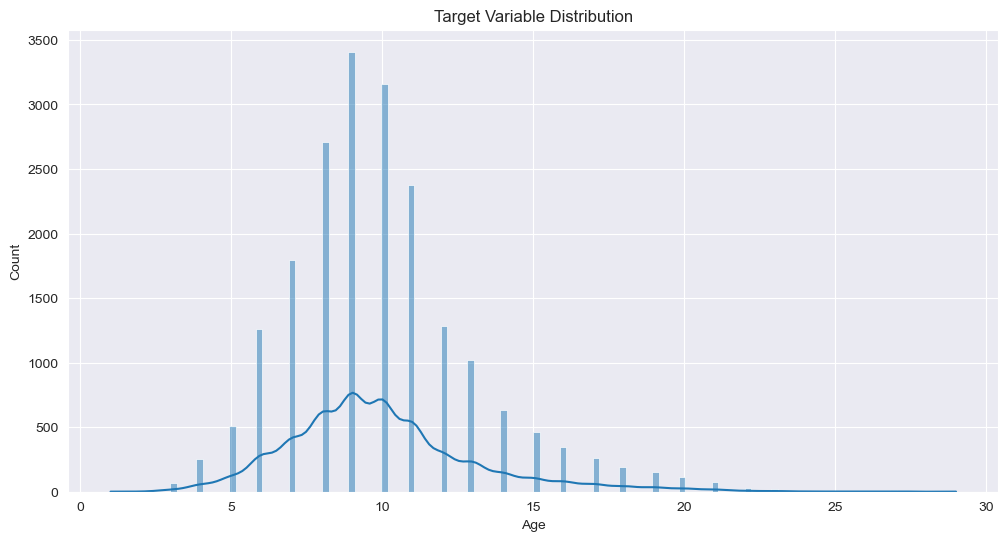

In [8]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.histplot(x='Age', data=train, kde=True)
plt.title('Target Variable Distribution')
plt.show()

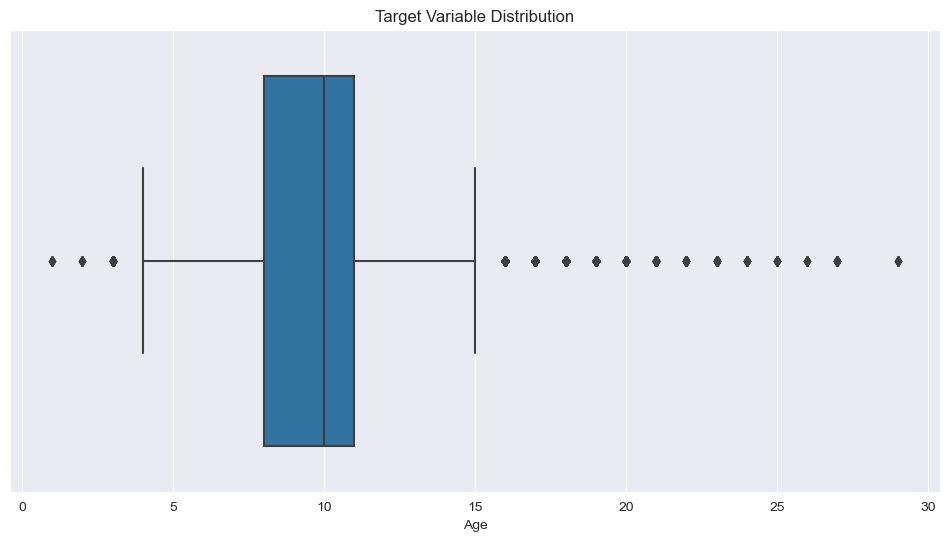

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', data=train)
plt.title('Target Variable Distribution')
plt.show()


Since we have a lot of outliers, I deciced to cap them at the 90th percentile because outliers introduce noise but may also contain valuable information 

In [10]:
# Calculate the 90th percentile of the 'Age' column
age_90th_percentile = train['Age'].quantile(0.90)

# Cap the outliers at the 90th percentile
train['Age'] = train['Age'].clip(upper=age_90th_percentile)

# Verify the updated column
print(train['Age'])


0         9
1         8
2         9
3        11
4         8
         ..
20186     8
20187    11
20188     7
20189    10
20190    14
Name: Age, Length: 20191, dtype: int64


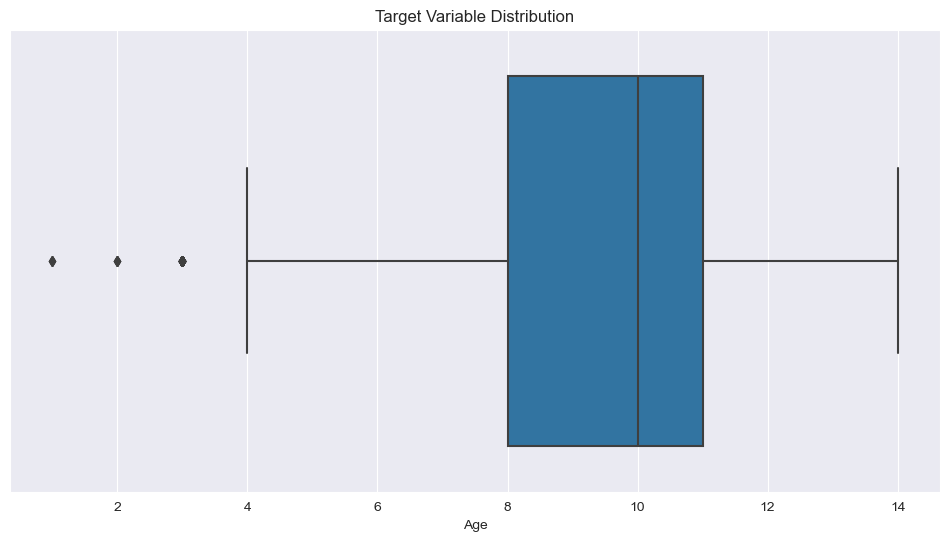

In [11]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', data=train)
plt.title('Target Variable Distribution')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_27912\3209112519.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


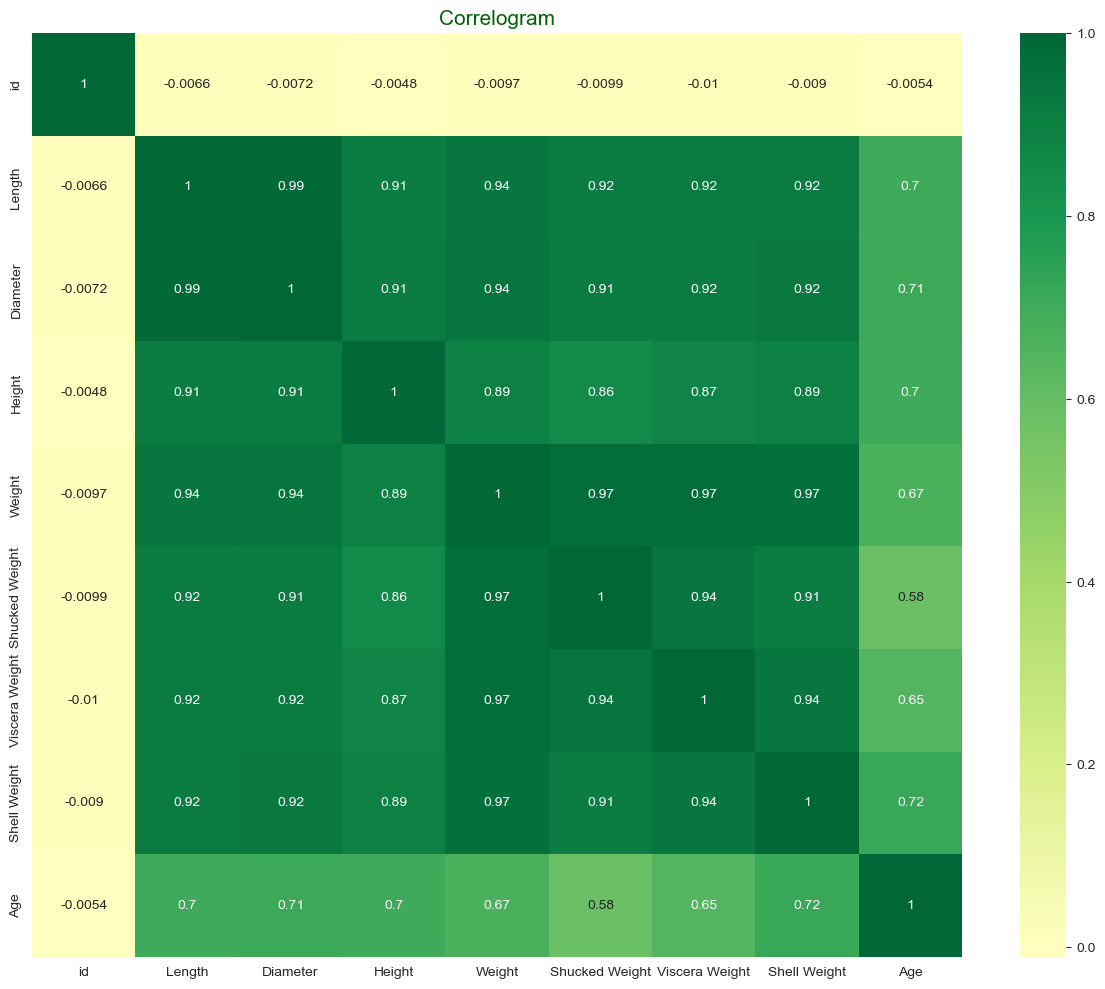

In [12]:
# Plotting a heatmap to show correlations between variables
corr = train.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [13]:
correlation_matrix = train.corr()
print(correlation_matrix['Age'])


id               -0.005404
Length            0.698452
Diameter          0.706346
Height            0.698668
Weight            0.665789
Shucked Weight    0.581024
Viscera Weight    0.646409
Shell Weight      0.717437
Age               1.000000
Name: Age, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_27912\3469749954.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


<a name="Preprocess"></a>
## 6. Modeling

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit the encoder on the 'Sex' column in the train data
encoder.fit(train[['Sex']])

# Transform the 'Sex' column in the train data
train_encoded = encoder.transform(train[['Sex']])

# Transform the 'Sex' column in the test data
test_encoded = encoder.transform(test[['Sex']])

# Drop the original 'Sex' column from the train and test data
train = train.drop('Sex', axis=1)
test = test.drop('Sex', axis=1)

# Concatenate the encoded columns to the train and test data
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Sex']))
train = pd.concat([train, train_encoded_df], axis=1)

test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Sex']))
test = pd.concat([test, test_encoded_df], axis=1)


C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
train.head()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.0,1.0,0.0
1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.0,1.0,0.0
2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.0,0.0,1.0
3,3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1.0,0.0,0.0
4,4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.0,1.0,0.0


In [16]:
test_data = test.copy()

In [17]:
#scale numerical features for logistic model
features = train.drop(columns=['id','Age']).columns
target = 'Age'

# define standard scaler
scaler = StandardScaler()

# transform data
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [18]:
train.head()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,0,0.719741,0.632352,0.289070,0.438201,0.461923,0.566386,0.451193,9,-0.673136,1.449011,-0.759072
1,1,-0.755650,-0.839573,-0.784094,-1.020802,-0.992025,-0.976836,-0.923041,8,-0.673136,1.449011,-0.759072
2,2,0.242408,0.369508,0.289070,0.108281,0.215832,0.176786,-0.017385,9,-0.673136,-0.690126,1.317398
3,3,1.327255,1.631157,1.630526,2.143529,1.812915,2.116955,2.297943,11,1.485583,-0.690126,-0.759072
4,4,-0.234924,-0.051042,-0.113366,-0.008751,0.328833,-0.197635,-0.214267,8,-0.673136,1.449011,-0.759072


In [19]:
test = test.drop(columns=['id'])

In [20]:
#split train data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(train[features], 
                                                    train[target].to_frame(),
                                                    stratify=train[target], #to account for class imbalance
                                                    test_size=0.3,
                                                    random_state=SEED)

In [21]:
X_train.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
10301,-1.406558,-1.417829,-1.320676,-1.335117,-1.293361,-1.310779,-1.316804,-0.673136,1.449011,-0.759072
4700,-1.710315,-1.575535,-1.320676,-1.448806,-1.474163,-1.371496,-1.474309,1.485583,-0.690126,-0.759072
9072,0.415984,0.632352,0.959798,0.382471,0.461923,0.146427,0.203122,1.485583,-0.690126,-0.759072
16392,-1.970678,-1.996084,-1.991404,-1.570296,-1.577119,-1.568826,-1.592438,-0.673136,1.449011,-0.759072
17913,-0.451893,-0.419023,-1.052385,-0.839123,-0.904135,-0.885760,-0.686783,-0.673136,1.449011,-0.759072


In [22]:
y_train.head()

,Age
10301,8
4700,7
9072,14
16392,5
17913,9


In [23]:
# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    "Support Vector Regression": SVR(),
    "XGBoost": xgb.XGBRegressor(),
    "CatBoost": cb.CatBoostRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    "AdaBoost Regression": AdaBoostRegressor()
}

# Define lists to store the evaluation metrics
metrics = {
    "Model": [],
    "MSE": [],
    "MAE": [],
    "R-squared": []
}

# Iterate over the models
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train['Age'])
    
    # Make predictions on the validation set
    preds = model.predict(X_test)
    
    # Calculate the evaluation metrics
    mse = mean_squared_error(y_test['Age'], preds)
    mae = mean_absolute_error(y_test['Age'], preds)
    r2 = r2_score(y_test['Age'], preds)
    
    # Store the metrics in the lists
    metrics["Model"].append(model_name)
    metrics["MSE"].append(mse)
    metrics["MAE"].append(mae)
    metrics["R-squared"].append(r2)

# Convert the metrics to a pandas DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Print the metrics for each model
print(metrics_df)


Learning rate set to 0.062218
0:	learn: 2.4345000	total: 145ms	remaining: 2m 25s
1:	learn: 2.3592476	total: 152ms	remaining: 1m 15s
2:	learn: 2.2914650	total: 159ms	remaining: 52.7s
3:	learn: 2.2228129	total: 165ms	remaining: 41.1s
4:	learn: 2.1643909	total: 172ms	remaining: 34.3s
5:	learn: 2.1097988	total: 179ms	remaining: 29.7s
6:	learn: 2.0603905	total: 187ms	remaining: 26.5s
7:	learn: 2.0124650	total: 192ms	remaining: 23.8s
8:	learn: 1.9721979	total: 197ms	remaining: 21.7s
9:	learn: 1.9338774	total: 203ms	remaining: 20.1s
10:	learn: 1.8983460	total: 207ms	remaining: 18.6s
11:	learn: 1.8671642	total: 210ms	remaining: 17.3s
12:	learn: 1.8398305	total: 214ms	remaining: 16.2s
13:	learn: 1.8141813	total: 217ms	remaining: 15.3s
14:	learn: 1.7900978	total: 222ms	remaining: 14.6s
15:	learn: 1.7674548	total: 226ms	remaining: 13.9s
16:	learn: 1.7475860	total: 230ms	remaining: 13.3s
17:	learn: 1.7295100	total: 235ms	remaining: 12.8s
18:	learn: 1.7113113	total: 240ms	remaining: 12.4s
19:	learn

168:	learn: 1.4521507	total: 1.02s	remaining: 5s
169:	learn: 1.4517302	total: 1.02s	remaining: 4.99s
170:	learn: 1.4514665	total: 1.03s	remaining: 4.99s
171:	learn: 1.4511303	total: 1.04s	remaining: 5.01s
172:	learn: 1.4509219	total: 1.05s	remaining: 5.01s
173:	learn: 1.4507286	total: 1.05s	remaining: 5.01s
174:	learn: 1.4501325	total: 1.06s	remaining: 5.02s
175:	learn: 1.4497872	total: 1.07s	remaining: 5.02s
176:	learn: 1.4495130	total: 1.08s	remaining: 5.02s
177:	learn: 1.4492572	total: 1.08s	remaining: 5.01s
178:	learn: 1.4491018	total: 1.09s	remaining: 5.01s
179:	learn: 1.4488345	total: 1.1s	remaining: 5s
180:	learn: 1.4482061	total: 1.1s	remaining: 5s
181:	learn: 1.4476587	total: 1.11s	remaining: 5s
182:	learn: 1.4473115	total: 1.12s	remaining: 4.99s
183:	learn: 1.4470799	total: 1.12s	remaining: 4.98s
184:	learn: 1.4466622	total: 1.13s	remaining: 4.97s
185:	learn: 1.4463755	total: 1.13s	remaining: 4.96s
186:	learn: 1.4457667	total: 1.14s	remaining: 4.95s
187:	learn: 1.4455452	tota

357:	learn: 1.3951651	total: 2.02s	remaining: 3.62s
358:	learn: 1.3949946	total: 2.02s	remaining: 3.61s
359:	learn: 1.3948334	total: 2.03s	remaining: 3.61s
360:	learn: 1.3945973	total: 2.04s	remaining: 3.6s
361:	learn: 1.3941620	total: 2.04s	remaining: 3.6s
362:	learn: 1.3938902	total: 2.05s	remaining: 3.59s
363:	learn: 1.3934606	total: 2.05s	remaining: 3.59s
364:	learn: 1.3932307	total: 2.06s	remaining: 3.59s
365:	learn: 1.3926776	total: 2.07s	remaining: 3.58s
366:	learn: 1.3923615	total: 2.08s	remaining: 3.58s
367:	learn: 1.3921252	total: 2.08s	remaining: 3.58s
368:	learn: 1.3916346	total: 2.09s	remaining: 3.57s
369:	learn: 1.3913746	total: 2.1s	remaining: 3.57s
370:	learn: 1.3910751	total: 2.1s	remaining: 3.56s
371:	learn: 1.3906936	total: 2.11s	remaining: 3.56s
372:	learn: 1.3906358	total: 2.12s	remaining: 3.56s
373:	learn: 1.3905542	total: 2.12s	remaining: 3.55s
374:	learn: 1.3901210	total: 2.13s	remaining: 3.55s
375:	learn: 1.3898698	total: 2.14s	remaining: 3.55s
376:	learn: 1.38

528:	learn: 1.3554648	total: 3.01s	remaining: 2.68s
529:	learn: 1.3552792	total: 3.02s	remaining: 2.67s
530:	learn: 1.3549426	total: 3.02s	remaining: 2.67s
531:	learn: 1.3546847	total: 3.03s	remaining: 2.66s
532:	learn: 1.3544519	total: 3.03s	remaining: 2.66s
533:	learn: 1.3541370	total: 3.04s	remaining: 2.65s
534:	learn: 1.3539493	total: 3.04s	remaining: 2.65s
535:	learn: 1.3536982	total: 3.05s	remaining: 2.64s
536:	learn: 1.3535550	total: 3.05s	remaining: 2.63s
537:	learn: 1.3533591	total: 3.06s	remaining: 2.63s
538:	learn: 1.3531774	total: 3.07s	remaining: 2.62s
539:	learn: 1.3528607	total: 3.07s	remaining: 2.62s
540:	learn: 1.3524533	total: 3.08s	remaining: 2.61s
541:	learn: 1.3523835	total: 3.08s	remaining: 2.6s
542:	learn: 1.3521180	total: 3.09s	remaining: 2.6s
543:	learn: 1.3519956	total: 3.1s	remaining: 2.59s
544:	learn: 1.3517957	total: 3.1s	remaining: 2.59s
545:	learn: 1.3514558	total: 3.11s	remaining: 2.58s
546:	learn: 1.3511729	total: 3.11s	remaining: 2.58s
547:	learn: 1.35

689:	learn: 1.3245623	total: 4.02s	remaining: 1.81s
690:	learn: 1.3244861	total: 4.03s	remaining: 1.8s
691:	learn: 1.3243517	total: 4.04s	remaining: 1.8s
692:	learn: 1.3242169	total: 4.04s	remaining: 1.79s
693:	learn: 1.3241632	total: 4.05s	remaining: 1.78s
694:	learn: 1.3238269	total: 4.06s	remaining: 1.78s
695:	learn: 1.3235359	total: 4.06s	remaining: 1.77s
696:	learn: 1.3234960	total: 4.07s	remaining: 1.77s
697:	learn: 1.3234406	total: 4.08s	remaining: 1.76s
698:	learn: 1.3232256	total: 4.08s	remaining: 1.76s
699:	learn: 1.3231663	total: 4.09s	remaining: 1.75s
700:	learn: 1.3228810	total: 4.1s	remaining: 1.75s
701:	learn: 1.3227694	total: 4.11s	remaining: 1.74s
702:	learn: 1.3226593	total: 4.11s	remaining: 1.74s
703:	learn: 1.3223044	total: 4.12s	remaining: 1.73s
704:	learn: 1.3220844	total: 4.13s	remaining: 1.73s
705:	learn: 1.3220211	total: 4.13s	remaining: 1.72s
706:	learn: 1.3218160	total: 4.14s	remaining: 1.72s
707:	learn: 1.3217008	total: 4.15s	remaining: 1.71s
708:	learn: 1.3

871:	learn: 1.2920930	total: 5.46s	remaining: 802ms
872:	learn: 1.2920825	total: 5.47s	remaining: 796ms
873:	learn: 1.2919847	total: 5.48s	remaining: 790ms
874:	learn: 1.2917564	total: 5.49s	remaining: 784ms
875:	learn: 1.2915567	total: 5.5s	remaining: 778ms
876:	learn: 1.2913318	total: 5.5s	remaining: 772ms
877:	learn: 1.2910665	total: 5.51s	remaining: 766ms
878:	learn: 1.2908344	total: 5.52s	remaining: 760ms
879:	learn: 1.2906799	total: 5.53s	remaining: 754ms
880:	learn: 1.2905457	total: 5.54s	remaining: 748ms
881:	learn: 1.2903953	total: 5.55s	remaining: 742ms
882:	learn: 1.2900728	total: 5.55s	remaining: 736ms
883:	learn: 1.2899027	total: 5.56s	remaining: 730ms
884:	learn: 1.2896644	total: 5.57s	remaining: 724ms
885:	learn: 1.2895253	total: 5.58s	remaining: 718ms
886:	learn: 1.2894335	total: 5.59s	remaining: 712ms
887:	learn: 1.2892095	total: 5.59s	remaining: 706ms
888:	learn: 1.2890905	total: 5.6s	remaining: 700ms
889:	learn: 1.2889664	total: 5.61s	remaining: 694ms
890:	learn: 1.2

In [24]:
sorted_metrics_df = metrics_df.sort_values(by='MSE', ascending=True)
print(sorted_metrics_df)


                           Model       MSE       MAE  R-squared
10                      LightGBM  2.217743  1.145023   0.650608
9                       CatBoost  2.224177  1.145789   0.649595
6   Gradient Boosting Regression  2.225797  1.154548   0.649340
7      Support Vector Regression  2.273057  1.138347   0.641894
5       Random Forest Regression  2.306500  1.173684   0.636625
8                        XGBoost  2.330317  1.168163   0.632873
2               Ridge Regression  2.404141  1.205030   0.621242
0              Linear Regression  2.404177  1.205007   0.621237
1                     ElasticNet  3.382995  1.479585   0.467030
11           AdaBoost Regression  3.403978  1.565010   0.463724
3               Lasso Regression  4.044748  1.619107   0.362775
4       Decision Tree Regression  4.500825  1.557610   0.290923


## Hyperparameter tuning 

#### Hyperparameter tuning catboost 

In [25]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [3, 5, 7],
    'iterations': [100, 200, 300]
}

# Initialize the CatBoostRegressor
model = CatBoostRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
cat_hyper_model = grid_search.best_estimator_
best_cat_hyper_params = grid_search.best_params_

# Make predictions on the validation set using the best model
preds_cat_h = cat_hyper_model.predict(X_test)

# Calculate the evaluation metrics
cat_mse_h = mean_squared_error(y_test['Age'], preds_cat_h)
cat_mae_h = mean_absolute_error(y_test['Age'], preds_cat_h)
cat_r2_h = r2_score(y_test['Age'], preds_cat_h)



0:	learn: 2.3945090	total: 4.73ms	remaining: 469ms
1:	learn: 2.2896500	total: 8.51ms	remaining: 417ms
2:	learn: 2.1934977	total: 12.2ms	remaining: 393ms
3:	learn: 2.1139055	total: 16ms	remaining: 383ms
4:	learn: 2.0464009	total: 20.1ms	remaining: 383ms
5:	learn: 1.9866455	total: 24.8ms	remaining: 388ms
6:	learn: 1.9344584	total: 33.5ms	remaining: 444ms
7:	learn: 1.8890171	total: 38.9ms	remaining: 447ms
8:	learn: 1.8507595	total: 43ms	remaining: 435ms
9:	learn: 1.8166307	total: 47.5ms	remaining: 427ms
10:	learn: 1.7895152	total: 51.8ms	remaining: 419ms
11:	learn: 1.7639916	total: 58.8ms	remaining: 431ms
12:	learn: 1.7425598	total: 64.1ms	remaining: 429ms
13:	learn: 1.7233801	total: 68.9ms	remaining: 423ms
14:	learn: 1.7073223	total: 73.1ms	remaining: 414ms
15:	learn: 1.6942509	total: 77ms	remaining: 404ms
16:	learn: 1.6826088	total: 80.6ms	remaining: 394ms
17:	learn: 1.6684940	total: 85.7ms	remaining: 390ms
18:	learn: 1.6603402	total: 89.1ms	remaining: 380ms
19:	learn: 1.6498675	total: 

60:	learn: 1.5196503	total: 272ms	remaining: 174ms
61:	learn: 1.5189220	total: 277ms	remaining: 169ms
62:	learn: 1.5177037	total: 281ms	remaining: 165ms
63:	learn: 1.5171022	total: 286ms	remaining: 161ms
64:	learn: 1.5150690	total: 291ms	remaining: 156ms
65:	learn: 1.5146029	total: 294ms	remaining: 152ms
66:	learn: 1.5132937	total: 299ms	remaining: 147ms
67:	learn: 1.5118683	total: 303ms	remaining: 143ms
68:	learn: 1.5112497	total: 308ms	remaining: 138ms
69:	learn: 1.5098159	total: 312ms	remaining: 134ms
70:	learn: 1.5094157	total: 316ms	remaining: 129ms
71:	learn: 1.5090330	total: 321ms	remaining: 125ms
72:	learn: 1.5085566	total: 325ms	remaining: 120ms
73:	learn: 1.5072948	total: 330ms	remaining: 116ms
74:	learn: 1.5065276	total: 335ms	remaining: 112ms
75:	learn: 1.5054620	total: 339ms	remaining: 107ms
76:	learn: 1.5041707	total: 343ms	remaining: 102ms
77:	learn: 1.5039573	total: 347ms	remaining: 98ms
78:	learn: 1.5025660	total: 352ms	remaining: 93.7ms
79:	learn: 1.5019348	total: 356

59:	learn: 1.5125343	total: 205ms	remaining: 137ms
60:	learn: 1.5102172	total: 209ms	remaining: 133ms
61:	learn: 1.5090296	total: 212ms	remaining: 130ms
62:	learn: 1.5085031	total: 216ms	remaining: 127ms
63:	learn: 1.5075668	total: 219ms	remaining: 123ms
64:	learn: 1.5069547	total: 222ms	remaining: 120ms
65:	learn: 1.5063758	total: 226ms	remaining: 116ms
66:	learn: 1.5052561	total: 229ms	remaining: 113ms
67:	learn: 1.5047247	total: 232ms	remaining: 109ms
68:	learn: 1.5029562	total: 235ms	remaining: 106ms
69:	learn: 1.5023206	total: 239ms	remaining: 102ms
70:	learn: 1.5016791	total: 242ms	remaining: 99ms
71:	learn: 1.5013599	total: 246ms	remaining: 95.5ms
72:	learn: 1.4999895	total: 249ms	remaining: 92.1ms
73:	learn: 1.4994536	total: 253ms	remaining: 88.8ms
74:	learn: 1.4983209	total: 256ms	remaining: 85.3ms
75:	learn: 1.4968277	total: 259ms	remaining: 81.9ms
76:	learn: 1.4953127	total: 263ms	remaining: 78.6ms
77:	learn: 1.4949042	total: 266ms	remaining: 75.1ms
78:	learn: 1.4935961	tota

48:	learn: 2.0660274	total: 198ms	remaining: 207ms
49:	learn: 2.0593846	total: 205ms	remaining: 205ms
50:	learn: 2.0528773	total: 209ms	remaining: 201ms
51:	learn: 2.0468682	total: 213ms	remaining: 196ms
52:	learn: 2.0408634	total: 217ms	remaining: 192ms
53:	learn: 2.0347867	total: 221ms	remaining: 188ms
54:	learn: 2.0287163	total: 224ms	remaining: 184ms
55:	learn: 2.0226112	total: 228ms	remaining: 179ms
56:	learn: 2.0169502	total: 232ms	remaining: 175ms
57:	learn: 2.0112507	total: 236ms	remaining: 171ms
58:	learn: 2.0055433	total: 239ms	remaining: 166ms
59:	learn: 1.9998737	total: 243ms	remaining: 162ms
60:	learn: 1.9944863	total: 246ms	remaining: 158ms
61:	learn: 1.9892197	total: 250ms	remaining: 153ms
62:	learn: 1.9838500	total: 254ms	remaining: 149ms
63:	learn: 1.9785623	total: 258ms	remaining: 145ms
64:	learn: 1.9733427	total: 262ms	remaining: 141ms
65:	learn: 1.9681579	total: 266ms	remaining: 137ms
66:	learn: 1.9629818	total: 269ms	remaining: 133ms
67:	learn: 1.9581545	total: 273

51:	learn: 2.0454190	total: 206ms	remaining: 190ms
52:	learn: 2.0393629	total: 210ms	remaining: 186ms
53:	learn: 2.0332608	total: 213ms	remaining: 182ms
54:	learn: 2.0271245	total: 217ms	remaining: 178ms
55:	learn: 2.0210490	total: 222ms	remaining: 174ms
56:	learn: 2.0153810	total: 226ms	remaining: 170ms
57:	learn: 2.0096111	total: 230ms	remaining: 166ms
58:	learn: 2.0037841	total: 233ms	remaining: 162ms
59:	learn: 1.9981747	total: 238ms	remaining: 159ms
60:	learn: 1.9928831	total: 243ms	remaining: 155ms
61:	learn: 1.9873303	total: 246ms	remaining: 151ms
62:	learn: 1.9817963	total: 250ms	remaining: 147ms
63:	learn: 1.9765250	total: 254ms	remaining: 143ms
64:	learn: 1.9711354	total: 258ms	remaining: 139ms
65:	learn: 1.9659250	total: 262ms	remaining: 135ms
66:	learn: 1.9609085	total: 265ms	remaining: 131ms
67:	learn: 1.9558448	total: 269ms	remaining: 127ms
68:	learn: 1.9509983	total: 272ms	remaining: 122ms
69:	learn: 1.9461968	total: 276ms	remaining: 118ms
70:	learn: 1.9413528	total: 279

58:	learn: 2.0067979	total: 198ms	remaining: 137ms
59:	learn: 2.0009763	total: 201ms	remaining: 134ms
60:	learn: 1.9954920	total: 204ms	remaining: 131ms
61:	learn: 1.9900817	total: 207ms	remaining: 127ms
62:	learn: 1.9845833	total: 211ms	remaining: 124ms
63:	learn: 1.9790822	total: 214ms	remaining: 120ms
64:	learn: 1.9736433	total: 217ms	remaining: 117ms
65:	learn: 1.9683966	total: 220ms	remaining: 113ms
66:	learn: 1.9633147	total: 223ms	remaining: 110ms
67:	learn: 1.9580422	total: 226ms	remaining: 106ms
68:	learn: 1.9530434	total: 229ms	remaining: 103ms
69:	learn: 1.9481505	total: 232ms	remaining: 99.5ms
70:	learn: 1.9432655	total: 235ms	remaining: 96.1ms
71:	learn: 1.9384434	total: 238ms	remaining: 92.7ms
72:	learn: 1.9336358	total: 241ms	remaining: 89.3ms
73:	learn: 1.9291191	total: 244ms	remaining: 85.9ms
74:	learn: 1.9243268	total: 248ms	remaining: 82.7ms
75:	learn: 1.9197428	total: 251ms	remaining: 79.3ms
76:	learn: 1.9153951	total: 254ms	remaining: 76ms
77:	learn: 1.9110153	tota

53:	learn: 2.4441437	total: 202ms	remaining: 172ms
54:	learn: 2.4429470	total: 205ms	remaining: 168ms
55:	learn: 2.4417474	total: 208ms	remaining: 164ms
56:	learn: 2.4405555	total: 212ms	remaining: 160ms
57:	learn: 2.4393892	total: 215ms	remaining: 156ms
58:	learn: 2.4382155	total: 218ms	remaining: 152ms
59:	learn: 2.4370238	total: 222ms	remaining: 148ms
60:	learn: 2.4358716	total: 225ms	remaining: 144ms
61:	learn: 2.4347159	total: 228ms	remaining: 140ms
62:	learn: 2.4335241	total: 231ms	remaining: 136ms
63:	learn: 2.4323801	total: 234ms	remaining: 132ms
64:	learn: 2.4312125	total: 237ms	remaining: 128ms
65:	learn: 2.4300421	total: 241ms	remaining: 124ms
66:	learn: 2.4288697	total: 244ms	remaining: 120ms
67:	learn: 2.4277289	total: 247ms	remaining: 116ms
68:	learn: 2.4265753	total: 251ms	remaining: 113ms
69:	learn: 2.4253991	total: 254ms	remaining: 109ms
70:	learn: 2.4242415	total: 257ms	remaining: 105ms
71:	learn: 2.4230923	total: 260ms	remaining: 101ms
72:	learn: 2.4219215	total: 264

50:	learn: 2.4529821	total: 197ms	remaining: 190ms
51:	learn: 2.4518265	total: 201ms	remaining: 186ms
52:	learn: 2.4506552	total: 204ms	remaining: 181ms
53:	learn: 2.4494605	total: 208ms	remaining: 177ms
54:	learn: 2.4482611	total: 211ms	remaining: 173ms
55:	learn: 2.4470623	total: 215ms	remaining: 169ms
56:	learn: 2.4459183	total: 218ms	remaining: 164ms
57:	learn: 2.4447317	total: 221ms	remaining: 160ms
58:	learn: 2.4435548	total: 225ms	remaining: 156ms
59:	learn: 2.4423505	total: 228ms	remaining: 152ms
60:	learn: 2.4412001	total: 231ms	remaining: 148ms
61:	learn: 2.4400537	total: 234ms	remaining: 144ms
62:	learn: 2.4388752	total: 238ms	remaining: 140ms
63:	learn: 2.4377449	total: 242ms	remaining: 136ms
64:	learn: 2.4365661	total: 245ms	remaining: 132ms
65:	learn: 2.4353973	total: 249ms	remaining: 128ms
66:	learn: 2.4342075	total: 252ms	remaining: 124ms
67:	learn: 2.4330448	total: 255ms	remaining: 120ms
68:	learn: 2.4318895	total: 258ms	remaining: 116ms
69:	learn: 2.4307045	total: 262

59:	learn: 1.5252730	total: 201ms	remaining: 470ms
60:	learn: 1.5232113	total: 205ms	remaining: 468ms
61:	learn: 1.5217870	total: 209ms	remaining: 465ms
62:	learn: 1.5194258	total: 212ms	remaining: 461ms
63:	learn: 1.5184979	total: 216ms	remaining: 458ms
64:	learn: 1.5178907	total: 220ms	remaining: 457ms
65:	learn: 1.5172339	total: 223ms	remaining: 453ms
66:	learn: 1.5165623	total: 227ms	remaining: 450ms
67:	learn: 1.5160139	total: 230ms	remaining: 447ms
68:	learn: 1.5153462	total: 235ms	remaining: 445ms
69:	learn: 1.5146875	total: 238ms	remaining: 442ms
70:	learn: 1.5141000	total: 241ms	remaining: 438ms
71:	learn: 1.5137137	total: 244ms	remaining: 434ms
72:	learn: 1.5123705	total: 248ms	remaining: 432ms
73:	learn: 1.5117928	total: 252ms	remaining: 429ms
74:	learn: 1.5100651	total: 255ms	remaining: 425ms
75:	learn: 1.5097658	total: 258ms	remaining: 422ms
76:	learn: 1.5082160	total: 262ms	remaining: 419ms
77:	learn: 1.5078372	total: 267ms	remaining: 418ms
78:	learn: 1.5062997	total: 271

59:	learn: 1.5204612	total: 208ms	remaining: 486ms
60:	learn: 1.5196503	total: 212ms	remaining: 484ms
61:	learn: 1.5189220	total: 217ms	remaining: 482ms
62:	learn: 1.5177037	total: 221ms	remaining: 480ms
63:	learn: 1.5171022	total: 224ms	remaining: 477ms
64:	learn: 1.5150690	total: 229ms	remaining: 475ms
65:	learn: 1.5146029	total: 233ms	remaining: 473ms
66:	learn: 1.5132937	total: 237ms	remaining: 470ms
67:	learn: 1.5118683	total: 241ms	remaining: 468ms
68:	learn: 1.5112497	total: 245ms	remaining: 465ms
69:	learn: 1.5098159	total: 249ms	remaining: 463ms
70:	learn: 1.5094157	total: 253ms	remaining: 460ms
71:	learn: 1.5090330	total: 257ms	remaining: 457ms
72:	learn: 1.5085566	total: 261ms	remaining: 453ms
73:	learn: 1.5072948	total: 264ms	remaining: 450ms
74:	learn: 1.5065276	total: 269ms	remaining: 449ms
75:	learn: 1.5054620	total: 273ms	remaining: 446ms
76:	learn: 1.5041707	total: 277ms	remaining: 443ms
77:	learn: 1.5039573	total: 281ms	remaining: 439ms
78:	learn: 1.5025660	total: 286

55:	learn: 1.5342955	total: 208ms	remaining: 534ms
56:	learn: 1.5328310	total: 212ms	remaining: 533ms
57:	learn: 1.5318811	total: 216ms	remaining: 529ms
58:	learn: 1.5296417	total: 219ms	remaining: 524ms
59:	learn: 1.5288758	total: 223ms	remaining: 521ms
60:	learn: 1.5279725	total: 228ms	remaining: 520ms
61:	learn: 1.5275717	total: 231ms	remaining: 515ms
62:	learn: 1.5248471	total: 235ms	remaining: 511ms
63:	learn: 1.5239766	total: 239ms	remaining: 507ms
64:	learn: 1.5222420	total: 244ms	remaining: 506ms
65:	learn: 1.5211946	total: 247ms	remaining: 502ms
66:	learn: 1.5202950	total: 251ms	remaining: 499ms
67:	learn: 1.5187285	total: 255ms	remaining: 495ms
68:	learn: 1.5182456	total: 259ms	remaining: 492ms
69:	learn: 1.5175868	total: 263ms	remaining: 489ms
70:	learn: 1.5171315	total: 267ms	remaining: 486ms
71:	learn: 1.5167418	total: 272ms	remaining: 483ms
72:	learn: 1.5160795	total: 276ms	remaining: 479ms
73:	learn: 1.5158819	total: 279ms	remaining: 476ms
74:	learn: 1.5142647	total: 283

60:	learn: 1.5102172	total: 206ms	remaining: 469ms
61:	learn: 1.5090296	total: 210ms	remaining: 467ms
62:	learn: 1.5085031	total: 213ms	remaining: 464ms
63:	learn: 1.5075668	total: 217ms	remaining: 460ms
64:	learn: 1.5069547	total: 220ms	remaining: 457ms
65:	learn: 1.5063758	total: 223ms	remaining: 453ms
66:	learn: 1.5052561	total: 226ms	remaining: 449ms
67:	learn: 1.5047247	total: 230ms	remaining: 446ms
68:	learn: 1.5029562	total: 233ms	remaining: 442ms
69:	learn: 1.5023206	total: 236ms	remaining: 439ms
70:	learn: 1.5016791	total: 240ms	remaining: 435ms
71:	learn: 1.5013599	total: 243ms	remaining: 432ms
72:	learn: 1.4999895	total: 246ms	remaining: 428ms
73:	learn: 1.4994536	total: 249ms	remaining: 424ms
74:	learn: 1.4983209	total: 252ms	remaining: 420ms
75:	learn: 1.4968277	total: 256ms	remaining: 417ms
76:	learn: 1.4953127	total: 259ms	remaining: 413ms
77:	learn: 1.4949042	total: 262ms	remaining: 410ms
78:	learn: 1.4935961	total: 265ms	remaining: 406ms
79:	learn: 1.4931306	total: 269

68:	learn: 1.5108638	total: 249ms	remaining: 472ms
69:	learn: 1.5095149	total: 253ms	remaining: 470ms
70:	learn: 1.5091543	total: 257ms	remaining: 467ms
71:	learn: 1.5087899	total: 260ms	remaining: 462ms
72:	learn: 1.5075881	total: 263ms	remaining: 458ms
73:	learn: 1.5073847	total: 266ms	remaining: 454ms
74:	learn: 1.5066706	total: 270ms	remaining: 451ms
75:	learn: 1.5065169	total: 274ms	remaining: 446ms
76:	learn: 1.5063274	total: 277ms	remaining: 442ms
77:	learn: 1.5059184	total: 280ms	remaining: 438ms
78:	learn: 1.5054103	total: 283ms	remaining: 434ms
79:	learn: 1.5048582	total: 287ms	remaining: 431ms
80:	learn: 1.5042800	total: 291ms	remaining: 427ms
81:	learn: 1.5031961	total: 294ms	remaining: 423ms
82:	learn: 1.5022028	total: 297ms	remaining: 419ms
83:	learn: 1.5018222	total: 301ms	remaining: 415ms
84:	learn: 1.5003785	total: 304ms	remaining: 412ms
85:	learn: 1.4993061	total: 308ms	remaining: 408ms
86:	learn: 1.4985791	total: 311ms	remaining: 404ms
87:	learn: 1.4983318	total: 314

63:	learn: 1.9785623	total: 261ms	remaining: 555ms
64:	learn: 1.9733427	total: 265ms	remaining: 551ms
65:	learn: 1.9681579	total: 269ms	remaining: 547ms
66:	learn: 1.9629818	total: 274ms	remaining: 544ms
67:	learn: 1.9581545	total: 278ms	remaining: 539ms
68:	learn: 1.9533174	total: 281ms	remaining: 534ms
69:	learn: 1.9484967	total: 285ms	remaining: 530ms
70:	learn: 1.9435713	total: 291ms	remaining: 529ms
71:	learn: 1.9390729	total: 295ms	remaining: 524ms
72:	learn: 1.9343135	total: 298ms	remaining: 519ms
73:	learn: 1.9295970	total: 302ms	remaining: 515ms
74:	learn: 1.9249343	total: 307ms	remaining: 512ms
75:	learn: 1.9204814	total: 311ms	remaining: 507ms
76:	learn: 1.9160943	total: 315ms	remaining: 503ms
77:	learn: 1.9117933	total: 319ms	remaining: 498ms
78:	learn: 1.9075555	total: 323ms	remaining: 494ms
79:	learn: 1.9032606	total: 327ms	remaining: 490ms
80:	learn: 1.8991084	total: 331ms	remaining: 486ms
81:	learn: 1.8950521	total: 335ms	remaining: 482ms
82:	learn: 1.8909815	total: 339

52:	learn: 2.0302696	total: 208ms	remaining: 578ms
53:	learn: 2.0242171	total: 213ms	remaining: 575ms
54:	learn: 2.0181035	total: 217ms	remaining: 573ms
55:	learn: 2.0120170	total: 221ms	remaining: 568ms
56:	learn: 2.0061024	total: 224ms	remaining: 563ms
57:	learn: 2.0004274	total: 228ms	remaining: 558ms
58:	learn: 1.9946215	total: 233ms	remaining: 556ms
59:	learn: 1.9888513	total: 237ms	remaining: 554ms
60:	learn: 1.9835398	total: 241ms	remaining: 549ms
61:	learn: 1.9782303	total: 245ms	remaining: 545ms
62:	learn: 1.9727356	total: 249ms	remaining: 542ms
63:	learn: 1.9673624	total: 253ms	remaining: 538ms
64:	learn: 1.9620676	total: 257ms	remaining: 533ms
65:	learn: 1.9569512	total: 261ms	remaining: 529ms
66:	learn: 1.9520368	total: 265ms	remaining: 526ms
67:	learn: 1.9468691	total: 268ms	remaining: 521ms
68:	learn: 1.9420584	total: 272ms	remaining: 517ms
69:	learn: 1.9372297	total: 276ms	remaining: 512ms
70:	learn: 1.9323160	total: 280ms	remaining: 509ms
71:	learn: 1.9278161	total: 284

52:	learn: 2.0393629	total: 210ms	remaining: 583ms
53:	learn: 2.0332608	total: 214ms	remaining: 579ms
54:	learn: 2.0271245	total: 218ms	remaining: 574ms
55:	learn: 2.0210490	total: 223ms	remaining: 573ms
56:	learn: 2.0153810	total: 227ms	remaining: 568ms
57:	learn: 2.0096111	total: 230ms	remaining: 564ms
58:	learn: 2.0037841	total: 234ms	remaining: 560ms
59:	learn: 1.9981747	total: 239ms	remaining: 559ms
60:	learn: 1.9928831	total: 243ms	remaining: 554ms
61:	learn: 1.9873303	total: 247ms	remaining: 549ms
62:	learn: 1.9817963	total: 251ms	remaining: 545ms
63:	learn: 1.9765250	total: 255ms	remaining: 542ms
64:	learn: 1.9711354	total: 259ms	remaining: 538ms
65:	learn: 1.9659250	total: 263ms	remaining: 533ms
66:	learn: 1.9609085	total: 268ms	remaining: 531ms
67:	learn: 1.9558448	total: 272ms	remaining: 527ms
68:	learn: 1.9509983	total: 276ms	remaining: 524ms
69:	learn: 1.9461968	total: 280ms	remaining: 520ms
70:	learn: 1.9413528	total: 284ms	remaining: 516ms
71:	learn: 1.9368153	total: 288

38:	learn: 2.1270401	total: 201ms	remaining: 830ms
39:	learn: 2.1197753	total: 207ms	remaining: 830ms
40:	learn: 2.1124602	total: 213ms	remaining: 827ms
41:	learn: 2.1052464	total: 220ms	remaining: 826ms
42:	learn: 2.0979294	total: 227ms	remaining: 828ms
43:	learn: 2.0906184	total: 234ms	remaining: 831ms
44:	learn: 2.0836930	total: 239ms	remaining: 824ms
45:	learn: 2.0767475	total: 255ms	remaining: 852ms
46:	learn: 2.0699352	total: 265ms	remaining: 862ms
47:	learn: 2.0636265	total: 272ms	remaining: 863ms
48:	learn: 2.0568575	total: 280ms	remaining: 864ms
49:	learn: 2.0502985	total: 288ms	remaining: 863ms
50:	learn: 2.0437078	total: 297ms	remaining: 868ms
51:	learn: 2.0375983	total: 305ms	remaining: 868ms
52:	learn: 2.0316062	total: 313ms	remaining: 867ms
53:	learn: 2.0254847	total: 317ms	remaining: 858ms
54:	learn: 2.0193270	total: 329ms	remaining: 867ms
55:	learn: 2.0132266	total: 334ms	remaining: 859ms
56:	learn: 2.0076428	total: 341ms	remaining: 856ms
57:	learn: 2.0018584	total: 347

5:	learn: 2.4580697	total: 21.9ms	remaining: 708ms
6:	learn: 2.4459929	total: 25.9ms	remaining: 714ms
7:	learn: 2.4346340	total: 29ms	remaining: 697ms
8:	learn: 2.4227913	total: 32.4ms	remaining: 688ms
9:	learn: 2.4115150	total: 35.8ms	remaining: 680ms
10:	learn: 2.4001691	total: 39.2ms	remaining: 673ms
11:	learn: 2.3888462	total: 42.6ms	remaining: 668ms
12:	learn: 2.3777397	total: 46ms	remaining: 662ms
13:	learn: 2.3666847	total: 49.8ms	remaining: 662ms
14:	learn: 2.3559591	total: 53ms	remaining: 654ms
15:	learn: 2.3452561	total: 56.3ms	remaining: 647ms
16:	learn: 2.3350481	total: 59.5ms	remaining: 640ms
17:	learn: 2.3252826	total: 63ms	remaining: 637ms
18:	learn: 2.3149188	total: 66.2ms	remaining: 631ms
19:	learn: 2.3046347	total: 69.5ms	remaining: 626ms
20:	learn: 2.2944965	total: 72.9ms	remaining: 622ms
21:	learn: 2.2846722	total: 76.5ms	remaining: 619ms
22:	learn: 2.2750705	total: 80ms	remaining: 616ms
23:	learn: 2.2655226	total: 83.5ms	remaining: 612ms
24:	learn: 2.2562298	total:

177:	learn: 1.6735083	total: 625ms	remaining: 77.3ms
178:	learn: 1.6721325	total: 629ms	remaining: 73.8ms
179:	learn: 1.6707543	total: 633ms	remaining: 70.3ms
180:	learn: 1.6696176	total: 636ms	remaining: 66.8ms
181:	learn: 1.6682845	total: 640ms	remaining: 63.3ms
182:	learn: 1.6669397	total: 643ms	remaining: 59.8ms
183:	learn: 1.6656567	total: 646ms	remaining: 56.2ms
184:	learn: 1.6647555	total: 650ms	remaining: 52.7ms
185:	learn: 1.6637617	total: 653ms	remaining: 49.2ms
186:	learn: 1.6627705	total: 657ms	remaining: 45.7ms
187:	learn: 1.6616883	total: 661ms	remaining: 42.2ms
188:	learn: 1.6604362	total: 664ms	remaining: 38.6ms
189:	learn: 1.6596727	total: 667ms	remaining: 35.1ms
190:	learn: 1.6585063	total: 671ms	remaining: 31.6ms
191:	learn: 1.6575889	total: 674ms	remaining: 28.1ms
192:	learn: 1.6564750	total: 678ms	remaining: 24.6ms
193:	learn: 1.6556825	total: 682ms	remaining: 21.1ms
194:	learn: 1.6548378	total: 685ms	remaining: 17.6ms
195:	learn: 1.6541342	total: 689ms	remaining: 

178:	learn: 2.3194713	total: 675ms	remaining: 79.2ms
179:	learn: 2.3184833	total: 680ms	remaining: 75.5ms
180:	learn: 2.3174702	total: 683ms	remaining: 71.7ms
181:	learn: 2.3164830	total: 688ms	remaining: 68ms
182:	learn: 2.3154878	total: 693ms	remaining: 64.3ms
183:	learn: 2.3144869	total: 696ms	remaining: 60.6ms
184:	learn: 2.3135611	total: 700ms	remaining: 56.7ms
185:	learn: 2.3125682	total: 703ms	remaining: 53ms
186:	learn: 2.3116251	total: 707ms	remaining: 49.2ms
187:	learn: 2.3106651	total: 711ms	remaining: 45.4ms
188:	learn: 2.3097014	total: 714ms	remaining: 41.6ms
189:	learn: 2.3087676	total: 718ms	remaining: 37.8ms
190:	learn: 2.3077854	total: 721ms	remaining: 34ms
191:	learn: 2.3068208	total: 725ms	remaining: 30.2ms
192:	learn: 2.3058644	total: 728ms	remaining: 26.4ms
193:	learn: 2.3049022	total: 732ms	remaining: 22.6ms
194:	learn: 2.3039741	total: 736ms	remaining: 18.9ms
195:	learn: 2.3030480	total: 740ms	remaining: 15.1ms
196:	learn: 2.3020768	total: 743ms	remaining: 11.3ms

165:	learn: 2.3216987	total: 654ms	remaining: 134ms
166:	learn: 2.3206983	total: 659ms	remaining: 130ms
167:	learn: 2.3196977	total: 662ms	remaining: 126ms
168:	learn: 2.3187009	total: 666ms	remaining: 122ms
169:	learn: 2.3176796	total: 669ms	remaining: 118ms
170:	learn: 2.3166991	total: 673ms	remaining: 114ms
171:	learn: 2.3156827	total: 676ms	remaining: 110ms
172:	learn: 2.3147007	total: 680ms	remaining: 106ms
173:	learn: 2.3136855	total: 684ms	remaining: 102ms
174:	learn: 2.3126871	total: 687ms	remaining: 98.2ms
175:	learn: 2.3116688	total: 691ms	remaining: 94.2ms
176:	learn: 2.3106631	total: 694ms	remaining: 90.2ms
177:	learn: 2.3096518	total: 698ms	remaining: 86.2ms
178:	learn: 2.3086497	total: 701ms	remaining: 82.3ms
179:	learn: 2.3076423	total: 705ms	remaining: 78.3ms
180:	learn: 2.3066838	total: 708ms	remaining: 74.3ms
181:	learn: 2.3056661	total: 711ms	remaining: 70.3ms
182:	learn: 2.3046702	total: 715ms	remaining: 66.4ms
183:	learn: 2.3036653	total: 718ms	remaining: 62.5ms
18

154:	learn: 2.3425881	total: 632ms	remaining: 183ms
155:	learn: 2.3415606	total: 638ms	remaining: 180ms
156:	learn: 2.3405172	total: 643ms	remaining: 176ms
157:	learn: 2.3394910	total: 647ms	remaining: 172ms
158:	learn: 2.3384565	total: 653ms	remaining: 168ms
159:	learn: 2.3374205	total: 658ms	remaining: 165ms
160:	learn: 2.3364053	total: 663ms	remaining: 161ms
161:	learn: 2.3353655	total: 667ms	remaining: 156ms
162:	learn: 2.3343164	total: 672ms	remaining: 152ms
163:	learn: 2.3333088	total: 675ms	remaining: 148ms
164:	learn: 2.3322981	total: 679ms	remaining: 144ms
165:	learn: 2.3312520	total: 685ms	remaining: 140ms
166:	learn: 2.3302217	total: 689ms	remaining: 136ms
167:	learn: 2.3292164	total: 693ms	remaining: 132ms
168:	learn: 2.3282458	total: 697ms	remaining: 128ms
169:	learn: 2.3272333	total: 703ms	remaining: 124ms
170:	learn: 2.3262360	total: 707ms	remaining: 120ms
171:	learn: 2.3252135	total: 711ms	remaining: 116ms
172:	learn: 2.3242267	total: 717ms	remaining: 112ms
173:	learn: 

117:	learn: 2.3764441	total: 529ms	remaining: 368ms
118:	learn: 2.3753768	total: 534ms	remaining: 363ms
119:	learn: 2.3743046	total: 538ms	remaining: 359ms
120:	learn: 2.3732266	total: 542ms	remaining: 354ms
121:	learn: 2.3721225	total: 546ms	remaining: 349ms
122:	learn: 2.3710347	total: 551ms	remaining: 345ms
123:	learn: 2.3699440	total: 555ms	remaining: 340ms
124:	learn: 2.3688660	total: 559ms	remaining: 335ms
125:	learn: 2.3677532	total: 563ms	remaining: 330ms
126:	learn: 2.3666877	total: 567ms	remaining: 326ms
127:	learn: 2.3655800	total: 571ms	remaining: 321ms
128:	learn: 2.3645234	total: 575ms	remaining: 316ms
129:	learn: 2.3634415	total: 578ms	remaining: 311ms
130:	learn: 2.3623434	total: 584ms	remaining: 307ms
131:	learn: 2.3612746	total: 588ms	remaining: 303ms
132:	learn: 2.3602008	total: 592ms	remaining: 298ms
133:	learn: 2.3591644	total: 596ms	remaining: 293ms
134:	learn: 2.3581028	total: 600ms	remaining: 289ms
135:	learn: 2.3570224	total: 604ms	remaining: 284ms
136:	learn: 

97:	learn: 2.4141856	total: 411ms	remaining: 427ms
98:	learn: 2.4131022	total: 415ms	remaining: 423ms
99:	learn: 2.4119429	total: 419ms	remaining: 419ms
100:	learn: 2.4108331	total: 424ms	remaining: 416ms
101:	learn: 2.4096802	total: 428ms	remaining: 411ms
102:	learn: 2.4085614	total: 432ms	remaining: 407ms
103:	learn: 2.4074216	total: 437ms	remaining: 404ms
104:	learn: 2.4063044	total: 441ms	remaining: 399ms
105:	learn: 2.4051602	total: 445ms	remaining: 395ms
106:	learn: 2.4040351	total: 449ms	remaining: 391ms
107:	learn: 2.4029421	total: 454ms	remaining: 387ms
108:	learn: 2.4018206	total: 458ms	remaining: 382ms
109:	learn: 2.4007237	total: 462ms	remaining: 378ms
110:	learn: 2.3995969	total: 465ms	remaining: 373ms
111:	learn: 2.3984655	total: 470ms	remaining: 369ms
112:	learn: 2.3973397	total: 473ms	remaining: 365ms
113:	learn: 2.3962595	total: 477ms	remaining: 360ms
114:	learn: 2.3951284	total: 481ms	remaining: 355ms
115:	learn: 2.3940341	total: 486ms	remaining: 352ms
116:	learn: 2.3

79:	learn: 1.5056632	total: 328ms	remaining: 902ms
80:	learn: 1.5046094	total: 332ms	remaining: 899ms
81:	learn: 1.5040766	total: 336ms	remaining: 893ms
82:	learn: 1.5030510	total: 341ms	remaining: 892ms
83:	learn: 1.5026045	total: 345ms	remaining: 887ms
84:	learn: 1.5020929	total: 348ms	remaining: 881ms
85:	learn: 1.5013161	total: 352ms	remaining: 876ms
86:	learn: 1.4997505	total: 358ms	remaining: 876ms
87:	learn: 1.4990554	total: 363ms	remaining: 874ms
88:	learn: 1.4988437	total: 366ms	remaining: 869ms
89:	learn: 1.4972439	total: 371ms	remaining: 867ms
90:	learn: 1.4965187	total: 376ms	remaining: 863ms
91:	learn: 1.4959120	total: 379ms	remaining: 857ms
92:	learn: 1.4946953	total: 383ms	remaining: 852ms
93:	learn: 1.4943079	total: 390ms	remaining: 855ms
94:	learn: 1.4931638	total: 394ms	remaining: 850ms
95:	learn: 1.4922179	total: 397ms	remaining: 844ms
96:	learn: 1.4916116	total: 401ms	remaining: 839ms
97:	learn: 1.4908651	total: 405ms	remaining: 835ms
98:	learn: 1.4902863	total: 408

249:	learn: 1.4417710	total: 939ms	remaining: 188ms
250:	learn: 1.4415170	total: 943ms	remaining: 184ms
251:	learn: 1.4413800	total: 946ms	remaining: 180ms
252:	learn: 1.4412390	total: 950ms	remaining: 176ms
253:	learn: 1.4411911	total: 953ms	remaining: 173ms
254:	learn: 1.4409914	total: 957ms	remaining: 169ms
255:	learn: 1.4408379	total: 960ms	remaining: 165ms
256:	learn: 1.4405696	total: 964ms	remaining: 161ms
257:	learn: 1.4402823	total: 968ms	remaining: 158ms
258:	learn: 1.4401400	total: 971ms	remaining: 154ms
259:	learn: 1.4399656	total: 975ms	remaining: 150ms
260:	learn: 1.4396963	total: 978ms	remaining: 146ms
261:	learn: 1.4395709	total: 982ms	remaining: 142ms
262:	learn: 1.4394866	total: 985ms	remaining: 139ms
263:	learn: 1.4394506	total: 989ms	remaining: 135ms
264:	learn: 1.4392713	total: 992ms	remaining: 131ms
265:	learn: 1.4391184	total: 996ms	remaining: 127ms
266:	learn: 1.4390754	total: 1000ms	remaining: 124ms
267:	learn: 1.4389077	total: 1s	remaining: 120ms
268:	learn: 1.

143:	learn: 1.4698158	total: 603ms	remaining: 653ms
144:	learn: 1.4694343	total: 608ms	remaining: 650ms
145:	learn: 1.4688191	total: 613ms	remaining: 647ms
146:	learn: 1.4685433	total: 617ms	remaining: 642ms
147:	learn: 1.4682934	total: 620ms	remaining: 637ms
148:	learn: 1.4682234	total: 624ms	remaining: 632ms
149:	learn: 1.4680619	total: 628ms	remaining: 628ms
150:	learn: 1.4678871	total: 632ms	remaining: 624ms
151:	learn: 1.4673881	total: 636ms	remaining: 619ms
152:	learn: 1.4670078	total: 640ms	remaining: 615ms
153:	learn: 1.4663438	total: 644ms	remaining: 611ms
154:	learn: 1.4662751	total: 648ms	remaining: 606ms
155:	learn: 1.4661232	total: 652ms	remaining: 602ms
156:	learn: 1.4656175	total: 655ms	remaining: 597ms
157:	learn: 1.4650730	total: 660ms	remaining: 593ms
158:	learn: 1.4647075	total: 664ms	remaining: 589ms
159:	learn: 1.4644685	total: 667ms	remaining: 584ms
160:	learn: 1.4638038	total: 671ms	remaining: 579ms
161:	learn: 1.4635202	total: 676ms	remaining: 576ms
162:	learn: 

8:	learn: 1.8463218	total: 34.9ms	remaining: 1.13s
9:	learn: 1.8121345	total: 38.9ms	remaining: 1.13s
10:	learn: 1.7852828	total: 42.5ms	remaining: 1.12s
11:	learn: 1.7610578	total: 46ms	remaining: 1.1s
12:	learn: 1.7407141	total: 50.2ms	remaining: 1.11s
13:	learn: 1.7209692	total: 54.2ms	remaining: 1.11s
14:	learn: 1.7056786	total: 57.8ms	remaining: 1.1s
15:	learn: 1.6904313	total: 61.3ms	remaining: 1.09s
16:	learn: 1.6783792	total: 66.9ms	remaining: 1.11s
17:	learn: 1.6693940	total: 71.2ms	remaining: 1.11s
18:	learn: 1.6608420	total: 75ms	remaining: 1.11s
19:	learn: 1.6538068	total: 78.5ms	remaining: 1.1s
20:	learn: 1.6426367	total: 83.4ms	remaining: 1.11s
21:	learn: 1.6373079	total: 87.9ms	remaining: 1.11s
22:	learn: 1.6288230	total: 92.1ms	remaining: 1.11s
23:	learn: 1.6215810	total: 96.7ms	remaining: 1.11s
24:	learn: 1.6137765	total: 101ms	remaining: 1.11s
25:	learn: 1.6074569	total: 104ms	remaining: 1.1s
26:	learn: 1.6031323	total: 108ms	remaining: 1.09s
27:	learn: 1.5972905	tota

199:	learn: 1.4580413	total: 826ms	remaining: 413ms
200:	learn: 1.4576742	total: 830ms	remaining: 409ms
201:	learn: 1.4574195	total: 835ms	remaining: 405ms
202:	learn: 1.4573026	total: 839ms	remaining: 401ms
203:	learn: 1.4568783	total: 842ms	remaining: 396ms
204:	learn: 1.4566978	total: 846ms	remaining: 392ms
205:	learn: 1.4566210	total: 850ms	remaining: 388ms
206:	learn: 1.4562917	total: 854ms	remaining: 384ms
207:	learn: 1.4560480	total: 858ms	remaining: 380ms
208:	learn: 1.4558708	total: 862ms	remaining: 376ms
209:	learn: 1.4557850	total: 866ms	remaining: 371ms
210:	learn: 1.4554361	total: 870ms	remaining: 367ms
211:	learn: 1.4551705	total: 873ms	remaining: 363ms
212:	learn: 1.4550716	total: 877ms	remaining: 358ms
213:	learn: 1.4547232	total: 882ms	remaining: 354ms
214:	learn: 1.4543483	total: 886ms	remaining: 350ms
215:	learn: 1.4543263	total: 889ms	remaining: 346ms
216:	learn: 1.4540063	total: 893ms	remaining: 342ms
217:	learn: 1.4539420	total: 898ms	remaining: 338ms
218:	learn: 

103:	learn: 1.4783636	total: 403ms	remaining: 759ms
104:	learn: 1.4774162	total: 406ms	remaining: 755ms
105:	learn: 1.4771200	total: 410ms	remaining: 750ms
106:	learn: 1.4767798	total: 413ms	remaining: 746ms
107:	learn: 1.4765050	total: 417ms	remaining: 742ms
108:	learn: 1.4762664	total: 421ms	remaining: 737ms
109:	learn: 1.4754406	total: 424ms	remaining: 733ms
110:	learn: 1.4747191	total: 428ms	remaining: 728ms
111:	learn: 1.4742478	total: 432ms	remaining: 726ms
112:	learn: 1.4733988	total: 436ms	remaining: 721ms
113:	learn: 1.4729858	total: 439ms	remaining: 717ms
114:	learn: 1.4722462	total: 443ms	remaining: 712ms
115:	learn: 1.4713305	total: 448ms	remaining: 710ms
116:	learn: 1.4709129	total: 451ms	remaining: 705ms
117:	learn: 1.4706348	total: 455ms	remaining: 701ms
118:	learn: 1.4699881	total: 458ms	remaining: 696ms
119:	learn: 1.4697535	total: 463ms	remaining: 694ms
120:	learn: 1.4690362	total: 466ms	remaining: 690ms
121:	learn: 1.4688557	total: 470ms	remaining: 686ms
122:	learn: 

0:	learn: 2.4049290	total: 3.63ms	remaining: 1.08s
1:	learn: 2.3030961	total: 9.02ms	remaining: 1.34s
2:	learn: 2.2116231	total: 13ms	remaining: 1.29s
3:	learn: 2.1289716	total: 16.8ms	remaining: 1.24s
4:	learn: 2.0557968	total: 20.2ms	remaining: 1.19s
5:	learn: 1.9941716	total: 25.3ms	remaining: 1.24s
6:	learn: 1.9374921	total: 29.4ms	remaining: 1.23s
7:	learn: 1.8903674	total: 33.4ms	remaining: 1.22s
8:	learn: 1.8511326	total: 37ms	remaining: 1.2s
9:	learn: 1.8154048	total: 41.2ms	remaining: 1.19s
10:	learn: 1.7854862	total: 45.4ms	remaining: 1.19s
11:	learn: 1.7581752	total: 49.1ms	remaining: 1.18s
12:	learn: 1.7359160	total: 52.6ms	remaining: 1.16s
13:	learn: 1.7155472	total: 56.7ms	remaining: 1.16s
14:	learn: 1.6990013	total: 60.3ms	remaining: 1.15s
15:	learn: 1.6829231	total: 64.3ms	remaining: 1.14s
16:	learn: 1.6705953	total: 68.8ms	remaining: 1.14s
17:	learn: 1.6603583	total: 73.1ms	remaining: 1.15s
18:	learn: 1.6522266	total: 77.1ms	remaining: 1.14s
19:	learn: 1.6416594	total:

207:	learn: 1.4501846	total: 802ms	remaining: 355ms
208:	learn: 1.4500107	total: 806ms	remaining: 351ms
209:	learn: 1.4497106	total: 809ms	remaining: 347ms
210:	learn: 1.4494419	total: 812ms	remaining: 343ms
211:	learn: 1.4493529	total: 816ms	remaining: 339ms
212:	learn: 1.4490711	total: 820ms	remaining: 335ms
213:	learn: 1.4485539	total: 823ms	remaining: 331ms
214:	learn: 1.4482099	total: 827ms	remaining: 327ms
215:	learn: 1.4478872	total: 830ms	remaining: 323ms
216:	learn: 1.4474205	total: 834ms	remaining: 319ms
217:	learn: 1.4473109	total: 838ms	remaining: 315ms
218:	learn: 1.4470582	total: 841ms	remaining: 311ms
219:	learn: 1.4466608	total: 844ms	remaining: 307ms
220:	learn: 1.4464293	total: 848ms	remaining: 303ms
221:	learn: 1.4463608	total: 852ms	remaining: 299ms
222:	learn: 1.4461484	total: 856ms	remaining: 295ms
223:	learn: 1.4460024	total: 859ms	remaining: 292ms
224:	learn: 1.4457728	total: 863ms	remaining: 288ms
225:	learn: 1.4453767	total: 867ms	remaining: 284ms
226:	learn: 

86:	learn: 1.8752592	total: 399ms	remaining: 976ms
87:	learn: 1.8715745	total: 404ms	remaining: 973ms
88:	learn: 1.8678642	total: 408ms	remaining: 968ms
89:	learn: 1.8642113	total: 413ms	remaining: 963ms
90:	learn: 1.8606521	total: 417ms	remaining: 958ms
91:	learn: 1.8570768	total: 422ms	remaining: 955ms
92:	learn: 1.8534416	total: 426ms	remaining: 949ms
93:	learn: 1.8499762	total: 431ms	remaining: 944ms
94:	learn: 1.8465412	total: 434ms	remaining: 938ms
95:	learn: 1.8432095	total: 439ms	remaining: 933ms
96:	learn: 1.8398248	total: 444ms	remaining: 929ms
97:	learn: 1.8364680	total: 448ms	remaining: 923ms
98:	learn: 1.8333075	total: 454ms	remaining: 921ms
99:	learn: 1.8299417	total: 459ms	remaining: 918ms
100:	learn: 1.8267216	total: 465ms	remaining: 916ms
101:	learn: 1.8235357	total: 474ms	remaining: 919ms
102:	learn: 1.8204889	total: 479ms	remaining: 916ms
103:	learn: 1.8175572	total: 489ms	remaining: 921ms
104:	learn: 1.8144245	total: 497ms	remaining: 922ms
105:	learn: 1.8113577	tota

260:	learn: 1.6081881	total: 1.4s	remaining: 209ms
261:	learn: 1.6078095	total: 1.4s	remaining: 203ms
262:	learn: 1.6071768	total: 1.41s	remaining: 198ms
263:	learn: 1.6066901	total: 1.41s	remaining: 193ms
264:	learn: 1.6060963	total: 1.42s	remaining: 187ms
265:	learn: 1.6054161	total: 1.42s	remaining: 182ms
266:	learn: 1.6046785	total: 1.43s	remaining: 176ms
267:	learn: 1.6040875	total: 1.43s	remaining: 171ms
268:	learn: 1.6036860	total: 1.43s	remaining: 165ms
269:	learn: 1.6030249	total: 1.44s	remaining: 160ms
270:	learn: 1.6026376	total: 1.44s	remaining: 154ms
271:	learn: 1.6021403	total: 1.45s	remaining: 149ms
272:	learn: 1.6015237	total: 1.45s	remaining: 144ms
273:	learn: 1.6010683	total: 1.46s	remaining: 138ms
274:	learn: 1.6006235	total: 1.46s	remaining: 133ms
275:	learn: 1.5999593	total: 1.47s	remaining: 127ms
276:	learn: 1.5993521	total: 1.47s	remaining: 122ms
277:	learn: 1.5987525	total: 1.47s	remaining: 117ms
278:	learn: 1.5984064	total: 1.48s	remaining: 111ms
279:	learn: 1.

135:	learn: 1.7310553	total: 600ms	remaining: 724ms
136:	learn: 1.7290496	total: 605ms	remaining: 720ms
137:	learn: 1.7272112	total: 609ms	remaining: 714ms
138:	learn: 1.7255686	total: 613ms	remaining: 710ms
139:	learn: 1.7237565	total: 617ms	remaining: 705ms
140:	learn: 1.7218844	total: 621ms	remaining: 700ms
141:	learn: 1.7199180	total: 625ms	remaining: 695ms
142:	learn: 1.7180101	total: 630ms	remaining: 691ms
143:	learn: 1.7160995	total: 634ms	remaining: 687ms
144:	learn: 1.7141727	total: 639ms	remaining: 683ms
145:	learn: 1.7125497	total: 643ms	remaining: 678ms
146:	learn: 1.7110702	total: 648ms	remaining: 674ms
147:	learn: 1.7096672	total: 652ms	remaining: 669ms
148:	learn: 1.7082344	total: 656ms	remaining: 665ms
149:	learn: 1.7067348	total: 660ms	remaining: 660ms
150:	learn: 1.7051809	total: 664ms	remaining: 655ms
151:	learn: 1.7034636	total: 668ms	remaining: 651ms
152:	learn: 1.7019074	total: 673ms	remaining: 646ms
153:	learn: 1.7004532	total: 677ms	remaining: 642ms
154:	learn: 

0:	learn: 2.5074694	total: 4.54ms	remaining: 1.36s
1:	learn: 2.4956759	total: 10.5ms	remaining: 1.57s
2:	learn: 2.4838580	total: 15.6ms	remaining: 1.54s
3:	learn: 2.4716807	total: 19.9ms	remaining: 1.47s
4:	learn: 2.4599234	total: 24ms	remaining: 1.42s
5:	learn: 2.4478568	total: 28.7ms	remaining: 1.4s
6:	learn: 2.4360292	total: 32.9ms	remaining: 1.38s
7:	learn: 2.4247524	total: 37.6ms	remaining: 1.37s
8:	learn: 2.4131329	total: 42.3ms	remaining: 1.37s
9:	learn: 2.4019174	total: 47.6ms	remaining: 1.38s
10:	learn: 2.3907422	total: 52.9ms	remaining: 1.39s
11:	learn: 2.3796280	total: 58.6ms	remaining: 1.41s
12:	learn: 2.3685555	total: 64ms	remaining: 1.41s
13:	learn: 2.3575243	total: 68.9ms	remaining: 1.41s
14:	learn: 2.3470694	total: 75.6ms	remaining: 1.44s
15:	learn: 2.3364556	total: 82.8ms	remaining: 1.47s
16:	learn: 2.3262408	total: 109ms	remaining: 1.81s
17:	learn: 2.3165425	total: 118ms	remaining: 1.85s
18:	learn: 2.3063945	total: 125ms	remaining: 1.85s
19:	learn: 2.2962610	total: 14

171:	learn: 1.6829072	total: 1.01s	remaining: 750ms
172:	learn: 1.6817946	total: 1.01s	remaining: 744ms
173:	learn: 1.6807020	total: 1.02s	remaining: 737ms
174:	learn: 1.6795748	total: 1.02s	remaining: 730ms
175:	learn: 1.6784532	total: 1.03s	remaining: 724ms
176:	learn: 1.6770727	total: 1.03s	remaining: 717ms
177:	learn: 1.6757969	total: 1.04s	remaining: 711ms
178:	learn: 1.6745128	total: 1.04s	remaining: 704ms
179:	learn: 1.6730996	total: 1.05s	remaining: 697ms
180:	learn: 1.6718961	total: 1.05s	remaining: 691ms
181:	learn: 1.6706182	total: 1.05s	remaining: 684ms
182:	learn: 1.6694381	total: 1.06s	remaining: 678ms
183:	learn: 1.6681528	total: 1.06s	remaining: 672ms
184:	learn: 1.6670899	total: 1.07s	remaining: 665ms
185:	learn: 1.6660818	total: 1.07s	remaining: 659ms
186:	learn: 1.6649616	total: 1.08s	remaining: 653ms
187:	learn: 1.6641157	total: 1.08s	remaining: 646ms
188:	learn: 1.6631580	total: 1.09s	remaining: 640ms
189:	learn: 1.6623300	total: 1.09s	remaining: 634ms
190:	learn: 

54:	learn: 2.0193270	total: 209ms	remaining: 931ms
55:	learn: 2.0132266	total: 213ms	remaining: 926ms
56:	learn: 2.0076428	total: 216ms	remaining: 920ms
57:	learn: 2.0018584	total: 219ms	remaining: 915ms
58:	learn: 1.9960672	total: 223ms	remaining: 910ms
59:	learn: 1.9902568	total: 226ms	remaining: 905ms
60:	learn: 1.9848987	total: 230ms	remaining: 900ms
61:	learn: 1.9796317	total: 233ms	remaining: 894ms
62:	learn: 1.9742897	total: 237ms	remaining: 890ms
63:	learn: 1.9689346	total: 240ms	remaining: 885ms
64:	learn: 1.9633818	total: 244ms	remaining: 880ms
65:	learn: 1.9579050	total: 247ms	remaining: 876ms
66:	learn: 1.9527945	total: 251ms	remaining: 872ms
67:	learn: 1.9477898	total: 254ms	remaining: 867ms
68:	learn: 1.9430029	total: 258ms	remaining: 863ms
69:	learn: 1.9381930	total: 261ms	remaining: 858ms
70:	learn: 1.9331541	total: 264ms	remaining: 853ms
71:	learn: 1.9282004	total: 268ms	remaining: 848ms
72:	learn: 1.9233333	total: 271ms	remaining: 843ms
73:	learn: 1.9188827	total: 275

215:	learn: 1.6271234	total: 808ms	remaining: 314ms
216:	learn: 1.6263444	total: 812ms	remaining: 311ms
217:	learn: 1.6256985	total: 816ms	remaining: 307ms
218:	learn: 1.6250594	total: 820ms	remaining: 303ms
219:	learn: 1.6241704	total: 824ms	remaining: 299ms
220:	learn: 1.6233193	total: 828ms	remaining: 296ms
221:	learn: 1.6226866	total: 832ms	remaining: 292ms
222:	learn: 1.6219540	total: 836ms	remaining: 289ms
223:	learn: 1.6210336	total: 840ms	remaining: 285ms
224:	learn: 1.6201986	total: 843ms	remaining: 281ms
225:	learn: 1.6193225	total: 847ms	remaining: 277ms
226:	learn: 1.6185684	total: 853ms	remaining: 274ms
227:	learn: 1.6178786	total: 857ms	remaining: 271ms
228:	learn: 1.6170551	total: 861ms	remaining: 267ms
229:	learn: 1.6164853	total: 865ms	remaining: 263ms
230:	learn: 1.6156417	total: 870ms	remaining: 260ms
231:	learn: 1.6148524	total: 876ms	remaining: 257ms
232:	learn: 1.6143037	total: 880ms	remaining: 253ms
233:	learn: 1.6135744	total: 884ms	remaining: 249ms
234:	learn: 

106:	learn: 1.8065316	total: 385ms	remaining: 695ms
107:	learn: 1.8037880	total: 389ms	remaining: 692ms
108:	learn: 1.8011305	total: 393ms	remaining: 688ms
109:	learn: 1.7983948	total: 397ms	remaining: 685ms
110:	learn: 1.7956875	total: 400ms	remaining: 682ms
111:	learn: 1.7932337	total: 404ms	remaining: 678ms
112:	learn: 1.7905482	total: 407ms	remaining: 674ms
113:	learn: 1.7880351	total: 411ms	remaining: 671ms
114:	learn: 1.7853811	total: 414ms	remaining: 666ms
115:	learn: 1.7827800	total: 418ms	remaining: 663ms
116:	learn: 1.7800955	total: 421ms	remaining: 659ms
117:	learn: 1.7774745	total: 425ms	remaining: 655ms
118:	learn: 1.7747713	total: 428ms	remaining: 652ms
119:	learn: 1.7723238	total: 432ms	remaining: 648ms
120:	learn: 1.7698080	total: 435ms	remaining: 644ms
121:	learn: 1.7672412	total: 439ms	remaining: 640ms
122:	learn: 1.7649718	total: 443ms	remaining: 637ms
123:	learn: 1.7626679	total: 446ms	remaining: 633ms
124:	learn: 1.7604069	total: 450ms	remaining: 630ms
125:	learn: 

0:	learn: 2.5197671	total: 3.61ms	remaining: 1.08s
1:	learn: 2.5184822	total: 7.6ms	remaining: 1.13s
2:	learn: 2.5172841	total: 11.4ms	remaining: 1.13s
3:	learn: 2.5160220	total: 14.9ms	remaining: 1.1s
4:	learn: 2.5147440	total: 18.9ms	remaining: 1.11s
5:	learn: 2.5134671	total: 22.6ms	remaining: 1.1s
6:	learn: 2.5122110	total: 26.9ms	remaining: 1.12s
7:	learn: 2.5109897	total: 30.2ms	remaining: 1.1s
8:	learn: 2.5097110	total: 33.9ms	remaining: 1.09s
9:	learn: 2.5084736	total: 37.6ms	remaining: 1.09s
10:	learn: 2.5072161	total: 41.9ms	remaining: 1.1s
11:	learn: 2.5059639	total: 45.3ms	remaining: 1.09s
12:	learn: 2.5047057	total: 48.8ms	remaining: 1.08s
13:	learn: 2.5034352	total: 52.9ms	remaining: 1.08s
14:	learn: 2.5021828	total: 56.6ms	remaining: 1.07s
15:	learn: 2.5009250	total: 60.2ms	remaining: 1.07s
16:	learn: 2.4996922	total: 63.9ms	remaining: 1.06s
17:	learn: 2.4984936	total: 68.6ms	remaining: 1.07s
18:	learn: 2.4972445	total: 72.3ms	remaining: 1.07s
19:	learn: 2.4959931	total:

190:	learn: 2.3077854	total: 758ms	remaining: 432ms
191:	learn: 2.3068208	total: 762ms	remaining: 428ms
192:	learn: 2.3058644	total: 765ms	remaining: 424ms
193:	learn: 2.3049022	total: 769ms	remaining: 420ms
194:	learn: 2.3039741	total: 772ms	remaining: 416ms
195:	learn: 2.3030480	total: 776ms	remaining: 412ms
196:	learn: 2.3020768	total: 779ms	remaining: 407ms
197:	learn: 2.3010869	total: 782ms	remaining: 403ms
198:	learn: 2.3001386	total: 786ms	remaining: 399ms
199:	learn: 2.2991703	total: 789ms	remaining: 395ms
200:	learn: 2.2981789	total: 793ms	remaining: 391ms
201:	learn: 2.2972148	total: 796ms	remaining: 386ms
202:	learn: 2.2962826	total: 800ms	remaining: 382ms
203:	learn: 2.2953589	total: 803ms	remaining: 378ms
204:	learn: 2.2943758	total: 807ms	remaining: 374ms
205:	learn: 2.2934142	total: 810ms	remaining: 370ms
206:	learn: 2.2924863	total: 814ms	remaining: 366ms
207:	learn: 2.2915261	total: 817ms	remaining: 361ms
208:	learn: 2.2905395	total: 820ms	remaining: 357ms
209:	learn: 

88:	learn: 2.4037562	total: 312ms	remaining: 740ms
89:	learn: 2.4026399	total: 316ms	remaining: 737ms
90:	learn: 2.4014906	total: 319ms	remaining: 733ms
91:	learn: 2.4003465	total: 322ms	remaining: 729ms
92:	learn: 2.3992222	total: 327ms	remaining: 727ms
93:	learn: 2.3980766	total: 330ms	remaining: 724ms
94:	learn: 2.3969400	total: 334ms	remaining: 720ms
95:	learn: 2.3958100	total: 337ms	remaining: 716ms
96:	learn: 2.3946657	total: 341ms	remaining: 713ms
97:	learn: 2.3935255	total: 344ms	remaining: 709ms
98:	learn: 2.3924573	total: 348ms	remaining: 706ms
99:	learn: 2.3913165	total: 351ms	remaining: 702ms
100:	learn: 2.3902682	total: 354ms	remaining: 698ms
101:	learn: 2.3892192	total: 358ms	remaining: 695ms
102:	learn: 2.3881322	total: 362ms	remaining: 692ms
103:	learn: 2.3870350	total: 365ms	remaining: 689ms
104:	learn: 2.3859431	total: 369ms	remaining: 685ms
105:	learn: 2.3848468	total: 372ms	remaining: 681ms
106:	learn: 2.3837516	total: 376ms	remaining: 677ms
107:	learn: 2.3826812	to

252:	learn: 2.2388045	total: 885ms	remaining: 164ms
253:	learn: 2.2379064	total: 889ms	remaining: 161ms
254:	learn: 2.2370065	total: 892ms	remaining: 157ms
255:	learn: 2.2361202	total: 895ms	remaining: 154ms
256:	learn: 2.2352351	total: 899ms	remaining: 150ms
257:	learn: 2.2343359	total: 903ms	remaining: 147ms
258:	learn: 2.2334331	total: 906ms	remaining: 143ms
259:	learn: 2.2325773	total: 909ms	remaining: 140ms
260:	learn: 2.2316845	total: 913ms	remaining: 136ms
261:	learn: 2.2308049	total: 916ms	remaining: 133ms
262:	learn: 2.2299115	total: 919ms	remaining: 129ms
263:	learn: 2.2290002	total: 923ms	remaining: 126ms
264:	learn: 2.2280875	total: 926ms	remaining: 122ms
265:	learn: 2.2272186	total: 929ms	remaining: 119ms
266:	learn: 2.2263110	total: 933ms	remaining: 115ms
267:	learn: 2.2254598	total: 936ms	remaining: 112ms
268:	learn: 2.2245592	total: 940ms	remaining: 108ms
269:	learn: 2.2237267	total: 943ms	remaining: 105ms
270:	learn: 2.2228516	total: 946ms	remaining: 101ms
271:	learn: 

115:	learn: 2.3837872	total: 382ms	remaining: 605ms
116:	learn: 2.3826829	total: 385ms	remaining: 602ms
117:	learn: 2.3816569	total: 388ms	remaining: 599ms
118:	learn: 2.3805899	total: 391ms	remaining: 595ms
119:	learn: 2.3795221	total: 394ms	remaining: 591ms
120:	learn: 2.3784502	total: 397ms	remaining: 587ms
121:	learn: 2.3773805	total: 400ms	remaining: 583ms
122:	learn: 2.3763062	total: 402ms	remaining: 579ms
123:	learn: 2.3752223	total: 405ms	remaining: 575ms
124:	learn: 2.3741511	total: 408ms	remaining: 572ms
125:	learn: 2.3730744	total: 412ms	remaining: 569ms
126:	learn: 2.3720018	total: 415ms	remaining: 565ms
127:	learn: 2.3709422	total: 418ms	remaining: 562ms
128:	learn: 2.3698579	total: 421ms	remaining: 558ms
129:	learn: 2.3687942	total: 424ms	remaining: 555ms
130:	learn: 2.3677083	total: 427ms	remaining: 551ms
131:	learn: 2.3666453	total: 430ms	remaining: 547ms
132:	learn: 2.3655716	total: 433ms	remaining: 544ms
133:	learn: 2.3645114	total: 436ms	remaining: 540ms
134:	learn: 

299:	learn: 2.2068360	total: 953ms	remaining: 0us
0:	learn: 2.5145708	total: 3.19ms	remaining: 954ms
1:	learn: 2.5133141	total: 6.19ms	remaining: 923ms
2:	learn: 2.5120803	total: 9.47ms	remaining: 937ms
3:	learn: 2.5107998	total: 12.3ms	remaining: 913ms
4:	learn: 2.5095137	total: 15.2ms	remaining: 896ms
5:	learn: 2.5082139	total: 18ms	remaining: 883ms
6:	learn: 2.5069851	total: 21ms	remaining: 877ms
7:	learn: 2.5057565	total: 24ms	remaining: 875ms
8:	learn: 2.5044619	total: 26.9ms	remaining: 869ms
9:	learn: 2.5031824	total: 29.9ms	remaining: 867ms
10:	learn: 2.5019220	total: 32.8ms	remaining: 862ms
11:	learn: 2.5006560	total: 35.7ms	remaining: 857ms
12:	learn: 2.4993883	total: 38.6ms	remaining: 853ms
13:	learn: 2.4981080	total: 41.7ms	remaining: 852ms
14:	learn: 2.4968430	total: 44.6ms	remaining: 847ms
15:	learn: 2.4955737	total: 47.6ms	remaining: 845ms
16:	learn: 2.4943491	total: 50.4ms	remaining: 839ms
17:	learn: 2.4931365	total: 53.5ms	remaining: 838ms
18:	learn: 2.4918742	total: 56

196:	learn: 2.2950258	total: 718ms	remaining: 375ms
197:	learn: 2.2940235	total: 722ms	remaining: 372ms
198:	learn: 2.2930714	total: 726ms	remaining: 368ms
199:	learn: 2.2920891	total: 730ms	remaining: 365ms
200:	learn: 2.2910821	total: 734ms	remaining: 362ms
201:	learn: 2.2901430	total: 738ms	remaining: 358ms
202:	learn: 2.2892014	total: 742ms	remaining: 355ms
203:	learn: 2.2882093	total: 747ms	remaining: 351ms
204:	learn: 2.2872559	total: 751ms	remaining: 348ms
205:	learn: 2.2862977	total: 755ms	remaining: 345ms
206:	learn: 2.2853497	total: 759ms	remaining: 341ms
207:	learn: 2.2843933	total: 764ms	remaining: 338ms
208:	learn: 2.2834521	total: 768ms	remaining: 334ms
209:	learn: 2.2824940	total: 772ms	remaining: 331ms
210:	learn: 2.2815254	total: 776ms	remaining: 327ms
211:	learn: 2.2805364	total: 780ms	remaining: 324ms
212:	learn: 2.2795605	total: 784ms	remaining: 320ms
213:	learn: 2.2785879	total: 789ms	remaining: 317ms
214:	learn: 2.2776513	total: 793ms	remaining: 314ms
215:	learn: 

86:	learn: 2.4269133	total: 318ms	remaining: 778ms
87:	learn: 2.4257945	total: 322ms	remaining: 775ms
88:	learn: 2.4246502	total: 326ms	remaining: 772ms
89:	learn: 2.4234864	total: 329ms	remaining: 769ms
90:	learn: 2.4223098	total: 333ms	remaining: 765ms
91:	learn: 2.4211398	total: 337ms	remaining: 762ms
92:	learn: 2.4199927	total: 341ms	remaining: 759ms
93:	learn: 2.4188226	total: 345ms	remaining: 756ms
94:	learn: 2.4176559	total: 349ms	remaining: 753ms
95:	learn: 2.4165050	total: 353ms	remaining: 750ms
96:	learn: 2.4153431	total: 357ms	remaining: 747ms
97:	learn: 2.4141856	total: 361ms	remaining: 744ms
98:	learn: 2.4131022	total: 365ms	remaining: 741ms
99:	learn: 2.4119429	total: 369ms	remaining: 739ms
100:	learn: 2.4108331	total: 373ms	remaining: 735ms
101:	learn: 2.4096802	total: 377ms	remaining: 732ms
102:	learn: 2.4085614	total: 381ms	remaining: 730ms
103:	learn: 2.4074216	total: 386ms	remaining: 727ms
104:	learn: 2.4063044	total: 390ms	remaining: 724ms
105:	learn: 2.4051602	tota

0:	learn: 2.3907068	total: 5.7ms	remaining: 564ms
1:	learn: 2.2766440	total: 11ms	remaining: 537ms
2:	learn: 2.1779598	total: 16.3ms	remaining: 526ms
3:	learn: 2.0969867	total: 21.3ms	remaining: 510ms
4:	learn: 2.0241255	total: 26.7ms	remaining: 508ms
5:	learn: 1.9580609	total: 32.7ms	remaining: 512ms
6:	learn: 1.9039408	total: 38.6ms	remaining: 513ms
7:	learn: 1.8565918	total: 44.1ms	remaining: 508ms
8:	learn: 1.8150590	total: 49.8ms	remaining: 503ms
9:	learn: 1.7792121	total: 55.5ms	remaining: 500ms
10:	learn: 1.7482930	total: 60.9ms	remaining: 493ms
11:	learn: 1.7205236	total: 67ms	remaining: 492ms
12:	learn: 1.6976876	total: 72.8ms	remaining: 487ms
13:	learn: 1.6772414	total: 78.3ms	remaining: 481ms
14:	learn: 1.6618291	total: 83.6ms	remaining: 474ms
15:	learn: 1.6464360	total: 89ms	remaining: 467ms
16:	learn: 1.6319898	total: 94.6ms	remaining: 462ms
17:	learn: 1.6206120	total: 101ms	remaining: 458ms
18:	learn: 1.6082888	total: 106ms	remaining: 453ms
19:	learn: 1.5986320	total: 112

83:	learn: 1.4722217	total: 390ms	remaining: 74.3ms
84:	learn: 1.4717127	total: 396ms	remaining: 69.8ms
85:	learn: 1.4713960	total: 401ms	remaining: 65.3ms
86:	learn: 1.4706509	total: 406ms	remaining: 60.6ms
87:	learn: 1.4702651	total: 411ms	remaining: 56ms
88:	learn: 1.4694562	total: 417ms	remaining: 51.5ms
89:	learn: 1.4690918	total: 422ms	remaining: 46.9ms
90:	learn: 1.4688038	total: 427ms	remaining: 42.3ms
91:	learn: 1.4685216	total: 433ms	remaining: 37.6ms
92:	learn: 1.4677989	total: 437ms	remaining: 32.9ms
93:	learn: 1.4675048	total: 442ms	remaining: 28.2ms
94:	learn: 1.4666321	total: 448ms	remaining: 23.6ms
95:	learn: 1.4658615	total: 454ms	remaining: 18.9ms
96:	learn: 1.4653993	total: 459ms	remaining: 14.2ms
97:	learn: 1.4649847	total: 464ms	remaining: 9.48ms
98:	learn: 1.4646044	total: 470ms	remaining: 4.75ms
99:	learn: 1.4641941	total: 475ms	remaining: 0us
0:	learn: 2.3903062	total: 4.39ms	remaining: 434ms
1:	learn: 2.2733221	total: 9.05ms	remaining: 443ms
2:	learn: 2.1752828

66:	learn: 1.4794184	total: 401ms	remaining: 197ms
67:	learn: 1.4783848	total: 408ms	remaining: 192ms
68:	learn: 1.4778970	total: 418ms	remaining: 188ms
69:	learn: 1.4775250	total: 425ms	remaining: 182ms
70:	learn: 1.4768067	total: 431ms	remaining: 176ms
71:	learn: 1.4763360	total: 437ms	remaining: 170ms
72:	learn: 1.4755161	total: 444ms	remaining: 164ms
73:	learn: 1.4746319	total: 451ms	remaining: 159ms
74:	learn: 1.4744078	total: 456ms	remaining: 152ms
75:	learn: 1.4737737	total: 463ms	remaining: 146ms
76:	learn: 1.4731758	total: 470ms	remaining: 140ms
77:	learn: 1.4723663	total: 478ms	remaining: 135ms
78:	learn: 1.4715140	total: 486ms	remaining: 129ms
79:	learn: 1.4707405	total: 493ms	remaining: 123ms
80:	learn: 1.4695726	total: 499ms	remaining: 117ms
81:	learn: 1.4691760	total: 506ms	remaining: 111ms
82:	learn: 1.4685203	total: 512ms	remaining: 105ms
83:	learn: 1.4678468	total: 518ms	remaining: 98.7ms
84:	learn: 1.4668801	total: 526ms	remaining: 92.9ms
85:	learn: 1.4664536	total: 5

33:	learn: 2.1514705	total: 218ms	remaining: 424ms
34:	learn: 2.1428979	total: 225ms	remaining: 418ms
35:	learn: 2.1345038	total: 231ms	remaining: 411ms
36:	learn: 2.1264366	total: 237ms	remaining: 403ms
37:	learn: 2.1186170	total: 243ms	remaining: 396ms
38:	learn: 2.1103001	total: 251ms	remaining: 392ms
39:	learn: 2.1022119	total: 259ms	remaining: 388ms
40:	learn: 2.0946003	total: 269ms	remaining: 387ms
41:	learn: 2.0868822	total: 277ms	remaining: 382ms
42:	learn: 2.0790831	total: 282ms	remaining: 374ms
43:	learn: 2.0714918	total: 288ms	remaining: 366ms
44:	learn: 2.0643317	total: 294ms	remaining: 360ms
45:	learn: 2.0573471	total: 301ms	remaining: 354ms
46:	learn: 2.0504077	total: 307ms	remaining: 346ms
47:	learn: 2.0434375	total: 312ms	remaining: 339ms
48:	learn: 2.0370260	total: 318ms	remaining: 331ms
49:	learn: 2.0303426	total: 323ms	remaining: 323ms
50:	learn: 2.0237392	total: 329ms	remaining: 316ms
51:	learn: 2.0171208	total: 334ms	remaining: 308ms
52:	learn: 2.0108139	total: 339

95:	learn: 1.7958723	total: 600ms	remaining: 25ms
96:	learn: 1.7928687	total: 607ms	remaining: 18.8ms
97:	learn: 1.7892324	total: 614ms	remaining: 12.5ms
98:	learn: 1.7855745	total: 621ms	remaining: 6.27ms
99:	learn: 1.7823855	total: 629ms	remaining: 0us
0:	learn: 2.5071210	total: 5.7ms	remaining: 564ms
1:	learn: 2.4935605	total: 10.9ms	remaining: 535ms
2:	learn: 2.4802202	total: 16ms	remaining: 519ms
3:	learn: 2.4675544	total: 22ms	remaining: 528ms
4:	learn: 2.4547366	total: 27.3ms	remaining: 519ms
5:	learn: 2.4424466	total: 32.5ms	remaining: 509ms
6:	learn: 2.4298198	total: 37.9ms	remaining: 503ms
7:	learn: 2.4172546	total: 43.2ms	remaining: 497ms
8:	learn: 2.4053914	total: 49ms	remaining: 496ms
9:	learn: 2.3936947	total: 54.7ms	remaining: 492ms
10:	learn: 2.3818907	total: 59.8ms	remaining: 484ms
11:	learn: 2.3699380	total: 64.9ms	remaining: 476ms
12:	learn: 2.3581355	total: 70.5ms	remaining: 472ms
13:	learn: 2.3466778	total: 75.7ms	remaining: 465ms
14:	learn: 2.3355165	total: 81.1ms

60:	learn: 1.9538733	total: 304ms	remaining: 194ms
61:	learn: 1.9477862	total: 309ms	remaining: 189ms
62:	learn: 1.9421419	total: 314ms	remaining: 184ms
63:	learn: 1.9364124	total: 319ms	remaining: 179ms
64:	learn: 1.9312682	total: 324ms	remaining: 174ms
65:	learn: 1.9259197	total: 328ms	remaining: 169ms
66:	learn: 1.9204855	total: 333ms	remaining: 164ms
67:	learn: 1.9152350	total: 338ms	remaining: 159ms
68:	learn: 1.9102602	total: 343ms	remaining: 154ms
69:	learn: 1.9048428	total: 348ms	remaining: 149ms
70:	learn: 1.9000480	total: 353ms	remaining: 144ms
71:	learn: 1.8952161	total: 357ms	remaining: 139ms
72:	learn: 1.8904879	total: 362ms	remaining: 134ms
73:	learn: 1.8858636	total: 367ms	remaining: 129ms
74:	learn: 1.8813258	total: 371ms	remaining: 124ms
75:	learn: 1.8765900	total: 376ms	remaining: 119ms
76:	learn: 1.8723869	total: 382ms	remaining: 114ms
77:	learn: 1.8677195	total: 386ms	remaining: 109ms
78:	learn: 1.8630182	total: 391ms	remaining: 104ms
79:	learn: 1.8588440	total: 396

52:	learn: 2.4519895	total: 261ms	remaining: 232ms
53:	learn: 2.4507160	total: 267ms	remaining: 228ms
54:	learn: 2.4494965	total: 272ms	remaining: 222ms
55:	learn: 2.4482220	total: 277ms	remaining: 218ms
56:	learn: 2.4469926	total: 282ms	remaining: 213ms
57:	learn: 2.4457179	total: 287ms	remaining: 208ms
58:	learn: 2.4444701	total: 293ms	remaining: 204ms
59:	learn: 2.4432305	total: 298ms	remaining: 199ms
60:	learn: 2.4419702	total: 303ms	remaining: 194ms
61:	learn: 2.4406926	total: 308ms	remaining: 189ms
62:	learn: 2.4394468	total: 313ms	remaining: 184ms
63:	learn: 2.4382239	total: 318ms	remaining: 179ms
64:	learn: 2.4369866	total: 322ms	remaining: 174ms
65:	learn: 2.4357352	total: 327ms	remaining: 169ms
66:	learn: 2.4344857	total: 333ms	remaining: 164ms
67:	learn: 2.4332469	total: 338ms	remaining: 159ms
68:	learn: 2.4320202	total: 343ms	remaining: 154ms
69:	learn: 2.4307655	total: 348ms	remaining: 149ms
70:	learn: 2.4295594	total: 353ms	remaining: 144ms
71:	learn: 2.4283505	total: 357

27:	learn: 2.4831827	total: 135ms	remaining: 346ms
28:	learn: 2.4818671	total: 140ms	remaining: 343ms
29:	learn: 2.4806130	total: 145ms	remaining: 338ms
30:	learn: 2.4792833	total: 151ms	remaining: 335ms
31:	learn: 2.4780059	total: 156ms	remaining: 331ms
32:	learn: 2.4767281	total: 161ms	remaining: 327ms
33:	learn: 2.4753873	total: 166ms	remaining: 323ms
34:	learn: 2.4741242	total: 171ms	remaining: 318ms
35:	learn: 2.4728351	total: 176ms	remaining: 313ms
36:	learn: 2.4715275	total: 182ms	remaining: 310ms
37:	learn: 2.4702252	total: 186ms	remaining: 304ms
38:	learn: 2.4689251	total: 191ms	remaining: 299ms
39:	learn: 2.4676151	total: 196ms	remaining: 294ms
40:	learn: 2.4662909	total: 201ms	remaining: 289ms
41:	learn: 2.4650074	total: 205ms	remaining: 284ms
42:	learn: 2.4637715	total: 210ms	remaining: 278ms
43:	learn: 2.4624668	total: 215ms	remaining: 273ms
44:	learn: 2.4612038	total: 219ms	remaining: 268ms
45:	learn: 2.4599017	total: 224ms	remaining: 263ms
46:	learn: 2.4586389	total: 228

16:	learn: 2.5099669	total: 76.4ms	remaining: 373ms
17:	learn: 2.5086151	total: 82.1ms	remaining: 374ms
18:	learn: 2.5072936	total: 86.9ms	remaining: 370ms
19:	learn: 2.5059977	total: 92.4ms	remaining: 370ms
20:	learn: 2.5046039	total: 97.6ms	remaining: 367ms
21:	learn: 2.5032460	total: 102ms	remaining: 363ms
22:	learn: 2.5019011	total: 108ms	remaining: 362ms
23:	learn: 2.5005672	total: 113ms	remaining: 358ms
24:	learn: 2.4992052	total: 118ms	remaining: 353ms
25:	learn: 2.4978804	total: 122ms	remaining: 348ms
26:	learn: 2.4965625	total: 126ms	remaining: 342ms
27:	learn: 2.4952485	total: 131ms	remaining: 338ms
28:	learn: 2.4939030	total: 136ms	remaining: 333ms
29:	learn: 2.4926144	total: 140ms	remaining: 327ms
30:	learn: 2.4912428	total: 145ms	remaining: 323ms
31:	learn: 2.4899469	total: 150ms	remaining: 319ms
32:	learn: 2.4886313	total: 154ms	remaining: 313ms
33:	learn: 2.4872736	total: 159ms	remaining: 308ms
34:	learn: 2.4860713	total: 163ms	remaining: 303ms
35:	learn: 2.4847552	total

110:	learn: 1.4580762	total: 524ms	remaining: 421ms
111:	learn: 1.4577505	total: 530ms	remaining: 416ms
112:	learn: 1.4568974	total: 535ms	remaining: 412ms
113:	learn: 1.4560903	total: 540ms	remaining: 407ms
114:	learn: 1.4554514	total: 545ms	remaining: 403ms
115:	learn: 1.4550158	total: 550ms	remaining: 398ms
116:	learn: 1.4541618	total: 555ms	remaining: 394ms
117:	learn: 1.4529205	total: 561ms	remaining: 390ms
118:	learn: 1.4520698	total: 566ms	remaining: 385ms
119:	learn: 1.4508812	total: 570ms	remaining: 380ms
120:	learn: 1.4505817	total: 576ms	remaining: 376ms
121:	learn: 1.4498852	total: 581ms	remaining: 372ms
122:	learn: 1.4492778	total: 586ms	remaining: 367ms
123:	learn: 1.4484576	total: 591ms	remaining: 362ms
124:	learn: 1.4480324	total: 597ms	remaining: 358ms
125:	learn: 1.4477435	total: 602ms	remaining: 353ms
126:	learn: 1.4471579	total: 607ms	remaining: 349ms
127:	learn: 1.4470091	total: 612ms	remaining: 344ms
128:	learn: 1.4460135	total: 617ms	remaining: 340ms
129:	learn: 

104:	learn: 1.4614120	total: 507ms	remaining: 459ms
105:	learn: 1.4606014	total: 512ms	remaining: 454ms
106:	learn: 1.4596012	total: 517ms	remaining: 450ms
107:	learn: 1.4587906	total: 522ms	remaining: 445ms
108:	learn: 1.4579134	total: 527ms	remaining: 440ms
109:	learn: 1.4576258	total: 532ms	remaining: 435ms
110:	learn: 1.4572608	total: 536ms	remaining: 430ms
111:	learn: 1.4565075	total: 541ms	remaining: 425ms
112:	learn: 1.4560893	total: 545ms	remaining: 420ms
113:	learn: 1.4549910	total: 550ms	remaining: 415ms
114:	learn: 1.4547271	total: 554ms	remaining: 409ms
115:	learn: 1.4541309	total: 559ms	remaining: 405ms
116:	learn: 1.4530849	total: 564ms	remaining: 400ms
117:	learn: 1.4521689	total: 569ms	remaining: 395ms
118:	learn: 1.4512901	total: 573ms	remaining: 390ms
119:	learn: 1.4508046	total: 578ms	remaining: 385ms
120:	learn: 1.4501757	total: 582ms	remaining: 380ms
121:	learn: 1.4497009	total: 587ms	remaining: 375ms
122:	learn: 1.4491819	total: 592ms	remaining: 370ms
123:	learn: 

63:	learn: 1.4908120	total: 287ms	remaining: 611ms
64:	learn: 1.4897710	total: 292ms	remaining: 607ms
65:	learn: 1.4895511	total: 297ms	remaining: 603ms
66:	learn: 1.4887207	total: 301ms	remaining: 598ms
67:	learn: 1.4875219	total: 306ms	remaining: 594ms
68:	learn: 1.4866181	total: 311ms	remaining: 591ms
69:	learn: 1.4861486	total: 316ms	remaining: 588ms
70:	learn: 1.4854408	total: 321ms	remaining: 583ms
71:	learn: 1.4851039	total: 326ms	remaining: 580ms
72:	learn: 1.4841620	total: 331ms	remaining: 576ms
73:	learn: 1.4836476	total: 336ms	remaining: 571ms
74:	learn: 1.4829647	total: 340ms	remaining: 567ms
75:	learn: 1.4820057	total: 345ms	remaining: 563ms
76:	learn: 1.4814092	total: 350ms	remaining: 559ms
77:	learn: 1.4805499	total: 355ms	remaining: 554ms
78:	learn: 1.4799839	total: 359ms	remaining: 550ms
79:	learn: 1.4794429	total: 363ms	remaining: 545ms
80:	learn: 1.4786459	total: 367ms	remaining: 539ms
81:	learn: 1.4779554	total: 372ms	remaining: 536ms
82:	learn: 1.4769717	total: 377

36:	learn: 1.5181753	total: 157ms	remaining: 692ms
37:	learn: 1.5156383	total: 162ms	remaining: 692ms
38:	learn: 1.5133761	total: 167ms	remaining: 689ms
39:	learn: 1.5116735	total: 171ms	remaining: 685ms
40:	learn: 1.5087312	total: 176ms	remaining: 682ms
41:	learn: 1.5076233	total: 180ms	remaining: 678ms
42:	learn: 1.5060460	total: 185ms	remaining: 676ms
43:	learn: 1.5046202	total: 189ms	remaining: 671ms
44:	learn: 1.5026028	total: 194ms	remaining: 667ms
45:	learn: 1.5009711	total: 198ms	remaining: 664ms
46:	learn: 1.4997727	total: 202ms	remaining: 658ms
47:	learn: 1.4979428	total: 206ms	remaining: 653ms
48:	learn: 1.4966202	total: 210ms	remaining: 648ms
49:	learn: 1.4955857	total: 215ms	remaining: 644ms
50:	learn: 1.4939602	total: 218ms	remaining: 638ms
51:	learn: 1.4927304	total: 222ms	remaining: 632ms
52:	learn: 1.4912968	total: 226ms	remaining: 627ms
53:	learn: 1.4904946	total: 230ms	remaining: 622ms
54:	learn: 1.4895013	total: 234ms	remaining: 617ms
55:	learn: 1.4878822	total: 238

16:	learn: 1.6229220	total: 74.1ms	remaining: 797ms
17:	learn: 1.6102809	total: 79.1ms	remaining: 800ms
18:	learn: 1.5997743	total: 83.5ms	remaining: 796ms
19:	learn: 1.5899560	total: 87.9ms	remaining: 791ms
20:	learn: 1.5804611	total: 92.3ms	remaining: 787ms
21:	learn: 1.5737115	total: 97.2ms	remaining: 786ms
22:	learn: 1.5684678	total: 103ms	remaining: 791ms
23:	learn: 1.5626568	total: 107ms	remaining: 784ms
24:	learn: 1.5573067	total: 112ms	remaining: 784ms
25:	learn: 1.5532158	total: 116ms	remaining: 778ms
26:	learn: 1.5489347	total: 120ms	remaining: 772ms
27:	learn: 1.5449144	total: 125ms	remaining: 770ms
28:	learn: 1.5408576	total: 130ms	remaining: 766ms
29:	learn: 1.5376298	total: 134ms	remaining: 758ms
30:	learn: 1.5344013	total: 138ms	remaining: 750ms
31:	learn: 1.5315235	total: 142ms	remaining: 743ms
32:	learn: 1.5283505	total: 145ms	remaining: 736ms
33:	learn: 1.5251907	total: 149ms	remaining: 728ms
34:	learn: 1.5229185	total: 153ms	remaining: 721ms
35:	learn: 1.5204682	tota

0:	learn: 2.5077317	total: 4.23ms	remaining: 841ms
1:	learn: 2.4942954	total: 8.69ms	remaining: 860ms
2:	learn: 2.4810024	total: 12.8ms	remaining: 841ms
3:	learn: 2.4684311	total: 16.5ms	remaining: 808ms
4:	learn: 2.4556811	total: 20.2ms	remaining: 786ms
5:	learn: 2.4436299	total: 24.1ms	remaining: 780ms
6:	learn: 2.4309327	total: 27.8ms	remaining: 768ms
7:	learn: 2.4184602	total: 31.6ms	remaining: 758ms
8:	learn: 2.4065831	total: 35.6ms	remaining: 756ms
9:	learn: 2.3949140	total: 39.5ms	remaining: 751ms
10:	learn: 2.3831192	total: 43.4ms	remaining: 745ms
11:	learn: 2.3715436	total: 47.1ms	remaining: 738ms
12:	learn: 2.3598661	total: 50.9ms	remaining: 732ms
13:	learn: 2.3484094	total: 54.7ms	remaining: 726ms
14:	learn: 2.3371836	total: 58.8ms	remaining: 725ms
15:	learn: 2.3256894	total: 63.1ms	remaining: 726ms
16:	learn: 2.3146182	total: 67.2ms	remaining: 723ms
17:	learn: 2.3038473	total: 71.7ms	remaining: 725ms
18:	learn: 2.2934897	total: 75.6ms	remaining: 720ms
19:	learn: 2.2831971	t

186:	learn: 1.6191810	total: 777ms	remaining: 54ms
187:	learn: 1.6180369	total: 781ms	remaining: 49.9ms
188:	learn: 1.6167801	total: 786ms	remaining: 45.8ms
189:	learn: 1.6158100	total: 790ms	remaining: 41.6ms
190:	learn: 1.6145926	total: 795ms	remaining: 37.5ms
191:	learn: 1.6133982	total: 800ms	remaining: 33.3ms
192:	learn: 1.6124894	total: 804ms	remaining: 29.2ms
193:	learn: 1.6115026	total: 809ms	remaining: 25ms
194:	learn: 1.6105290	total: 813ms	remaining: 20.9ms
195:	learn: 1.6097162	total: 818ms	remaining: 16.7ms
196:	learn: 1.6086506	total: 823ms	remaining: 12.5ms
197:	learn: 1.6074999	total: 827ms	remaining: 8.35ms
198:	learn: 1.6064407	total: 831ms	remaining: 4.18ms
199:	learn: 1.6055037	total: 835ms	remaining: 0us
0:	learn: 2.4964321	total: 4.46ms	remaining: 887ms
1:	learn: 2.4829524	total: 8.4ms	remaining: 832ms
2:	learn: 2.4696702	total: 12.3ms	remaining: 811ms
3:	learn: 2.4571257	total: 16.2ms	remaining: 795ms
4:	learn: 2.4441094	total: 20.3ms	remaining: 792ms
5:	learn: 2

161:	learn: 1.6430804	total: 678ms	remaining: 159ms
162:	learn: 1.6414924	total: 683ms	remaining: 155ms
163:	learn: 1.6399565	total: 687ms	remaining: 151ms
164:	learn: 1.6384513	total: 691ms	remaining: 147ms
165:	learn: 1.6369975	total: 695ms	remaining: 142ms
166:	learn: 1.6354248	total: 700ms	remaining: 138ms
167:	learn: 1.6341903	total: 704ms	remaining: 134ms
168:	learn: 1.6328881	total: 708ms	remaining: 130ms
169:	learn: 1.6316859	total: 712ms	remaining: 126ms
170:	learn: 1.6306889	total: 717ms	remaining: 122ms
171:	learn: 1.6295784	total: 721ms	remaining: 117ms
172:	learn: 1.6283386	total: 725ms	remaining: 113ms
173:	learn: 1.6271085	total: 729ms	remaining: 109ms
174:	learn: 1.6258561	total: 733ms	remaining: 105ms
175:	learn: 1.6246112	total: 737ms	remaining: 101ms
176:	learn: 1.6233765	total: 741ms	remaining: 96.3ms
177:	learn: 1.6222405	total: 746ms	remaining: 92.2ms
178:	learn: 1.6210785	total: 750ms	remaining: 87.9ms
179:	learn: 1.6197297	total: 754ms	remaining: 83.7ms
180:	lea

132:	learn: 1.7047963	total: 585ms	remaining: 295ms
133:	learn: 1.7025880	total: 600ms	remaining: 296ms
134:	learn: 1.7002049	total: 605ms	remaining: 291ms
135:	learn: 1.6980477	total: 609ms	remaining: 287ms
136:	learn: 1.6958545	total: 613ms	remaining: 282ms
137:	learn: 1.6938698	total: 618ms	remaining: 277ms
138:	learn: 1.6917028	total: 622ms	remaining: 273ms
139:	learn: 1.6899780	total: 626ms	remaining: 268ms
140:	learn: 1.6880948	total: 630ms	remaining: 264ms
141:	learn: 1.6860434	total: 634ms	remaining: 259ms
142:	learn: 1.6842457	total: 638ms	remaining: 254ms
143:	learn: 1.6826837	total: 642ms	remaining: 250ms
144:	learn: 1.6806769	total: 646ms	remaining: 245ms
145:	learn: 1.6788618	total: 650ms	remaining: 241ms
146:	learn: 1.6769326	total: 654ms	remaining: 236ms
147:	learn: 1.6750842	total: 658ms	remaining: 231ms
148:	learn: 1.6732244	total: 662ms	remaining: 227ms
149:	learn: 1.6714463	total: 666ms	remaining: 222ms
150:	learn: 1.6698925	total: 671ms	remaining: 218ms
151:	learn: 

105:	learn: 1.7619588	total: 446ms	remaining: 395ms
106:	learn: 1.7589623	total: 451ms	remaining: 392ms
107:	learn: 1.7559194	total: 456ms	remaining: 389ms
108:	learn: 1.7527078	total: 461ms	remaining: 385ms
109:	learn: 1.7499941	total: 466ms	remaining: 381ms
110:	learn: 1.7466996	total: 470ms	remaining: 377ms
111:	learn: 1.7437047	total: 475ms	remaining: 373ms
112:	learn: 1.7412481	total: 479ms	remaining: 369ms
113:	learn: 1.7382020	total: 483ms	remaining: 365ms
114:	learn: 1.7353507	total: 488ms	remaining: 360ms
115:	learn: 1.7328442	total: 492ms	remaining: 356ms
116:	learn: 1.7302773	total: 496ms	remaining: 352ms
117:	learn: 1.7277959	total: 500ms	remaining: 347ms
118:	learn: 1.7253023	total: 504ms	remaining: 343ms
119:	learn: 1.7227481	total: 509ms	remaining: 339ms
120:	learn: 1.7201444	total: 513ms	remaining: 335ms
121:	learn: 1.7175985	total: 517ms	remaining: 330ms
122:	learn: 1.7152563	total: 521ms	remaining: 326ms
123:	learn: 1.7128606	total: 525ms	remaining: 322ms
124:	learn: 

102:	learn: 1.7791167	total: 479ms	remaining: 451ms
103:	learn: 1.7756869	total: 485ms	remaining: 447ms
104:	learn: 1.7723639	total: 490ms	remaining: 444ms
105:	learn: 1.7690356	total: 496ms	remaining: 439ms
106:	learn: 1.7661729	total: 501ms	remaining: 435ms
107:	learn: 1.7629918	total: 506ms	remaining: 431ms
108:	learn: 1.7598457	total: 511ms	remaining: 427ms
109:	learn: 1.7571301	total: 517ms	remaining: 423ms
110:	learn: 1.7538856	total: 522ms	remaining: 418ms
111:	learn: 1.7509688	total: 526ms	remaining: 414ms
112:	learn: 1.7485066	total: 532ms	remaining: 410ms
113:	learn: 1.7454508	total: 537ms	remaining: 405ms
114:	learn: 1.7425339	total: 544ms	remaining: 402ms
115:	learn: 1.7397750	total: 549ms	remaining: 398ms
116:	learn: 1.7369950	total: 554ms	remaining: 393ms
117:	learn: 1.7340857	total: 559ms	remaining: 388ms
118:	learn: 1.7315640	total: 564ms	remaining: 384ms
119:	learn: 1.7289445	total: 568ms	remaining: 379ms
120:	learn: 1.7265069	total: 572ms	remaining: 374ms
121:	learn: 

72:	learn: 2.4271155	total: 431ms	remaining: 751ms
73:	learn: 2.4259011	total: 439ms	remaining: 747ms
74:	learn: 2.4246649	total: 445ms	remaining: 741ms
75:	learn: 2.4234429	total: 451ms	remaining: 736ms
76:	learn: 2.4223060	total: 458ms	remaining: 731ms
77:	learn: 2.4211062	total: 465ms	remaining: 727ms
78:	learn: 2.4198724	total: 471ms	remaining: 721ms
79:	learn: 2.4186770	total: 477ms	remaining: 715ms
80:	learn: 2.4174276	total: 482ms	remaining: 709ms
81:	learn: 2.4161731	total: 488ms	remaining: 702ms
82:	learn: 2.4149430	total: 493ms	remaining: 696ms
83:	learn: 2.4137381	total: 499ms	remaining: 689ms
84:	learn: 2.4125438	total: 505ms	remaining: 683ms
85:	learn: 2.4113209	total: 510ms	remaining: 677ms
86:	learn: 2.4101440	total: 516ms	remaining: 671ms
87:	learn: 2.4089417	total: 523ms	remaining: 666ms
88:	learn: 2.4077216	total: 528ms	remaining: 659ms
89:	learn: 2.4065076	total: 534ms	remaining: 653ms
90:	learn: 2.4053566	total: 540ms	remaining: 646ms
91:	learn: 2.4041519	total: 545

46:	learn: 2.4482675	total: 224ms	remaining: 731ms
47:	learn: 2.4470245	total: 230ms	remaining: 727ms
48:	learn: 2.4458324	total: 235ms	remaining: 723ms
49:	learn: 2.4445782	total: 240ms	remaining: 719ms
50:	learn: 2.4433249	total: 245ms	remaining: 716ms
51:	learn: 2.4420375	total: 250ms	remaining: 710ms
52:	learn: 2.4407804	total: 255ms	remaining: 707ms
53:	learn: 2.4395057	total: 259ms	remaining: 701ms
54:	learn: 2.4382451	total: 264ms	remaining: 697ms
55:	learn: 2.4369942	total: 269ms	remaining: 691ms
56:	learn: 2.4357875	total: 274ms	remaining: 687ms
57:	learn: 2.4345690	total: 279ms	remaining: 683ms
58:	learn: 2.4333320	total: 284ms	remaining: 678ms
59:	learn: 2.4320959	total: 289ms	remaining: 673ms
60:	learn: 2.4308454	total: 294ms	remaining: 669ms
61:	learn: 2.4296208	total: 299ms	remaining: 665ms
62:	learn: 2.4284034	total: 304ms	remaining: 661ms
63:	learn: 2.4271655	total: 310ms	remaining: 658ms
64:	learn: 2.4259501	total: 314ms	remaining: 653ms
65:	learn: 2.4247010	total: 319

9:	learn: 2.5070808	total: 43.9ms	remaining: 834ms
10:	learn: 2.5057439	total: 49.7ms	remaining: 853ms
11:	learn: 2.5044169	total: 54.1ms	remaining: 848ms
12:	learn: 2.5030468	total: 58.7ms	remaining: 844ms
13:	learn: 2.5017002	total: 63.8ms	remaining: 848ms
14:	learn: 2.5003570	total: 68.8ms	remaining: 849ms
15:	learn: 2.4990117	total: 74.4ms	remaining: 856ms
16:	learn: 2.4976557	total: 79.1ms	remaining: 852ms
17:	learn: 2.4963201	total: 83.7ms	remaining: 846ms
18:	learn: 2.4950290	total: 88.6ms	remaining: 844ms
19:	learn: 2.4937431	total: 94.1ms	remaining: 847ms
20:	learn: 2.4923859	total: 98.8ms	remaining: 842ms
21:	learn: 2.4910318	total: 104ms	remaining: 838ms
22:	learn: 2.4896958	total: 108ms	remaining: 832ms
23:	learn: 2.4884052	total: 113ms	remaining: 828ms
24:	learn: 2.4870577	total: 117ms	remaining: 822ms
25:	learn: 2.4857548	total: 122ms	remaining: 816ms
26:	learn: 2.4844555	total: 127ms	remaining: 814ms
27:	learn: 2.4831827	total: 132ms	remaining: 809ms
28:	learn: 2.4818671

169:	learn: 2.3145382	total: 818ms	remaining: 144ms
170:	learn: 2.3135390	total: 824ms	remaining: 140ms
171:	learn: 2.3124558	total: 829ms	remaining: 135ms
172:	learn: 2.3113897	total: 834ms	remaining: 130ms
173:	learn: 2.3103040	total: 840ms	remaining: 125ms
174:	learn: 2.3092729	total: 845ms	remaining: 121ms
175:	learn: 2.3081936	total: 851ms	remaining: 116ms
176:	learn: 2.3070901	total: 856ms	remaining: 111ms
177:	learn: 2.3060399	total: 860ms	remaining: 106ms
178:	learn: 2.3049802	total: 865ms	remaining: 101ms
179:	learn: 2.3038937	total: 870ms	remaining: 96.7ms
180:	learn: 2.3028341	total: 875ms	remaining: 91.9ms
181:	learn: 2.3017438	total: 880ms	remaining: 87ms
182:	learn: 2.3006708	total: 885ms	remaining: 82.2ms
183:	learn: 2.2995781	total: 890ms	remaining: 77.3ms
184:	learn: 2.2985291	total: 894ms	remaining: 72.5ms
185:	learn: 2.2974650	total: 899ms	remaining: 67.6ms
186:	learn: 2.2963940	total: 904ms	remaining: 62.8ms
187:	learn: 2.2953065	total: 909ms	remaining: 58ms
188:	le

160:	learn: 2.3184356	total: 805ms	remaining: 195ms
161:	learn: 2.3173820	total: 811ms	remaining: 190ms
162:	learn: 2.3163014	total: 816ms	remaining: 185ms
163:	learn: 2.3152445	total: 822ms	remaining: 180ms
164:	learn: 2.3141271	total: 827ms	remaining: 175ms
165:	learn: 2.3130471	total: 833ms	remaining: 171ms
166:	learn: 2.3119587	total: 840ms	remaining: 166ms
167:	learn: 2.3109193	total: 845ms	remaining: 161ms
168:	learn: 2.3098597	total: 851ms	remaining: 156ms
169:	learn: 2.3087751	total: 856ms	remaining: 151ms
170:	learn: 2.3077304	total: 861ms	remaining: 146ms
171:	learn: 2.3066426	total: 866ms	remaining: 141ms
172:	learn: 2.3055310	total: 872ms	remaining: 136ms
173:	learn: 2.3044549	total: 877ms	remaining: 131ms
174:	learn: 2.3034219	total: 883ms	remaining: 126ms
175:	learn: 2.3023057	total: 888ms	remaining: 121ms
176:	learn: 2.3012110	total: 893ms	remaining: 116ms
177:	learn: 2.3001408	total: 898ms	remaining: 111ms
178:	learn: 2.2990840	total: 903ms	remaining: 106ms
179:	learn: 

136:	learn: 2.3607446	total: 719ms	remaining: 331ms
137:	learn: 2.3595690	total: 726ms	remaining: 326ms
138:	learn: 2.3584397	total: 731ms	remaining: 321ms
139:	learn: 2.3572780	total: 737ms	remaining: 316ms
140:	learn: 2.3561972	total: 742ms	remaining: 311ms
141:	learn: 2.3550386	total: 748ms	remaining: 305ms
142:	learn: 2.3539242	total: 754ms	remaining: 301ms
143:	learn: 2.3527813	total: 760ms	remaining: 296ms
144:	learn: 2.3516242	total: 765ms	remaining: 290ms
145:	learn: 2.3504783	total: 771ms	remaining: 285ms
146:	learn: 2.3493326	total: 776ms	remaining: 280ms
147:	learn: 2.3482211	total: 781ms	remaining: 275ms
148:	learn: 2.3470552	total: 787ms	remaining: 269ms
149:	learn: 2.3459253	total: 792ms	remaining: 264ms
150:	learn: 2.3448184	total: 797ms	remaining: 259ms
151:	learn: 2.3436631	total: 803ms	remaining: 253ms
152:	learn: 2.3425357	total: 808ms	remaining: 248ms
153:	learn: 2.3414411	total: 813ms	remaining: 243ms
154:	learn: 2.3403229	total: 819ms	remaining: 238ms
155:	learn: 

120:	learn: 1.4505817	total: 590ms	remaining: 873ms
121:	learn: 1.4498852	total: 595ms	remaining: 868ms
122:	learn: 1.4492778	total: 600ms	remaining: 864ms
123:	learn: 1.4484576	total: 605ms	remaining: 859ms
124:	learn: 1.4480324	total: 610ms	remaining: 853ms
125:	learn: 1.4477435	total: 616ms	remaining: 850ms
126:	learn: 1.4471579	total: 620ms	remaining: 845ms
127:	learn: 1.4470091	total: 625ms	remaining: 839ms
128:	learn: 1.4460135	total: 630ms	remaining: 835ms
129:	learn: 1.4458881	total: 635ms	remaining: 831ms
130:	learn: 1.4450159	total: 640ms	remaining: 826ms
131:	learn: 1.4439880	total: 646ms	remaining: 822ms
132:	learn: 1.4439155	total: 650ms	remaining: 816ms
133:	learn: 1.4431463	total: 655ms	remaining: 811ms
134:	learn: 1.4425926	total: 660ms	remaining: 807ms
135:	learn: 1.4420856	total: 665ms	remaining: 802ms
136:	learn: 1.4412763	total: 670ms	remaining: 797ms
137:	learn: 1.4406193	total: 675ms	remaining: 793ms
138:	learn: 1.4403776	total: 681ms	remaining: 788ms
139:	learn: 

288:	learn: 1.3835823	total: 1.39s	remaining: 53.1ms
289:	learn: 1.3832738	total: 1.4s	remaining: 48.2ms
290:	learn: 1.3829747	total: 1.4s	remaining: 43.4ms
291:	learn: 1.3826030	total: 1.41s	remaining: 38.6ms
292:	learn: 1.3824100	total: 1.41s	remaining: 33.8ms
293:	learn: 1.3820764	total: 1.42s	remaining: 29ms
294:	learn: 1.3816113	total: 1.42s	remaining: 24.1ms
295:	learn: 1.3814341	total: 1.43s	remaining: 19.3ms
296:	learn: 1.3808393	total: 1.43s	remaining: 14.5ms
297:	learn: 1.3806908	total: 1.44s	remaining: 9.66ms
298:	learn: 1.3806363	total: 1.44s	remaining: 4.83ms
299:	learn: 1.3803381	total: 1.45s	remaining: 0us
0:	learn: 2.3794486	total: 4.94ms	remaining: 1.48s
1:	learn: 2.2631828	total: 9.28ms	remaining: 1.38s
2:	learn: 2.1654306	total: 13.8ms	remaining: 1.36s
3:	learn: 2.0836010	total: 18.3ms	remaining: 1.35s
4:	learn: 2.0102321	total: 22.7ms	remaining: 1.34s
5:	learn: 1.9490396	total: 27.6ms	remaining: 1.35s
6:	learn: 1.8961370	total: 32.3ms	remaining: 1.35s
7:	learn: 1.85

180:	learn: 1.4221838	total: 871ms	remaining: 572ms
181:	learn: 1.4216721	total: 876ms	remaining: 568ms
182:	learn: 1.4211645	total: 881ms	remaining: 563ms
183:	learn: 1.4207424	total: 887ms	remaining: 559ms
184:	learn: 1.4203714	total: 892ms	remaining: 555ms
185:	learn: 1.4197852	total: 898ms	remaining: 550ms
186:	learn: 1.4193820	total: 903ms	remaining: 546ms
187:	learn: 1.4188315	total: 909ms	remaining: 542ms
188:	learn: 1.4186861	total: 915ms	remaining: 537ms
189:	learn: 1.4184551	total: 921ms	remaining: 533ms
190:	learn: 1.4182035	total: 925ms	remaining: 528ms
191:	learn: 1.4175563	total: 931ms	remaining: 524ms
192:	learn: 1.4172279	total: 937ms	remaining: 519ms
193:	learn: 1.4169021	total: 942ms	remaining: 515ms
194:	learn: 1.4168513	total: 947ms	remaining: 510ms
195:	learn: 1.4161420	total: 953ms	remaining: 506ms
196:	learn: 1.4157246	total: 958ms	remaining: 501ms
197:	learn: 1.4149878	total: 963ms	remaining: 496ms
198:	learn: 1.4146397	total: 969ms	remaining: 492ms
199:	learn: 

59:	learn: 1.4957723	total: 335ms	remaining: 1.34s
60:	learn: 1.4940605	total: 341ms	remaining: 1.34s
61:	learn: 1.4926624	total: 347ms	remaining: 1.33s
62:	learn: 1.4916256	total: 352ms	remaining: 1.32s
63:	learn: 1.4908120	total: 361ms	remaining: 1.33s
64:	learn: 1.4897710	total: 367ms	remaining: 1.33s
65:	learn: 1.4895511	total: 372ms	remaining: 1.32s
66:	learn: 1.4887207	total: 378ms	remaining: 1.31s
67:	learn: 1.4875219	total: 384ms	remaining: 1.31s
68:	learn: 1.4866181	total: 389ms	remaining: 1.3s
69:	learn: 1.4861486	total: 393ms	remaining: 1.29s
70:	learn: 1.4854408	total: 399ms	remaining: 1.28s
71:	learn: 1.4851039	total: 404ms	remaining: 1.28s
72:	learn: 1.4841620	total: 409ms	remaining: 1.27s
73:	learn: 1.4836476	total: 415ms	remaining: 1.27s
74:	learn: 1.4829647	total: 420ms	remaining: 1.26s
75:	learn: 1.4820057	total: 425ms	remaining: 1.25s
76:	learn: 1.4814092	total: 431ms	remaining: 1.25s
77:	learn: 1.4805499	total: 437ms	remaining: 1.24s
78:	learn: 1.4799839	total: 442m

220:	learn: 1.4125524	total: 1.14s	remaining: 409ms
221:	learn: 1.4119226	total: 1.15s	remaining: 404ms
222:	learn: 1.4113791	total: 1.15s	remaining: 398ms
223:	learn: 1.4106831	total: 1.16s	remaining: 394ms
224:	learn: 1.4104198	total: 1.17s	remaining: 389ms
225:	learn: 1.4102569	total: 1.17s	remaining: 384ms
226:	learn: 1.4097852	total: 1.18s	remaining: 379ms
227:	learn: 1.4093029	total: 1.18s	remaining: 374ms
228:	learn: 1.4089980	total: 1.19s	remaining: 369ms
229:	learn: 1.4087131	total: 1.2s	remaining: 364ms
230:	learn: 1.4082329	total: 1.2s	remaining: 359ms
231:	learn: 1.4078701	total: 1.21s	remaining: 354ms
232:	learn: 1.4076286	total: 1.21s	remaining: 349ms
233:	learn: 1.4073608	total: 1.22s	remaining: 344ms
234:	learn: 1.4068833	total: 1.23s	remaining: 339ms
235:	learn: 1.4062706	total: 1.23s	remaining: 334ms
236:	learn: 1.4057929	total: 1.24s	remaining: 329ms
237:	learn: 1.4057177	total: 1.24s	remaining: 323ms
238:	learn: 1.4055757	total: 1.25s	remaining: 318ms
239:	learn: 1.

113:	learn: 1.4500957	total: 532ms	remaining: 868ms
114:	learn: 1.4494181	total: 537ms	remaining: 863ms
115:	learn: 1.4488571	total: 541ms	remaining: 858ms
116:	learn: 1.4483235	total: 546ms	remaining: 854ms
117:	learn: 1.4481730	total: 551ms	remaining: 849ms
118:	learn: 1.4475628	total: 555ms	remaining: 844ms
119:	learn: 1.4466479	total: 559ms	remaining: 839ms
120:	learn: 1.4457275	total: 564ms	remaining: 835ms
121:	learn: 1.4452944	total: 568ms	remaining: 829ms
122:	learn: 1.4447614	total: 573ms	remaining: 825ms
123:	learn: 1.4446414	total: 577ms	remaining: 820ms
124:	learn: 1.4443874	total: 582ms	remaining: 814ms
125:	learn: 1.4435664	total: 586ms	remaining: 809ms
126:	learn: 1.4433667	total: 590ms	remaining: 803ms
127:	learn: 1.4430808	total: 594ms	remaining: 798ms
128:	learn: 1.4422100	total: 599ms	remaining: 794ms
129:	learn: 1.4418333	total: 603ms	remaining: 788ms
130:	learn: 1.4412972	total: 607ms	remaining: 783ms
131:	learn: 1.4404894	total: 611ms	remaining: 778ms
132:	learn: 

286:	learn: 1.3790534	total: 1.34s	remaining: 60.5ms
287:	learn: 1.3787776	total: 1.34s	remaining: 55.9ms
288:	learn: 1.3785819	total: 1.34s	remaining: 51.2ms
289:	learn: 1.3781413	total: 1.35s	remaining: 46.6ms
290:	learn: 1.3779672	total: 1.36s	remaining: 42ms
291:	learn: 1.3778092	total: 1.36s	remaining: 37.3ms
292:	learn: 1.3776052	total: 1.37s	remaining: 32.7ms
293:	learn: 1.3774640	total: 1.37s	remaining: 28ms
294:	learn: 1.3771689	total: 1.38s	remaining: 23.3ms
295:	learn: 1.3770333	total: 1.38s	remaining: 18.7ms
296:	learn: 1.3767271	total: 1.39s	remaining: 14ms
297:	learn: 1.3764658	total: 1.39s	remaining: 9.34ms
298:	learn: 1.3763901	total: 1.4s	remaining: 4.67ms
299:	learn: 1.3761379	total: 1.4s	remaining: 0us
0:	learn: 2.4007537	total: 7.49ms	remaining: 2.24s
1:	learn: 2.2841637	total: 12.5ms	remaining: 1.86s
2:	learn: 2.1819496	total: 18.1ms	remaining: 1.79s
3:	learn: 2.0948133	total: 22.5ms	remaining: 1.67s
4:	learn: 2.0199608	total: 26.6ms	remaining: 1.57s
5:	learn: 1.95

182:	learn: 1.4230838	total: 848ms	remaining: 542ms
183:	learn: 1.4228561	total: 853ms	remaining: 538ms
184:	learn: 1.4222333	total: 857ms	remaining: 533ms
185:	learn: 1.4219457	total: 861ms	remaining: 528ms
186:	learn: 1.4218959	total: 865ms	remaining: 523ms
187:	learn: 1.4214985	total: 870ms	remaining: 518ms
188:	learn: 1.4211634	total: 874ms	remaining: 513ms
189:	learn: 1.4206922	total: 878ms	remaining: 509ms
190:	learn: 1.4206583	total: 882ms	remaining: 504ms
191:	learn: 1.4204198	total: 887ms	remaining: 499ms
192:	learn: 1.4199322	total: 892ms	remaining: 495ms
193:	learn: 1.4193622	total: 897ms	remaining: 490ms
194:	learn: 1.4187095	total: 903ms	remaining: 486ms
195:	learn: 1.4181263	total: 907ms	remaining: 481ms
196:	learn: 1.4177229	total: 911ms	remaining: 476ms
197:	learn: 1.4174019	total: 916ms	remaining: 472ms
198:	learn: 1.4168856	total: 921ms	remaining: 467ms
199:	learn: 1.4161591	total: 925ms	remaining: 463ms
200:	learn: 1.4160907	total: 929ms	remaining: 458ms
201:	learn: 

42:	learn: 2.0790831	total: 220ms	remaining: 1.31s
43:	learn: 2.0714918	total: 226ms	remaining: 1.31s
44:	learn: 2.0643317	total: 230ms	remaining: 1.3s
45:	learn: 2.0573471	total: 236ms	remaining: 1.3s
46:	learn: 2.0504077	total: 241ms	remaining: 1.3s
47:	learn: 2.0434375	total: 247ms	remaining: 1.29s
48:	learn: 2.0370260	total: 253ms	remaining: 1.3s
49:	learn: 2.0303426	total: 259ms	remaining: 1.29s
50:	learn: 2.0237392	total: 263ms	remaining: 1.28s
51:	learn: 2.0171208	total: 269ms	remaining: 1.28s
52:	learn: 2.0108139	total: 274ms	remaining: 1.28s
53:	learn: 2.0044236	total: 279ms	remaining: 1.27s
54:	learn: 1.9982386	total: 284ms	remaining: 1.26s
55:	learn: 1.9920824	total: 289ms	remaining: 1.26s
56:	learn: 1.9860604	total: 294ms	remaining: 1.25s
57:	learn: 1.9802652	total: 300ms	remaining: 1.25s
58:	learn: 1.9739801	total: 305ms	remaining: 1.25s
59:	learn: 1.9681495	total: 310ms	remaining: 1.24s
60:	learn: 1.9622810	total: 316ms	remaining: 1.24s
61:	learn: 1.9561235	total: 321ms	r

206:	learn: 1.5996312	total: 1.02s	remaining: 459ms
207:	learn: 1.5987807	total: 1.03s	remaining: 454ms
208:	learn: 1.5979235	total: 1.03s	remaining: 449ms
209:	learn: 1.5970744	total: 1.04s	remaining: 444ms
210:	learn: 1.5963995	total: 1.04s	remaining: 439ms
211:	learn: 1.5955962	total: 1.04s	remaining: 434ms
212:	learn: 1.5947029	total: 1.05s	remaining: 429ms
213:	learn: 1.5940249	total: 1.06s	remaining: 425ms
214:	learn: 1.5932430	total: 1.06s	remaining: 420ms
215:	learn: 1.5923054	total: 1.06s	remaining: 414ms
216:	learn: 1.5915650	total: 1.07s	remaining: 409ms
217:	learn: 1.5906355	total: 1.07s	remaining: 405ms
218:	learn: 1.5898591	total: 1.08s	remaining: 399ms
219:	learn: 1.5890823	total: 1.08s	remaining: 394ms
220:	learn: 1.5882833	total: 1.09s	remaining: 389ms
221:	learn: 1.5875504	total: 1.09s	remaining: 384ms
222:	learn: 1.5866155	total: 1.1s	remaining: 379ms
223:	learn: 1.5859246	total: 1.1s	remaining: 375ms
224:	learn: 1.5851793	total: 1.11s	remaining: 369ms
225:	learn: 1.

65:	learn: 1.9249182	total: 316ms	remaining: 1.12s
66:	learn: 1.9195011	total: 321ms	remaining: 1.11s
67:	learn: 1.9142692	total: 325ms	remaining: 1.11s
68:	learn: 1.9093144	total: 329ms	remaining: 1.1s
69:	learn: 1.9039946	total: 334ms	remaining: 1.1s
70:	learn: 1.8991975	total: 338ms	remaining: 1.09s
71:	learn: 1.8946369	total: 343ms	remaining: 1.08s
72:	learn: 1.8898057	total: 347ms	remaining: 1.08s
73:	learn: 1.8849229	total: 352ms	remaining: 1.07s
74:	learn: 1.8802621	total: 356ms	remaining: 1.07s
75:	learn: 1.8755227	total: 360ms	remaining: 1.06s
76:	learn: 1.8713685	total: 365ms	remaining: 1.06s
77:	learn: 1.8669386	total: 369ms	remaining: 1.05s
78:	learn: 1.8626586	total: 373ms	remaining: 1.04s
79:	learn: 1.8584848	total: 377ms	remaining: 1.04s
80:	learn: 1.8537717	total: 382ms	remaining: 1.03s
81:	learn: 1.8496819	total: 386ms	remaining: 1.03s
82:	learn: 1.8455764	total: 391ms	remaining: 1.02s
83:	learn: 1.8415388	total: 396ms	remaining: 1.02s
84:	learn: 1.8371338	total: 400ms

229:	learn: 1.5762431	total: 1.13s	remaining: 342ms
230:	learn: 1.5755370	total: 1.13s	remaining: 338ms
231:	learn: 1.5749947	total: 1.14s	remaining: 333ms
232:	learn: 1.5744190	total: 1.14s	remaining: 328ms
233:	learn: 1.5737166	total: 1.15s	remaining: 323ms
234:	learn: 1.5730834	total: 1.15s	remaining: 318ms
235:	learn: 1.5723496	total: 1.16s	remaining: 314ms
236:	learn: 1.5716611	total: 1.16s	remaining: 309ms
237:	learn: 1.5710680	total: 1.17s	remaining: 304ms
238:	learn: 1.5704968	total: 1.17s	remaining: 299ms
239:	learn: 1.5699853	total: 1.18s	remaining: 294ms
240:	learn: 1.5693627	total: 1.18s	remaining: 289ms
241:	learn: 1.5686850	total: 1.19s	remaining: 284ms
242:	learn: 1.5680927	total: 1.19s	remaining: 279ms
243:	learn: 1.5676948	total: 1.2s	remaining: 275ms
244:	learn: 1.5671260	total: 1.2s	remaining: 270ms
245:	learn: 1.5664563	total: 1.21s	remaining: 265ms
246:	learn: 1.5659493	total: 1.21s	remaining: 260ms
247:	learn: 1.5654264	total: 1.22s	remaining: 255ms
248:	learn: 1.

121:	learn: 1.7293503	total: 609ms	remaining: 889ms
122:	learn: 1.7269153	total: 615ms	remaining: 885ms
123:	learn: 1.7246913	total: 620ms	remaining: 880ms
124:	learn: 1.7225748	total: 625ms	remaining: 875ms
125:	learn: 1.7201327	total: 630ms	remaining: 870ms
126:	learn: 1.7176454	total: 635ms	remaining: 865ms
127:	learn: 1.7153824	total: 640ms	remaining: 861ms
128:	learn: 1.7131654	total: 645ms	remaining: 855ms
129:	learn: 1.7110549	total: 652ms	remaining: 853ms
130:	learn: 1.7091860	total: 657ms	remaining: 847ms
131:	learn: 1.7068245	total: 662ms	remaining: 842ms
132:	learn: 1.7047963	total: 668ms	remaining: 838ms
133:	learn: 1.7025880	total: 673ms	remaining: 834ms
134:	learn: 1.7002049	total: 678ms	remaining: 828ms
135:	learn: 1.6980477	total: 683ms	remaining: 823ms
136:	learn: 1.6958545	total: 688ms	remaining: 818ms
137:	learn: 1.6938698	total: 693ms	remaining: 813ms
138:	learn: 1.6917028	total: 698ms	remaining: 808ms
139:	learn: 1.6899780	total: 703ms	remaining: 803ms
140:	learn: 

280:	learn: 1.5577662	total: 1.4s	remaining: 94.7ms
281:	learn: 1.5574307	total: 1.41s	remaining: 89.9ms
282:	learn: 1.5571618	total: 1.41s	remaining: 84.9ms
283:	learn: 1.5567755	total: 1.42s	remaining: 79.9ms
284:	learn: 1.5564276	total: 1.42s	remaining: 74.9ms
285:	learn: 1.5561508	total: 1.43s	remaining: 69.9ms
286:	learn: 1.5556715	total: 1.43s	remaining: 64.9ms
287:	learn: 1.5552742	total: 1.44s	remaining: 60ms
288:	learn: 1.5548911	total: 1.44s	remaining: 55ms
289:	learn: 1.5545349	total: 1.45s	remaining: 50ms
290:	learn: 1.5541159	total: 1.46s	remaining: 45ms
291:	learn: 1.5537817	total: 1.46s	remaining: 40.1ms
292:	learn: 1.5533637	total: 1.47s	remaining: 35ms
293:	learn: 1.5529388	total: 1.47s	remaining: 30.1ms
294:	learn: 1.5526159	total: 1.48s	remaining: 25.1ms
295:	learn: 1.5521123	total: 1.48s	remaining: 20.1ms
296:	learn: 1.5517556	total: 1.49s	remaining: 15.1ms
297:	learn: 1.5512745	total: 1.5s	remaining: 10ms
298:	learn: 1.5508426	total: 1.5s	remaining: 5.02ms
299:	lea

153:	learn: 1.6533602	total: 823ms	remaining: 781ms
154:	learn: 1.6517849	total: 828ms	remaining: 775ms
155:	learn: 1.6501765	total: 836ms	remaining: 771ms
156:	learn: 1.6486514	total: 841ms	remaining: 766ms
157:	learn: 1.6471128	total: 847ms	remaining: 761ms
158:	learn: 1.6453652	total: 855ms	remaining: 758ms
159:	learn: 1.6439456	total: 860ms	remaining: 753ms
160:	learn: 1.6422801	total: 868ms	remaining: 749ms
161:	learn: 1.6409784	total: 874ms	remaining: 744ms
162:	learn: 1.6394767	total: 880ms	remaining: 739ms
163:	learn: 1.6378676	total: 887ms	remaining: 735ms
164:	learn: 1.6364145	total: 891ms	remaining: 729ms
165:	learn: 1.6350508	total: 897ms	remaining: 724ms
166:	learn: 1.6336729	total: 904ms	remaining: 720ms
167:	learn: 1.6326846	total: 909ms	remaining: 715ms
168:	learn: 1.6313684	total: 917ms	remaining: 710ms
169:	learn: 1.6303259	total: 922ms	remaining: 705ms
170:	learn: 1.6289880	total: 927ms	remaining: 699ms
171:	learn: 1.6278659	total: 933ms	remaining: 694ms
172:	learn: 

39:	learn: 2.1073996	total: 207ms	remaining: 1.34s
40:	learn: 2.0995956	total: 212ms	remaining: 1.34s
41:	learn: 2.0916159	total: 217ms	remaining: 1.33s
42:	learn: 2.0836096	total: 222ms	remaining: 1.33s
43:	learn: 2.0759395	total: 228ms	remaining: 1.32s
44:	learn: 2.0682913	total: 232ms	remaining: 1.32s
45:	learn: 2.0607855	total: 237ms	remaining: 1.31s
46:	learn: 2.0536731	total: 243ms	remaining: 1.31s
47:	learn: 2.0465187	total: 248ms	remaining: 1.3s
48:	learn: 2.0400053	total: 252ms	remaining: 1.29s
49:	learn: 2.0331407	total: 258ms	remaining: 1.29s
50:	learn: 2.0260526	total: 263ms	remaining: 1.28s
51:	learn: 2.0190035	total: 267ms	remaining: 1.27s
52:	learn: 2.0125261	total: 273ms	remaining: 1.27s
53:	learn: 2.0057442	total: 278ms	remaining: 1.27s
54:	learn: 1.9993171	total: 283ms	remaining: 1.26s
55:	learn: 1.9930502	total: 289ms	remaining: 1.26s
56:	learn: 1.9867910	total: 294ms	remaining: 1.25s
57:	learn: 1.9808499	total: 299ms	remaining: 1.25s
58:	learn: 1.9743907	total: 304m

198:	learn: 1.6009691	total: 1.02s	remaining: 519ms
199:	learn: 1.6000288	total: 1.03s	remaining: 514ms
200:	learn: 1.5991260	total: 1.03s	remaining: 509ms
201:	learn: 1.5984857	total: 1.04s	remaining: 504ms
202:	learn: 1.5975916	total: 1.04s	remaining: 498ms
203:	learn: 1.5966793	total: 1.05s	remaining: 493ms
204:	learn: 1.5956921	total: 1.05s	remaining: 489ms
205:	learn: 1.5948692	total: 1.06s	remaining: 484ms
206:	learn: 1.5939966	total: 1.06s	remaining: 479ms
207:	learn: 1.5931863	total: 1.07s	remaining: 473ms
208:	learn: 1.5924013	total: 1.07s	remaining: 468ms
209:	learn: 1.5915389	total: 1.08s	remaining: 463ms
210:	learn: 1.5908629	total: 1.08s	remaining: 458ms
211:	learn: 1.5902595	total: 1.09s	remaining: 453ms
212:	learn: 1.5894266	total: 1.1s	remaining: 448ms
213:	learn: 1.5888068	total: 1.1s	remaining: 443ms
214:	learn: 1.5880167	total: 1.11s	remaining: 437ms
215:	learn: 1.5872426	total: 1.11s	remaining: 433ms
216:	learn: 1.5864898	total: 1.12s	remaining: 427ms
217:	learn: 1.

75:	learn: 2.4234429	total: 421ms	remaining: 1.24s
76:	learn: 2.4223060	total: 427ms	remaining: 1.24s
77:	learn: 2.4211062	total: 432ms	remaining: 1.23s
78:	learn: 2.4198724	total: 437ms	remaining: 1.22s
79:	learn: 2.4186770	total: 443ms	remaining: 1.22s
80:	learn: 2.4174276	total: 448ms	remaining: 1.21s
81:	learn: 2.4161731	total: 454ms	remaining: 1.21s
82:	learn: 2.4149430	total: 459ms	remaining: 1.2s
83:	learn: 2.4137381	total: 464ms	remaining: 1.19s
84:	learn: 2.4125438	total: 471ms	remaining: 1.19s
85:	learn: 2.4113209	total: 477ms	remaining: 1.19s
86:	learn: 2.4101440	total: 482ms	remaining: 1.18s
87:	learn: 2.4089417	total: 488ms	remaining: 1.18s
88:	learn: 2.4077216	total: 494ms	remaining: 1.17s
89:	learn: 2.4065076	total: 500ms	remaining: 1.17s
90:	learn: 2.4053566	total: 506ms	remaining: 1.16s
91:	learn: 2.4041519	total: 511ms	remaining: 1.15s
92:	learn: 2.4029462	total: 516ms	remaining: 1.15s
93:	learn: 2.4017626	total: 522ms	remaining: 1.14s
94:	learn: 2.4006185	total: 527m

257:	learn: 2.2267708	total: 1.44s	remaining: 234ms
258:	learn: 2.2257790	total: 1.44s	remaining: 228ms
259:	learn: 2.2248093	total: 1.45s	remaining: 223ms
260:	learn: 2.2238858	total: 1.45s	remaining: 217ms
261:	learn: 2.2230017	total: 1.46s	remaining: 212ms
262:	learn: 2.2220886	total: 1.46s	remaining: 206ms
263:	learn: 2.2211410	total: 1.47s	remaining: 200ms
264:	learn: 2.2201839	total: 1.48s	remaining: 195ms
265:	learn: 2.2192370	total: 1.48s	remaining: 189ms
266:	learn: 2.2183022	total: 1.49s	remaining: 184ms
267:	learn: 2.2173462	total: 1.49s	remaining: 178ms
268:	learn: 2.2164639	total: 1.5s	remaining: 173ms
269:	learn: 2.2155732	total: 1.5s	remaining: 167ms
270:	learn: 2.2146421	total: 1.51s	remaining: 161ms
271:	learn: 2.2137407	total: 1.51s	remaining: 156ms
272:	learn: 2.2128257	total: 1.52s	remaining: 150ms
273:	learn: 2.2118946	total: 1.52s	remaining: 145ms
274:	learn: 2.2109452	total: 1.53s	remaining: 139ms
275:	learn: 2.2100150	total: 1.53s	remaining: 134ms
276:	learn: 2.

140:	learn: 2.3364791	total: 737ms	remaining: 831ms
141:	learn: 2.3353696	total: 742ms	remaining: 826ms
142:	learn: 2.3342798	total: 747ms	remaining: 821ms
143:	learn: 2.3331993	total: 752ms	remaining: 815ms
144:	learn: 2.3320625	total: 757ms	remaining: 809ms
145:	learn: 2.3309409	total: 762ms	remaining: 804ms
146:	learn: 2.3298226	total: 767ms	remaining: 798ms
147:	learn: 2.3287359	total: 772ms	remaining: 793ms
148:	learn: 2.3275955	total: 777ms	remaining: 787ms
149:	learn: 2.3265237	total: 782ms	remaining: 782ms
150:	learn: 2.3254396	total: 787ms	remaining: 776ms
151:	learn: 2.3243594	total: 792ms	remaining: 771ms
152:	learn: 2.3232540	total: 796ms	remaining: 765ms
153:	learn: 2.3221907	total: 801ms	remaining: 759ms
154:	learn: 2.3210735	total: 806ms	remaining: 754ms
155:	learn: 2.3199514	total: 810ms	remaining: 748ms
156:	learn: 2.3188449	total: 816ms	remaining: 743ms
157:	learn: 2.3177796	total: 820ms	remaining: 737ms
158:	learn: 2.3167219	total: 825ms	remaining: 732ms
159:	learn: 

0:	learn: 2.5190969	total: 5.72ms	remaining: 1.71s
1:	learn: 2.5177222	total: 10.1ms	remaining: 1.5s
2:	learn: 2.5163684	total: 14.8ms	remaining: 1.47s
3:	learn: 2.5150512	total: 19.9ms	remaining: 1.47s
4:	learn: 2.5137041	total: 24.1ms	remaining: 1.42s
5:	learn: 2.5123943	total: 28.5ms	remaining: 1.4s
6:	learn: 2.5110751	total: 33.8ms	remaining: 1.42s
7:	learn: 2.5097202	total: 38.2ms	remaining: 1.39s
8:	learn: 2.5084031	total: 42.7ms	remaining: 1.38s
9:	learn: 2.5070808	total: 48.5ms	remaining: 1.41s
10:	learn: 2.5057439	total: 53.3ms	remaining: 1.4s
11:	learn: 2.5044169	total: 57.6ms	remaining: 1.38s
12:	learn: 2.5030468	total: 62.3ms	remaining: 1.37s
13:	learn: 2.5017002	total: 66.9ms	remaining: 1.37s
14:	learn: 2.5003570	total: 71.6ms	remaining: 1.36s
15:	learn: 2.4990117	total: 75.9ms	remaining: 1.35s
16:	learn: 2.4976557	total: 80.9ms	remaining: 1.35s
17:	learn: 2.4963201	total: 85.3ms	remaining: 1.34s
18:	learn: 2.4950290	total: 89.7ms	remaining: 1.33s
19:	learn: 2.4937431	tota

171:	learn: 2.3124558	total: 797ms	remaining: 593ms
172:	learn: 2.3113897	total: 803ms	remaining: 590ms
173:	learn: 2.3103040	total: 808ms	remaining: 585ms
174:	learn: 2.3092729	total: 813ms	remaining: 581ms
175:	learn: 2.3081936	total: 818ms	remaining: 576ms
176:	learn: 2.3070901	total: 823ms	remaining: 572ms
177:	learn: 2.3060399	total: 828ms	remaining: 567ms
178:	learn: 2.3049802	total: 833ms	remaining: 563ms
179:	learn: 2.3038937	total: 837ms	remaining: 558ms
180:	learn: 2.3028341	total: 842ms	remaining: 554ms
181:	learn: 2.3017438	total: 846ms	remaining: 549ms
182:	learn: 2.3006708	total: 851ms	remaining: 544ms
183:	learn: 2.2995781	total: 856ms	remaining: 540ms
184:	learn: 2.2985291	total: 860ms	remaining: 535ms
185:	learn: 2.2974650	total: 865ms	remaining: 530ms
186:	learn: 2.2963940	total: 869ms	remaining: 525ms
187:	learn: 2.2953065	total: 874ms	remaining: 520ms
188:	learn: 2.2942266	total: 878ms	remaining: 515ms
189:	learn: 2.2932008	total: 882ms	remaining: 511ms
190:	learn: 

42:	learn: 2.4589597	total: 208ms	remaining: 1.24s
43:	learn: 2.4576509	total: 213ms	remaining: 1.24s
44:	learn: 2.4563789	total: 218ms	remaining: 1.24s
45:	learn: 2.4550812	total: 223ms	remaining: 1.23s
46:	learn: 2.4538104	total: 227ms	remaining: 1.22s
47:	learn: 2.4525579	total: 232ms	remaining: 1.22s
48:	learn: 2.4513587	total: 237ms	remaining: 1.21s
49:	learn: 2.4500816	total: 242ms	remaining: 1.21s
50:	learn: 2.4488073	total: 247ms	remaining: 1.21s
51:	learn: 2.4475191	total: 251ms	remaining: 1.2s
52:	learn: 2.4462685	total: 256ms	remaining: 1.19s
53:	learn: 2.4449740	total: 261ms	remaining: 1.19s
54:	learn: 2.4437079	total: 265ms	remaining: 1.18s
55:	learn: 2.4424220	total: 270ms	remaining: 1.17s
56:	learn: 2.4411651	total: 274ms	remaining: 1.17s
57:	learn: 2.4398818	total: 278ms	remaining: 1.16s
58:	learn: 2.4386404	total: 283ms	remaining: 1.16s
59:	learn: 2.4373872	total: 288ms	remaining: 1.15s
60:	learn: 2.4361271	total: 292ms	remaining: 1.14s
61:	learn: 2.4348303	total: 296m

218:	learn: 2.2573372	total: 1.02s	remaining: 376ms
219:	learn: 2.2563387	total: 1.02s	remaining: 371ms
220:	learn: 2.2553572	total: 1.02s	remaining: 367ms
221:	learn: 2.2543830	total: 1.03s	remaining: 362ms
222:	learn: 2.2533613	total: 1.03s	remaining: 357ms
223:	learn: 2.2523862	total: 1.04s	remaining: 353ms
224:	learn: 2.2513627	total: 1.04s	remaining: 348ms
225:	learn: 2.2503608	total: 1.05s	remaining: 344ms
226:	learn: 2.2493730	total: 1.05s	remaining: 339ms
227:	learn: 2.2483465	total: 1.06s	remaining: 334ms
228:	learn: 2.2473458	total: 1.06s	remaining: 330ms
229:	learn: 2.2463914	total: 1.07s	remaining: 325ms
230:	learn: 2.2453940	total: 1.07s	remaining: 320ms
231:	learn: 2.2443993	total: 1.08s	remaining: 316ms
232:	learn: 2.2434578	total: 1.08s	remaining: 311ms
233:	learn: 2.2424688	total: 1.08s	remaining: 306ms
234:	learn: 2.2415026	total: 1.09s	remaining: 302ms
235:	learn: 2.2404715	total: 1.09s	remaining: 297ms
236:	learn: 2.2394476	total: 1.1s	remaining: 292ms
237:	learn: 2

87:	learn: 2.4187911	total: 397ms	remaining: 957ms
88:	learn: 2.4175466	total: 402ms	remaining: 954ms
89:	learn: 2.4163316	total: 407ms	remaining: 950ms
90:	learn: 2.4152036	total: 412ms	remaining: 946ms
91:	learn: 2.4139803	total: 417ms	remaining: 942ms
92:	learn: 2.4127356	total: 421ms	remaining: 938ms
93:	learn: 2.4114995	total: 426ms	remaining: 935ms
94:	learn: 2.4103468	total: 431ms	remaining: 931ms
95:	learn: 2.4091291	total: 435ms	remaining: 925ms
96:	learn: 2.4079774	total: 440ms	remaining: 921ms
97:	learn: 2.4067544	total: 445ms	remaining: 917ms
98:	learn: 2.4055333	total: 450ms	remaining: 914ms
99:	learn: 2.4043055	total: 456ms	remaining: 911ms
100:	learn: 2.4030963	total: 461ms	remaining: 909ms
101:	learn: 2.4019145	total: 466ms	remaining: 905ms
102:	learn: 2.4007268	total: 472ms	remaining: 903ms
103:	learn: 2.3995356	total: 477ms	remaining: 899ms
104:	learn: 2.3983323	total: 483ms	remaining: 897ms
105:	learn: 2.3971669	total: 489ms	remaining: 894ms
106:	learn: 2.3959910	tot

270:	learn: 2.2207706	total: 1.39s	remaining: 149ms
271:	learn: 2.2197843	total: 1.4s	remaining: 144ms
272:	learn: 2.2188384	total: 1.41s	remaining: 140ms
273:	learn: 2.2178885	total: 1.42s	remaining: 135ms
274:	learn: 2.2169459	total: 1.43s	remaining: 130ms
275:	learn: 2.2159797	total: 1.43s	remaining: 125ms
276:	learn: 2.2149991	total: 1.44s	remaining: 120ms
277:	learn: 2.2140338	total: 1.45s	remaining: 114ms
278:	learn: 2.2131082	total: 1.45s	remaining: 109ms
279:	learn: 2.2122045	total: 1.46s	remaining: 104ms
280:	learn: 2.2112627	total: 1.47s	remaining: 99.1ms
281:	learn: 2.2103325	total: 1.47s	remaining: 94ms
282:	learn: 2.2094028	total: 1.48s	remaining: 88.8ms
283:	learn: 2.2084563	total: 1.48s	remaining: 83.6ms
284:	learn: 2.2075482	total: 1.49s	remaining: 78.5ms
285:	learn: 2.2065931	total: 1.5s	remaining: 73.3ms
286:	learn: 2.2056548	total: 1.5s	remaining: 68.1ms
287:	learn: 2.2047229	total: 1.51s	remaining: 62.9ms
288:	learn: 2.2037735	total: 1.51s	remaining: 57.7ms
289:	lea

53:	learn: 1.4770872	total: 405ms	remaining: 345ms
54:	learn: 1.4760209	total: 414ms	remaining: 339ms
55:	learn: 1.4746270	total: 422ms	remaining: 331ms
56:	learn: 1.4738578	total: 429ms	remaining: 324ms
57:	learn: 1.4728436	total: 437ms	remaining: 316ms
58:	learn: 1.4718689	total: 446ms	remaining: 310ms
59:	learn: 1.4713609	total: 453ms	remaining: 302ms
60:	learn: 1.4708926	total: 460ms	remaining: 294ms
61:	learn: 1.4704741	total: 467ms	remaining: 286ms
62:	learn: 1.4698366	total: 475ms	remaining: 279ms
63:	learn: 1.4688365	total: 483ms	remaining: 271ms
64:	learn: 1.4679716	total: 491ms	remaining: 264ms
65:	learn: 1.4673260	total: 499ms	remaining: 257ms
66:	learn: 1.4659274	total: 507ms	remaining: 250ms
67:	learn: 1.4646393	total: 515ms	remaining: 242ms
68:	learn: 1.4636721	total: 523ms	remaining: 235ms
69:	learn: 1.4628858	total: 531ms	remaining: 227ms
70:	learn: 1.4619589	total: 540ms	remaining: 221ms
71:	learn: 1.4610982	total: 548ms	remaining: 213ms
72:	learn: 1.4603701	total: 556

32:	learn: 1.5052323	total: 299ms	remaining: 607ms
33:	learn: 1.5029071	total: 308ms	remaining: 597ms
34:	learn: 1.5007370	total: 316ms	remaining: 587ms
35:	learn: 1.4978164	total: 324ms	remaining: 576ms
36:	learn: 1.4958512	total: 332ms	remaining: 566ms
37:	learn: 1.4940227	total: 341ms	remaining: 557ms
38:	learn: 1.4928045	total: 349ms	remaining: 546ms
39:	learn: 1.4916357	total: 357ms	remaining: 536ms
40:	learn: 1.4895336	total: 365ms	remaining: 525ms
41:	learn: 1.4872895	total: 373ms	remaining: 516ms
42:	learn: 1.4859164	total: 381ms	remaining: 505ms
43:	learn: 1.4840735	total: 389ms	remaining: 495ms
44:	learn: 1.4824656	total: 396ms	remaining: 484ms
45:	learn: 1.4810964	total: 404ms	remaining: 474ms
46:	learn: 1.4798114	total: 412ms	remaining: 464ms
47:	learn: 1.4779973	total: 420ms	remaining: 455ms
48:	learn: 1.4762744	total: 429ms	remaining: 446ms
49:	learn: 1.4749645	total: 438ms	remaining: 438ms
50:	learn: 1.4741721	total: 445ms	remaining: 428ms
51:	learn: 1.4733665	total: 455

95:	learn: 1.4395256	total: 833ms	remaining: 34.7ms
96:	learn: 1.4388961	total: 841ms	remaining: 26ms
97:	learn: 1.4383797	total: 849ms	remaining: 17.3ms
98:	learn: 1.4375590	total: 857ms	remaining: 8.65ms
99:	learn: 1.4363767	total: 865ms	remaining: 0us
0:	learn: 2.5071392	total: 8.06ms	remaining: 798ms
1:	learn: 2.4932488	total: 15.6ms	remaining: 763ms
2:	learn: 2.4796943	total: 23.5ms	remaining: 761ms
3:	learn: 2.4660761	total: 31.1ms	remaining: 747ms
4:	learn: 2.4531820	total: 38.9ms	remaining: 740ms
5:	learn: 2.4402100	total: 46.4ms	remaining: 727ms
6:	learn: 2.4272973	total: 64.5ms	remaining: 857ms
7:	learn: 2.4153565	total: 72.2ms	remaining: 830ms
8:	learn: 2.4023109	total: 79.6ms	remaining: 805ms
9:	learn: 2.3903781	total: 89.9ms	remaining: 809ms
10:	learn: 2.3781563	total: 98.3ms	remaining: 795ms
11:	learn: 2.3661880	total: 108ms	remaining: 794ms
12:	learn: 2.3544456	total: 118ms	remaining: 791ms
13:	learn: 2.3431531	total: 127ms	remaining: 783ms
14:	learn: 2.3314150	total: 13

63:	learn: 1.9125658	total: 501ms	remaining: 282ms
64:	learn: 1.9067364	total: 510ms	remaining: 274ms
65:	learn: 1.9008819	total: 519ms	remaining: 267ms
66:	learn: 1.8954082	total: 529ms	remaining: 260ms
67:	learn: 1.8900336	total: 539ms	remaining: 253ms
68:	learn: 1.8847183	total: 547ms	remaining: 246ms
69:	learn: 1.8796744	total: 555ms	remaining: 238ms
70:	learn: 1.8744323	total: 564ms	remaining: 230ms
71:	learn: 1.8689969	total: 571ms	remaining: 222ms
72:	learn: 1.8639580	total: 579ms	remaining: 214ms
73:	learn: 1.8588001	total: 587ms	remaining: 206ms
74:	learn: 1.8539301	total: 595ms	remaining: 198ms
75:	learn: 1.8493384	total: 604ms	remaining: 191ms
76:	learn: 1.8446620	total: 614ms	remaining: 183ms
77:	learn: 1.8397565	total: 621ms	remaining: 175ms
78:	learn: 1.8350422	total: 629ms	remaining: 167ms
79:	learn: 1.8303257	total: 637ms	remaining: 159ms
80:	learn: 1.8260779	total: 644ms	remaining: 151ms
81:	learn: 1.8215247	total: 652ms	remaining: 143ms
82:	learn: 1.8174712	total: 660

28:	learn: 2.1757748	total: 221ms	remaining: 541ms
29:	learn: 2.1659328	total: 229ms	remaining: 535ms
30:	learn: 2.1566427	total: 238ms	remaining: 529ms
31:	learn: 2.1473515	total: 247ms	remaining: 524ms
32:	learn: 2.1385321	total: 256ms	remaining: 519ms
33:	learn: 2.1295475	total: 263ms	remaining: 511ms
34:	learn: 2.1205982	total: 271ms	remaining: 503ms
35:	learn: 2.1122385	total: 277ms	remaining: 492ms
36:	learn: 2.1036613	total: 285ms	remaining: 485ms
37:	learn: 2.0951357	total: 293ms	remaining: 478ms
38:	learn: 2.0869819	total: 303ms	remaining: 474ms
39:	learn: 2.0790962	total: 311ms	remaining: 466ms
40:	learn: 2.0712637	total: 319ms	remaining: 460ms
41:	learn: 2.0632343	total: 327ms	remaining: 452ms
42:	learn: 2.0552123	total: 337ms	remaining: 446ms
43:	learn: 2.0475297	total: 345ms	remaining: 439ms
44:	learn: 2.0398507	total: 352ms	remaining: 431ms
45:	learn: 2.0323938	total: 360ms	remaining: 423ms
46:	learn: 2.0246792	total: 369ms	remaining: 416ms
47:	learn: 2.0175397	total: 376

0:	learn: 2.5196700	total: 10.4ms	remaining: 1.03s
1:	learn: 2.5182613	total: 20.4ms	remaining: 1s
2:	learn: 2.5168708	total: 29.3ms	remaining: 946ms
3:	learn: 2.5154679	total: 38ms	remaining: 913ms
4:	learn: 2.5141203	total: 46.3ms	remaining: 880ms
5:	learn: 2.5127381	total: 55.3ms	remaining: 866ms
6:	learn: 2.5113165	total: 63.2ms	remaining: 840ms
7:	learn: 2.5099973	total: 72.1ms	remaining: 829ms
8:	learn: 2.5086510	total: 79.8ms	remaining: 807ms
9:	learn: 2.5072830	total: 89.8ms	remaining: 808ms
10:	learn: 2.5058804	total: 98.7ms	remaining: 798ms
11:	learn: 2.5045156	total: 108ms	remaining: 790ms
12:	learn: 2.5031542	total: 116ms	remaining: 775ms
13:	learn: 2.5018263	total: 124ms	remaining: 760ms
14:	learn: 2.5004357	total: 132ms	remaining: 746ms
15:	learn: 2.4990861	total: 140ms	remaining: 734ms
16:	learn: 2.4977359	total: 148ms	remaining: 722ms
17:	learn: 2.4963943	total: 156ms	remaining: 710ms
18:	learn: 2.4950486	total: 164ms	remaining: 699ms
19:	learn: 2.4936856	total: 171ms	r

74:	learn: 2.4103557	total: 931ms	remaining: 310ms
75:	learn: 2.4090994	total: 945ms	remaining: 298ms
76:	learn: 2.4078646	total: 954ms	remaining: 285ms
77:	learn: 2.4066103	total: 966ms	remaining: 273ms
78:	learn: 2.4053024	total: 978ms	remaining: 260ms
79:	learn: 2.4040411	total: 990ms	remaining: 247ms
80:	learn: 2.4027944	total: 1s	remaining: 235ms
81:	learn: 2.4015319	total: 1.01s	remaining: 222ms
82:	learn: 2.4002842	total: 1.02s	remaining: 209ms
83:	learn: 2.3990868	total: 1.03s	remaining: 197ms
84:	learn: 2.3978462	total: 1.04s	remaining: 184ms
85:	learn: 2.3966041	total: 1.05s	remaining: 171ms
86:	learn: 2.3953799	total: 1.06s	remaining: 159ms
87:	learn: 2.3941350	total: 1.07s	remaining: 146ms
88:	learn: 2.3928898	total: 1.08s	remaining: 134ms
89:	learn: 2.3916573	total: 1.09s	remaining: 121ms
90:	learn: 2.3904060	total: 1.1s	remaining: 109ms
91:	learn: 2.3891400	total: 1.11s	remaining: 96.6ms
92:	learn: 2.3879156	total: 1.12s	remaining: 84.3ms
93:	learn: 2.3866865	total: 1.13s

52:	learn: 2.4439590	total: 482ms	remaining: 428ms
53:	learn: 2.4426420	total: 492ms	remaining: 419ms
54:	learn: 2.4413251	total: 502ms	remaining: 411ms
55:	learn: 2.4399643	total: 510ms	remaining: 401ms
56:	learn: 2.4386682	total: 522ms	remaining: 394ms
57:	learn: 2.4373758	total: 530ms	remaining: 384ms
58:	learn: 2.4360856	total: 538ms	remaining: 374ms
59:	learn: 2.4348123	total: 546ms	remaining: 364ms
60:	learn: 2.4335419	total: 555ms	remaining: 355ms
61:	learn: 2.4322533	total: 565ms	remaining: 346ms
62:	learn: 2.4309516	total: 577ms	remaining: 339ms
63:	learn: 2.4296374	total: 586ms	remaining: 330ms
64:	learn: 2.4283548	total: 594ms	remaining: 320ms
65:	learn: 2.4270666	total: 603ms	remaining: 311ms
66:	learn: 2.4257913	total: 613ms	remaining: 302ms
67:	learn: 2.4244862	total: 621ms	remaining: 292ms
68:	learn: 2.4232074	total: 629ms	remaining: 283ms
69:	learn: 2.4219328	total: 636ms	remaining: 272ms
70:	learn: 2.4206488	total: 643ms	remaining: 263ms
71:	learn: 2.4193635	total: 650

29:	learn: 1.5213157	total: 320ms	remaining: 1.81s
30:	learn: 1.5177285	total: 333ms	remaining: 1.82s
31:	learn: 1.5148223	total: 345ms	remaining: 1.81s
32:	learn: 1.5122171	total: 357ms	remaining: 1.81s
33:	learn: 1.5090371	total: 368ms	remaining: 1.8s
34:	learn: 1.5062650	total: 378ms	remaining: 1.78s
35:	learn: 1.5040432	total: 390ms	remaining: 1.78s
36:	learn: 1.5019946	total: 402ms	remaining: 1.77s
37:	learn: 1.4999238	total: 412ms	remaining: 1.75s
38:	learn: 1.4977759	total: 423ms	remaining: 1.75s
39:	learn: 1.4964262	total: 435ms	remaining: 1.74s
40:	learn: 1.4953741	total: 444ms	remaining: 1.72s
41:	learn: 1.4939740	total: 455ms	remaining: 1.71s
42:	learn: 1.4919856	total: 467ms	remaining: 1.7s
43:	learn: 1.4910160	total: 477ms	remaining: 1.69s
44:	learn: 1.4896356	total: 489ms	remaining: 1.68s
45:	learn: 1.4882438	total: 499ms	remaining: 1.67s
46:	learn: 1.4867853	total: 509ms	remaining: 1.66s
47:	learn: 1.4856991	total: 519ms	remaining: 1.64s
48:	learn: 1.4845739	total: 530ms

2:	learn: 2.1550559	total: 22.3ms	remaining: 1.46s
3:	learn: 2.0643686	total: 33.6ms	remaining: 1.65s
4:	learn: 1.9878584	total: 44.6ms	remaining: 1.74s
5:	learn: 1.9240698	total: 52.6ms	remaining: 1.7s
6:	learn: 1.8665903	total: 60.5ms	remaining: 1.67s
7:	learn: 1.8233471	total: 68.7ms	remaining: 1.65s
8:	learn: 1.7803413	total: 76.1ms	remaining: 1.61s
9:	learn: 1.7420371	total: 83.9ms	remaining: 1.59s
10:	learn: 1.7115711	total: 91.5ms	remaining: 1.57s
11:	learn: 1.6865711	total: 98.9ms	remaining: 1.55s
12:	learn: 1.6651364	total: 106ms	remaining: 1.52s
13:	learn: 1.6486638	total: 114ms	remaining: 1.51s
14:	learn: 1.6319546	total: 121ms	remaining: 1.49s
15:	learn: 1.6166194	total: 128ms	remaining: 1.48s
16:	learn: 1.6022815	total: 135ms	remaining: 1.46s
17:	learn: 1.5916373	total: 144ms	remaining: 1.45s
18:	learn: 1.5831737	total: 151ms	remaining: 1.44s
19:	learn: 1.5729477	total: 159ms	remaining: 1.43s
20:	learn: 1.5646162	total: 166ms	remaining: 1.42s
21:	learn: 1.5591681	total: 17

164:	learn: 1.3886714	total: 1.44s	remaining: 306ms
165:	learn: 1.3885932	total: 1.45s	remaining: 298ms
166:	learn: 1.3880478	total: 1.46s	remaining: 289ms
167:	learn: 1.3877278	total: 1.47s	remaining: 281ms
168:	learn: 1.3869668	total: 1.49s	remaining: 272ms
169:	learn: 1.3860303	total: 1.49s	remaining: 264ms
170:	learn: 1.3853843	total: 1.5s	remaining: 255ms
171:	learn: 1.3849455	total: 1.51s	remaining: 246ms
172:	learn: 1.3841472	total: 1.52s	remaining: 237ms
173:	learn: 1.3836479	total: 1.53s	remaining: 229ms
174:	learn: 1.3828790	total: 1.54s	remaining: 220ms
175:	learn: 1.3824247	total: 1.55s	remaining: 211ms
176:	learn: 1.3819636	total: 1.55s	remaining: 202ms
177:	learn: 1.3810623	total: 1.56s	remaining: 193ms
178:	learn: 1.3803434	total: 1.57s	remaining: 184ms
179:	learn: 1.3790094	total: 1.58s	remaining: 175ms
180:	learn: 1.3782667	total: 1.58s	remaining: 166ms
181:	learn: 1.3780828	total: 1.59s	remaining: 158ms
182:	learn: 1.3774549	total: 1.6s	remaining: 149ms
183:	learn: 1.

128:	learn: 1.4211680	total: 1.08s	remaining: 597ms
129:	learn: 1.4200046	total: 1.09s	remaining: 589ms
130:	learn: 1.4190094	total: 1.1s	remaining: 580ms
131:	learn: 1.4181082	total: 1.11s	remaining: 573ms
132:	learn: 1.4172502	total: 1.12s	remaining: 564ms
133:	learn: 1.4167610	total: 1.13s	remaining: 556ms
134:	learn: 1.4163393	total: 1.14s	remaining: 548ms
135:	learn: 1.4155066	total: 1.15s	remaining: 539ms
136:	learn: 1.4152050	total: 1.15s	remaining: 531ms
137:	learn: 1.4139982	total: 1.16s	remaining: 523ms
138:	learn: 1.4134071	total: 1.17s	remaining: 514ms
139:	learn: 1.4124158	total: 1.18s	remaining: 506ms
140:	learn: 1.4117135	total: 1.19s	remaining: 498ms
141:	learn: 1.4108055	total: 1.2s	remaining: 489ms
142:	learn: 1.4104486	total: 1.21s	remaining: 481ms
143:	learn: 1.4094877	total: 1.21s	remaining: 472ms
144:	learn: 1.4090246	total: 1.22s	remaining: 464ms
145:	learn: 1.4087346	total: 1.23s	remaining: 455ms
146:	learn: 1.4075739	total: 1.24s	remaining: 447ms
147:	learn: 1.

109:	learn: 1.4254195	total: 960ms	remaining: 785ms
110:	learn: 1.4248169	total: 971ms	remaining: 779ms
111:	learn: 1.4234621	total: 982ms	remaining: 771ms
112:	learn: 1.4226908	total: 991ms	remaining: 763ms
113:	learn: 1.4219758	total: 1s	remaining: 756ms
114:	learn: 1.4212811	total: 1.01s	remaining: 747ms
115:	learn: 1.4199013	total: 1.02s	remaining: 740ms
116:	learn: 1.4187141	total: 1.03s	remaining: 732ms
117:	learn: 1.4185169	total: 1.04s	remaining: 723ms
118:	learn: 1.4181624	total: 1.05s	remaining: 715ms
119:	learn: 1.4169578	total: 1.06s	remaining: 706ms
120:	learn: 1.4158610	total: 1.07s	remaining: 699ms
121:	learn: 1.4152319	total: 1.08s	remaining: 691ms
122:	learn: 1.4145257	total: 1.09s	remaining: 682ms
123:	learn: 1.4130297	total: 1.1s	remaining: 675ms
124:	learn: 1.4118629	total: 1.11s	remaining: 666ms
125:	learn: 1.4107427	total: 1.12s	remaining: 657ms
126:	learn: 1.4105424	total: 1.13s	remaining: 648ms
127:	learn: 1.4098690	total: 1.14s	remaining: 640ms
128:	learn: 1.40

76:	learn: 1.4540205	total: 766ms	remaining: 1.22s
77:	learn: 1.4534451	total: 777ms	remaining: 1.21s
78:	learn: 1.4526823	total: 785ms	remaining: 1.2s
79:	learn: 1.4521314	total: 796ms	remaining: 1.19s
80:	learn: 1.4514190	total: 807ms	remaining: 1.19s
81:	learn: 1.4506820	total: 817ms	remaining: 1.18s
82:	learn: 1.4491899	total: 827ms	remaining: 1.17s
83:	learn: 1.4485718	total: 836ms	remaining: 1.15s
84:	learn: 1.4477858	total: 846ms	remaining: 1.14s
85:	learn: 1.4464838	total: 854ms	remaining: 1.13s
86:	learn: 1.4456473	total: 863ms	remaining: 1.12s
87:	learn: 1.4452297	total: 871ms	remaining: 1.11s
88:	learn: 1.4440576	total: 880ms	remaining: 1.1s
89:	learn: 1.4435045	total: 889ms	remaining: 1.09s
90:	learn: 1.4430534	total: 897ms	remaining: 1.07s
91:	learn: 1.4424134	total: 907ms	remaining: 1.06s
92:	learn: 1.4419257	total: 915ms	remaining: 1.05s
93:	learn: 1.4410942	total: 926ms	remaining: 1.04s
94:	learn: 1.4404948	total: 934ms	remaining: 1.03s
95:	learn: 1.4395256	total: 946ms

41:	learn: 2.0714607	total: 410ms	remaining: 1.54s
42:	learn: 2.0634215	total: 420ms	remaining: 1.53s
43:	learn: 2.0556029	total: 429ms	remaining: 1.52s
44:	learn: 2.0476531	total: 438ms	remaining: 1.51s
45:	learn: 2.0401392	total: 448ms	remaining: 1.5s
46:	learn: 2.0328498	total: 461ms	remaining: 1.5s
47:	learn: 2.0254841	total: 471ms	remaining: 1.49s
48:	learn: 2.0184379	total: 482ms	remaining: 1.49s
49:	learn: 2.0113258	total: 492ms	remaining: 1.47s
50:	learn: 2.0041633	total: 501ms	remaining: 1.46s
51:	learn: 1.9969729	total: 509ms	remaining: 1.45s
52:	learn: 1.9899755	total: 518ms	remaining: 1.44s
53:	learn: 1.9837227	total: 528ms	remaining: 1.43s
54:	learn: 1.9768160	total: 537ms	remaining: 1.42s
55:	learn: 1.9699573	total: 545ms	remaining: 1.4s
56:	learn: 1.9632115	total: 554ms	remaining: 1.39s
57:	learn: 1.9571655	total: 563ms	remaining: 1.38s
58:	learn: 1.9507685	total: 572ms	remaining: 1.37s
59:	learn: 1.9450177	total: 581ms	remaining: 1.35s
60:	learn: 1.9391665	total: 590ms	

4:	learn: 2.4419579	total: 40.6ms	remaining: 1.58s
5:	learn: 2.4289826	total: 49.5ms	remaining: 1.6s
6:	learn: 2.4157148	total: 57.7ms	remaining: 1.59s
7:	learn: 2.4035337	total: 66.1ms	remaining: 1.59s
8:	learn: 2.3908546	total: 74.3ms	remaining: 1.58s
9:	learn: 2.3788130	total: 83.3ms	remaining: 1.58s
10:	learn: 2.3666940	total: 91.2ms	remaining: 1.57s
11:	learn: 2.3548430	total: 98.7ms	remaining: 1.54s
12:	learn: 2.3431110	total: 107ms	remaining: 1.54s
13:	learn: 2.3318223	total: 115ms	remaining: 1.52s
14:	learn: 2.3203720	total: 123ms	remaining: 1.51s
15:	learn: 2.3090302	total: 131ms	remaining: 1.51s
16:	learn: 2.2976607	total: 138ms	remaining: 1.49s
17:	learn: 2.2865069	total: 146ms	remaining: 1.48s
18:	learn: 2.2759301	total: 154ms	remaining: 1.46s
19:	learn: 2.2650677	total: 162ms	remaining: 1.45s
20:	learn: 2.2543992	total: 169ms	remaining: 1.44s
21:	learn: 2.2439961	total: 175ms	remaining: 1.42s
22:	learn: 2.2334751	total: 182ms	remaining: 1.4s
23:	learn: 2.2232126	total: 192

172:	learn: 1.6007751	total: 1.5s	remaining: 234ms
173:	learn: 1.5993637	total: 1.52s	remaining: 228ms
174:	learn: 1.5983204	total: 1.54s	remaining: 220ms
175:	learn: 1.5972237	total: 1.55s	remaining: 211ms
176:	learn: 1.5961134	total: 1.56s	remaining: 202ms
177:	learn: 1.5951064	total: 1.56s	remaining: 193ms
178:	learn: 1.5938872	total: 1.57s	remaining: 185ms
179:	learn: 1.5925959	total: 1.58s	remaining: 176ms
180:	learn: 1.5913198	total: 1.59s	remaining: 167ms
181:	learn: 1.5900793	total: 1.6s	remaining: 158ms
182:	learn: 1.5890721	total: 1.61s	remaining: 149ms
183:	learn: 1.5879805	total: 1.62s	remaining: 141ms
184:	learn: 1.5870157	total: 1.63s	remaining: 132ms
185:	learn: 1.5859585	total: 1.65s	remaining: 124ms
186:	learn: 1.5849474	total: 1.68s	remaining: 117ms
187:	learn: 1.5838156	total: 1.69s	remaining: 108ms
188:	learn: 1.5827119	total: 1.7s	remaining: 99.2ms
189:	learn: 1.5817920	total: 1.72s	remaining: 90.6ms
190:	learn: 1.5808468	total: 1.74s	remaining: 81.8ms
191:	learn: 

132:	learn: 1.6711245	total: 1.25s	remaining: 629ms
133:	learn: 1.6690548	total: 1.26s	remaining: 619ms
134:	learn: 1.6671629	total: 1.26s	remaining: 609ms
135:	learn: 1.6651690	total: 1.27s	remaining: 599ms
136:	learn: 1.6630720	total: 1.28s	remaining: 590ms
137:	learn: 1.6612151	total: 1.29s	remaining: 580ms
138:	learn: 1.6592974	total: 1.3s	remaining: 571ms
139:	learn: 1.6573249	total: 1.31s	remaining: 561ms
140:	learn: 1.6553810	total: 1.32s	remaining: 551ms
141:	learn: 1.6536750	total: 1.32s	remaining: 541ms
142:	learn: 1.6518357	total: 1.33s	remaining: 532ms
143:	learn: 1.6498894	total: 1.34s	remaining: 522ms
144:	learn: 1.6481417	total: 1.35s	remaining: 513ms
145:	learn: 1.6466040	total: 1.36s	remaining: 503ms
146:	learn: 1.6446937	total: 1.37s	remaining: 494ms
147:	learn: 1.6430622	total: 1.38s	remaining: 485ms
148:	learn: 1.6413281	total: 1.39s	remaining: 476ms
149:	learn: 1.6396632	total: 1.4s	remaining: 466ms
150:	learn: 1.6380368	total: 1.41s	remaining: 457ms
151:	learn: 1.

110:	learn: 1.7152836	total: 850ms	remaining: 681ms
111:	learn: 1.7122681	total: 865ms	remaining: 680ms
112:	learn: 1.7090572	total: 878ms	remaining: 676ms
113:	learn: 1.7062568	total: 890ms	remaining: 671ms
114:	learn: 1.7038008	total: 900ms	remaining: 665ms
115:	learn: 1.7009737	total: 909ms	remaining: 658ms
116:	learn: 1.6982003	total: 921ms	remaining: 653ms
117:	learn: 1.6955831	total: 929ms	remaining: 646ms
118:	learn: 1.6930071	total: 937ms	remaining: 638ms
119:	learn: 1.6903120	total: 945ms	remaining: 630ms
120:	learn: 1.6877980	total: 955ms	remaining: 623ms
121:	learn: 1.6852824	total: 966ms	remaining: 617ms
122:	learn: 1.6824949	total: 976ms	remaining: 611ms
123:	learn: 1.6801134	total: 986ms	remaining: 604ms
124:	learn: 1.6779789	total: 995ms	remaining: 597ms
125:	learn: 1.6758100	total: 1.01s	remaining: 591ms
126:	learn: 1.6735168	total: 1.02s	remaining: 585ms
127:	learn: 1.6710143	total: 1.03s	remaining: 578ms
128:	learn: 1.6689165	total: 1.04s	remaining: 571ms
129:	learn: 

86:	learn: 1.8096265	total: 887ms	remaining: 1.15s
87:	learn: 1.8057926	total: 897ms	remaining: 1.14s
88:	learn: 1.8016044	total: 909ms	remaining: 1.13s
89:	learn: 1.7975155	total: 920ms	remaining: 1.12s
90:	learn: 1.7933309	total: 930ms	remaining: 1.11s
91:	learn: 1.7892795	total: 942ms	remaining: 1.11s
92:	learn: 1.7851223	total: 953ms	remaining: 1.1s
93:	learn: 1.7814390	total: 962ms	remaining: 1.08s
94:	learn: 1.7774643	total: 973ms	remaining: 1.07s
95:	learn: 1.7734379	total: 984ms	remaining: 1.07s
96:	learn: 1.7698846	total: 995ms	remaining: 1.06s
97:	learn: 1.7662038	total: 1.01s	remaining: 1.05s
98:	learn: 1.7625552	total: 1.02s	remaining: 1.04s
99:	learn: 1.7590512	total: 1.03s	remaining: 1.03s
100:	learn: 1.7555303	total: 1.04s	remaining: 1.02s
101:	learn: 1.7520037	total: 1.05s	remaining: 1.01s
102:	learn: 1.7484311	total: 1.06s	remaining: 1s
103:	learn: 1.7451840	total: 1.08s	remaining: 995ms
104:	learn: 1.7419959	total: 1.09s	remaining: 988ms
105:	learn: 1.7390824	total: 1

59:	learn: 2.4406369	total: 921ms	remaining: 2.15s
60:	learn: 2.4393054	total: 932ms	remaining: 2.12s
61:	learn: 2.4380127	total: 944ms	remaining: 2.1s
62:	learn: 2.4367328	total: 955ms	remaining: 2.08s
63:	learn: 2.4354562	total: 966ms	remaining: 2.05s
64:	learn: 2.4341551	total: 977ms	remaining: 2.03s
65:	learn: 2.4328987	total: 988ms	remaining: 2.01s
66:	learn: 2.4316398	total: 1s	remaining: 1.99s
67:	learn: 2.4303765	total: 1.01s	remaining: 1.97s
68:	learn: 2.4290724	total: 1.03s	remaining: 1.95s
69:	learn: 2.4278285	total: 1.04s	remaining: 1.93s
70:	learn: 2.4265483	total: 1.05s	remaining: 1.91s
71:	learn: 2.4252508	total: 1.06s	remaining: 1.89s
72:	learn: 2.4239977	total: 1.07s	remaining: 1.86s
73:	learn: 2.4227706	total: 1.08s	remaining: 1.84s
74:	learn: 2.4214684	total: 1.09s	remaining: 1.82s
75:	learn: 2.4202132	total: 1.1s	remaining: 1.8s
76:	learn: 2.4189609	total: 1.12s	remaining: 1.79s
77:	learn: 2.4177029	total: 1.13s	remaining: 1.77s
78:	learn: 2.4163831	total: 1.14s	rem

20:	learn: 2.4809619	total: 260ms	remaining: 2.22s
21:	learn: 2.4796123	total: 270ms	remaining: 2.18s
22:	learn: 2.4782385	total: 280ms	remaining: 2.15s
23:	learn: 2.4768749	total: 291ms	remaining: 2.13s
24:	learn: 2.4755176	total: 302ms	remaining: 2.12s
25:	learn: 2.4741599	total: 313ms	remaining: 2.1s
26:	learn: 2.4728239	total: 326ms	remaining: 2.09s
27:	learn: 2.4715408	total: 338ms	remaining: 2.07s
28:	learn: 2.4702039	total: 348ms	remaining: 2.05s
29:	learn: 2.4688861	total: 356ms	remaining: 2.02s
30:	learn: 2.4675426	total: 366ms	remaining: 1.99s
31:	learn: 2.4661998	total: 376ms	remaining: 1.97s
32:	learn: 2.4648490	total: 389ms	remaining: 1.97s
33:	learn: 2.4635343	total: 404ms	remaining: 1.97s
34:	learn: 2.4621852	total: 417ms	remaining: 1.96s
35:	learn: 2.4608602	total: 427ms	remaining: 1.95s
36:	learn: 2.4595239	total: 438ms	remaining: 1.93s
37:	learn: 2.4581895	total: 447ms	remaining: 1.91s
38:	learn: 2.4568374	total: 457ms	remaining: 1.89s
39:	learn: 2.4555117	total: 471m

196:	learn: 2.2685254	total: 2.31s	remaining: 35.1ms
197:	learn: 2.2674623	total: 2.31s	remaining: 23.4ms
198:	learn: 2.2663598	total: 2.33s	remaining: 11.7ms
199:	learn: 2.2652434	total: 2.34s	remaining: 0us
0:	learn: 2.5190554	total: 11.6ms	remaining: 2.3s
1:	learn: 2.5176646	total: 25.3ms	remaining: 2.51s
2:	learn: 2.5162777	total: 35.1ms	remaining: 2.31s
3:	learn: 2.5148358	total: 45.6ms	remaining: 2.24s
4:	learn: 2.5134696	total: 57.4ms	remaining: 2.24s
5:	learn: 2.5120774	total: 68.6ms	remaining: 2.22s
6:	learn: 2.5106681	total: 78.7ms	remaining: 2.17s
7:	learn: 2.5093411	total: 89.9ms	remaining: 2.16s
8:	learn: 2.5079610	total: 99.2ms	remaining: 2.1s
9:	learn: 2.5065997	total: 109ms	remaining: 2.07s
10:	learn: 2.5052083	total: 120ms	remaining: 2.05s
11:	learn: 2.5038151	total: 128ms	remaining: 2.01s
12:	learn: 2.5024438	total: 139ms	remaining: 2s
13:	learn: 2.5011133	total: 150ms	remaining: 1.99s
14:	learn: 2.4997195	total: 160ms	remaining: 1.97s
15:	learn: 2.4983572	total: 172m

169:	learn: 2.3079265	total: 1.7s	remaining: 300ms
170:	learn: 2.3068131	total: 1.71s	remaining: 290ms
171:	learn: 2.3057164	total: 1.72s	remaining: 280ms
172:	learn: 2.3045767	total: 1.73s	remaining: 270ms
173:	learn: 2.3034565	total: 1.74s	remaining: 260ms
174:	learn: 2.3023371	total: 1.75s	remaining: 250ms
175:	learn: 2.3012200	total: 1.76s	remaining: 241ms
176:	learn: 2.3001130	total: 1.77s	remaining: 230ms
177:	learn: 2.2990056	total: 1.78s	remaining: 220ms
178:	learn: 2.2978991	total: 1.79s	remaining: 210ms
179:	learn: 2.2968282	total: 1.8s	remaining: 200ms
180:	learn: 2.2957610	total: 1.81s	remaining: 190ms
181:	learn: 2.2946408	total: 1.82s	remaining: 180ms
182:	learn: 2.2934922	total: 1.83s	remaining: 170ms
183:	learn: 2.2923861	total: 1.84s	remaining: 160ms
184:	learn: 2.2913106	total: 1.85s	remaining: 150ms
185:	learn: 2.2902127	total: 1.86s	remaining: 140ms
186:	learn: 2.2891177	total: 1.87s	remaining: 130ms
187:	learn: 2.2880179	total: 1.88s	remaining: 120ms
188:	learn: 2.

146:	learn: 2.3286811	total: 1.47s	remaining: 531ms
147:	learn: 2.3275147	total: 1.48s	remaining: 520ms
148:	learn: 2.3263344	total: 1.49s	remaining: 509ms
149:	learn: 2.3252019	total: 1.5s	remaining: 499ms
150:	learn: 2.3240394	total: 1.5s	remaining: 488ms
151:	learn: 2.3228819	total: 1.51s	remaining: 478ms
152:	learn: 2.3217199	total: 1.52s	remaining: 467ms
153:	learn: 2.3205640	total: 1.53s	remaining: 456ms
154:	learn: 2.3194551	total: 1.54s	remaining: 446ms
155:	learn: 2.3183257	total: 1.54s	remaining: 435ms
156:	learn: 2.3171900	total: 1.55s	remaining: 425ms
157:	learn: 2.3160733	total: 1.56s	remaining: 415ms
158:	learn: 2.3149324	total: 1.57s	remaining: 405ms
159:	learn: 2.3138162	total: 1.58s	remaining: 394ms
160:	learn: 2.3126985	total: 1.58s	remaining: 384ms
161:	learn: 2.3115683	total: 1.59s	remaining: 374ms
162:	learn: 2.3104235	total: 1.6s	remaining: 364ms
163:	learn: 2.3093105	total: 1.61s	remaining: 353ms
164:	learn: 2.3082591	total: 1.62s	remaining: 344ms
165:	learn: 2.3

106:	learn: 2.3915080	total: 924ms	remaining: 803ms
107:	learn: 2.3902874	total: 932ms	remaining: 794ms
108:	learn: 2.3891115	total: 940ms	remaining: 785ms
109:	learn: 2.3879103	total: 947ms	remaining: 775ms
110:	learn: 2.3866834	total: 955ms	remaining: 765ms
111:	learn: 2.3854749	total: 962ms	remaining: 756ms
112:	learn: 2.3842476	total: 971ms	remaining: 748ms
113:	learn: 2.3830290	total: 979ms	remaining: 738ms
114:	learn: 2.3818241	total: 986ms	remaining: 729ms
115:	learn: 2.3806023	total: 994ms	remaining: 720ms
116:	learn: 2.3794256	total: 1s	remaining: 711ms
117:	learn: 2.3781871	total: 1.01s	remaining: 702ms
118:	learn: 2.3769968	total: 1.02s	remaining: 693ms
119:	learn: 2.3757662	total: 1.02s	remaining: 684ms
120:	learn: 2.3745689	total: 1.03s	remaining: 675ms
121:	learn: 2.3733465	total: 1.04s	remaining: 666ms
122:	learn: 2.3721539	total: 1.05s	remaining: 658ms
123:	learn: 2.3709417	total: 1.06s	remaining: 649ms
124:	learn: 2.3697498	total: 1.07s	remaining: 640ms
125:	learn: 2.3

79:	learn: 1.4524578	total: 596ms	remaining: 1.64s
80:	learn: 1.4514746	total: 604ms	remaining: 1.63s
81:	learn: 1.4508203	total: 610ms	remaining: 1.62s
82:	learn: 1.4504921	total: 616ms	remaining: 1.61s
83:	learn: 1.4500244	total: 623ms	remaining: 1.6s
84:	learn: 1.4491745	total: 630ms	remaining: 1.59s
85:	learn: 1.4488475	total: 637ms	remaining: 1.59s
86:	learn: 1.4480504	total: 645ms	remaining: 1.58s
87:	learn: 1.4470561	total: 652ms	remaining: 1.57s
88:	learn: 1.4461437	total: 661ms	remaining: 1.57s
89:	learn: 1.4457294	total: 667ms	remaining: 1.56s
90:	learn: 1.4447649	total: 674ms	remaining: 1.55s
91:	learn: 1.4439756	total: 681ms	remaining: 1.54s
92:	learn: 1.4433203	total: 688ms	remaining: 1.53s
93:	learn: 1.4422673	total: 696ms	remaining: 1.52s
94:	learn: 1.4414661	total: 703ms	remaining: 1.52s
95:	learn: 1.4410606	total: 710ms	remaining: 1.51s
96:	learn: 1.4404217	total: 717ms	remaining: 1.5s
97:	learn: 1.4395839	total: 725ms	remaining: 1.49s
98:	learn: 1.4388447	total: 732ms

242:	learn: 1.3372653	total: 1.77s	remaining: 416ms
243:	learn: 1.3364969	total: 1.78s	remaining: 409ms
244:	learn: 1.3361474	total: 1.79s	remaining: 402ms
245:	learn: 1.3354269	total: 1.8s	remaining: 395ms
246:	learn: 1.3348822	total: 1.81s	remaining: 388ms
247:	learn: 1.3342212	total: 1.81s	remaining: 380ms
248:	learn: 1.3336044	total: 1.82s	remaining: 373ms
249:	learn: 1.3327795	total: 1.83s	remaining: 366ms
250:	learn: 1.3321186	total: 1.84s	remaining: 359ms
251:	learn: 1.3316090	total: 1.84s	remaining: 351ms
252:	learn: 1.3311206	total: 1.85s	remaining: 344ms
253:	learn: 1.3307279	total: 1.86s	remaining: 337ms
254:	learn: 1.3302346	total: 1.87s	remaining: 330ms
255:	learn: 1.3296493	total: 1.88s	remaining: 323ms
256:	learn: 1.3290166	total: 1.88s	remaining: 315ms
257:	learn: 1.3282340	total: 1.89s	remaining: 308ms
258:	learn: 1.3280518	total: 1.9s	remaining: 301ms
259:	learn: 1.3269031	total: 1.91s	remaining: 293ms
260:	learn: 1.3263881	total: 1.91s	remaining: 286ms
261:	learn: 1.

120:	learn: 1.4224537	total: 1.12s	remaining: 1.66s
121:	learn: 1.4212367	total: 1.13s	remaining: 1.65s
122:	learn: 1.4202627	total: 1.14s	remaining: 1.64s
123:	learn: 1.4196497	total: 1.15s	remaining: 1.63s
124:	learn: 1.4182933	total: 1.16s	remaining: 1.62s
125:	learn: 1.4171428	total: 1.17s	remaining: 1.62s
126:	learn: 1.4160135	total: 1.18s	remaining: 1.61s
127:	learn: 1.4156870	total: 1.19s	remaining: 1.59s
128:	learn: 1.4142947	total: 1.2s	remaining: 1.59s
129:	learn: 1.4133385	total: 1.21s	remaining: 1.58s
130:	learn: 1.4120489	total: 1.22s	remaining: 1.57s
131:	learn: 1.4117658	total: 1.22s	remaining: 1.56s
132:	learn: 1.4106066	total: 1.23s	remaining: 1.55s
133:	learn: 1.4095743	total: 1.24s	remaining: 1.54s
134:	learn: 1.4093370	total: 1.25s	remaining: 1.53s
135:	learn: 1.4085333	total: 1.26s	remaining: 1.52s
136:	learn: 1.4081473	total: 1.27s	remaining: 1.51s
137:	learn: 1.4073410	total: 1.28s	remaining: 1.51s
138:	learn: 1.4063038	total: 1.29s	remaining: 1.5s
139:	learn: 1.

299:	learn: 1.3078101	total: 2.78s	remaining: 0us
0:	learn: 2.3861376	total: 9.35ms	remaining: 2.79s
1:	learn: 2.2684608	total: 19.8ms	remaining: 2.95s
2:	learn: 2.1653765	total: 32.4ms	remaining: 3.21s
3:	learn: 2.0735981	total: 42.7ms	remaining: 3.16s
4:	learn: 1.9971537	total: 52ms	remaining: 3.07s
5:	learn: 1.9298310	total: 61.1ms	remaining: 3s
6:	learn: 1.8733819	total: 69.6ms	remaining: 2.91s
7:	learn: 1.8289149	total: 79.3ms	remaining: 2.89s
8:	learn: 1.7861844	total: 87.7ms	remaining: 2.83s
9:	learn: 1.7497797	total: 97.3ms	remaining: 2.82s
10:	learn: 1.7200478	total: 106ms	remaining: 2.79s
11:	learn: 1.6922559	total: 116ms	remaining: 2.77s
12:	learn: 1.6705608	total: 128ms	remaining: 2.82s
13:	learn: 1.6524069	total: 137ms	remaining: 2.79s
14:	learn: 1.6344101	total: 146ms	remaining: 2.78s
15:	learn: 1.6190875	total: 157ms	remaining: 2.78s
16:	learn: 1.6049787	total: 166ms	remaining: 2.76s
17:	learn: 1.5944728	total: 176ms	remaining: 2.76s
18:	learn: 1.5859313	total: 185ms	rem

165:	learn: 1.3939320	total: 1.56s	remaining: 1.26s
166:	learn: 1.3932971	total: 1.57s	remaining: 1.25s
167:	learn: 1.3925567	total: 1.58s	remaining: 1.24s
168:	learn: 1.3920818	total: 1.59s	remaining: 1.23s
169:	learn: 1.3912230	total: 1.59s	remaining: 1.22s
170:	learn: 1.3904001	total: 1.6s	remaining: 1.21s
171:	learn: 1.3897633	total: 1.61s	remaining: 1.2s
172:	learn: 1.3891556	total: 1.62s	remaining: 1.19s
173:	learn: 1.3888664	total: 1.63s	remaining: 1.18s
174:	learn: 1.3879380	total: 1.64s	remaining: 1.17s
175:	learn: 1.3871500	total: 1.65s	remaining: 1.16s
176:	learn: 1.3868580	total: 1.66s	remaining: 1.15s
177:	learn: 1.3864690	total: 1.67s	remaining: 1.14s
178:	learn: 1.3862033	total: 1.68s	remaining: 1.13s
179:	learn: 1.3858254	total: 1.69s	remaining: 1.12s
180:	learn: 1.3856549	total: 1.69s	remaining: 1.11s
181:	learn: 1.3853983	total: 1.7s	remaining: 1.1s
182:	learn: 1.3849199	total: 1.71s	remaining: 1.09s
183:	learn: 1.3840929	total: 1.72s	remaining: 1.09s
184:	learn: 1.38

26:	learn: 1.5247605	total: 281ms	remaining: 2.84s
27:	learn: 1.5209400	total: 291ms	remaining: 2.83s
28:	learn: 1.5169984	total: 304ms	remaining: 2.84s
29:	learn: 1.5131166	total: 317ms	remaining: 2.85s
30:	learn: 1.5102657	total: 329ms	remaining: 2.85s
31:	learn: 1.5077033	total: 338ms	remaining: 2.83s
32:	learn: 1.5052323	total: 350ms	remaining: 2.83s
33:	learn: 1.5029071	total: 365ms	remaining: 2.85s
34:	learn: 1.5007370	total: 378ms	remaining: 2.86s
35:	learn: 1.4978164	total: 388ms	remaining: 2.85s
36:	learn: 1.4958512	total: 400ms	remaining: 2.85s
37:	learn: 1.4940227	total: 412ms	remaining: 2.84s
38:	learn: 1.4928045	total: 421ms	remaining: 2.82s
39:	learn: 1.4916357	total: 432ms	remaining: 2.81s
40:	learn: 1.4895336	total: 443ms	remaining: 2.8s
41:	learn: 1.4872895	total: 452ms	remaining: 2.78s
42:	learn: 1.4859164	total: 463ms	remaining: 2.77s
43:	learn: 1.4840735	total: 476ms	remaining: 2.77s
44:	learn: 1.4824656	total: 486ms	remaining: 2.75s
45:	learn: 1.4810964	total: 496m

201:	learn: 1.3590693	total: 2.11s	remaining: 1.02s
202:	learn: 1.3586986	total: 2.12s	remaining: 1.01s
203:	learn: 1.3584777	total: 2.13s	remaining: 1s
204:	learn: 1.3576698	total: 2.14s	remaining: 991ms
205:	learn: 1.3572382	total: 2.15s	remaining: 980ms
206:	learn: 1.3566586	total: 2.15s	remaining: 968ms
207:	learn: 1.3561979	total: 2.17s	remaining: 958ms
208:	learn: 1.3554474	total: 2.17s	remaining: 947ms
209:	learn: 1.3543688	total: 2.18s	remaining: 936ms
210:	learn: 1.3540324	total: 2.19s	remaining: 925ms
211:	learn: 1.3536266	total: 2.2s	remaining: 914ms
212:	learn: 1.3532409	total: 2.21s	remaining: 904ms
213:	learn: 1.3531004	total: 2.22s	remaining: 892ms
214:	learn: 1.3527096	total: 2.23s	remaining: 882ms
215:	learn: 1.3526738	total: 2.24s	remaining: 871ms
216:	learn: 1.3521274	total: 2.25s	remaining: 860ms
217:	learn: 1.3512186	total: 2.26s	remaining: 850ms
218:	learn: 1.3505797	total: 2.27s	remaining: 839ms
219:	learn: 1.3497086	total: 2.28s	remaining: 829ms
220:	learn: 1.34

64:	learn: 1.4642780	total: 630ms	remaining: 2.28s
65:	learn: 1.4632610	total: 640ms	remaining: 2.27s
66:	learn: 1.4627385	total: 650ms	remaining: 2.26s
67:	learn: 1.4617086	total: 661ms	remaining: 2.26s
68:	learn: 1.4612992	total: 672ms	remaining: 2.25s
69:	learn: 1.4602432	total: 685ms	remaining: 2.25s
70:	learn: 1.4594393	total: 696ms	remaining: 2.25s
71:	learn: 1.4585380	total: 709ms	remaining: 2.25s
72:	learn: 1.4576777	total: 719ms	remaining: 2.23s
73:	learn: 1.4565510	total: 730ms	remaining: 2.23s
74:	learn: 1.4558480	total: 743ms	remaining: 2.23s
75:	learn: 1.4550861	total: 754ms	remaining: 2.22s
76:	learn: 1.4540205	total: 765ms	remaining: 2.21s
77:	learn: 1.4534451	total: 778ms	remaining: 2.21s
78:	learn: 1.4526823	total: 789ms	remaining: 2.21s
79:	learn: 1.4521314	total: 799ms	remaining: 2.2s
80:	learn: 1.4514190	total: 812ms	remaining: 2.19s
81:	learn: 1.4506820	total: 824ms	remaining: 2.19s
82:	learn: 1.4491899	total: 835ms	remaining: 2.18s
83:	learn: 1.4485718	total: 846m

239:	learn: 1.3422038	total: 2.69s	remaining: 673ms
240:	learn: 1.3412987	total: 2.7s	remaining: 661ms
241:	learn: 1.3400383	total: 2.71s	remaining: 651ms
242:	learn: 1.3393036	total: 2.73s	remaining: 639ms
243:	learn: 1.3383793	total: 2.73s	remaining: 628ms
244:	learn: 1.3372347	total: 2.75s	remaining: 616ms
245:	learn: 1.3367505	total: 2.75s	remaining: 605ms
246:	learn: 1.3364477	total: 2.77s	remaining: 593ms
247:	learn: 1.3361073	total: 2.78s	remaining: 582ms
248:	learn: 1.3356752	total: 2.78s	remaining: 570ms
249:	learn: 1.3351890	total: 2.79s	remaining: 559ms
250:	learn: 1.3346805	total: 2.81s	remaining: 548ms
251:	learn: 1.3339769	total: 2.82s	remaining: 537ms
252:	learn: 1.3336192	total: 2.83s	remaining: 525ms
253:	learn: 1.3332221	total: 2.84s	remaining: 514ms
254:	learn: 1.3330469	total: 2.85s	remaining: 503ms
255:	learn: 1.3324443	total: 2.86s	remaining: 492ms
256:	learn: 1.3320026	total: 2.87s	remaining: 480ms
257:	learn: 1.3312867	total: 2.88s	remaining: 469ms
258:	learn: 1

112:	learn: 1.7216739	total: 1.25s	remaining: 2.07s
113:	learn: 1.7188097	total: 1.26s	remaining: 2.06s
114:	learn: 1.7159931	total: 1.27s	remaining: 2.05s
115:	learn: 1.7133078	total: 1.29s	remaining: 2.04s
116:	learn: 1.7106634	total: 1.3s	remaining: 2.03s
117:	learn: 1.7077260	total: 1.31s	remaining: 2.02s
118:	learn: 1.7049609	total: 1.32s	remaining: 2s
119:	learn: 1.7022274	total: 1.33s	remaining: 1.99s
120:	learn: 1.7001762	total: 1.34s	remaining: 1.98s
121:	learn: 1.6979420	total: 1.35s	remaining: 1.97s
122:	learn: 1.6954724	total: 1.36s	remaining: 1.95s
123:	learn: 1.6929814	total: 1.37s	remaining: 1.95s
124:	learn: 1.6911571	total: 1.38s	remaining: 1.93s
125:	learn: 1.6890553	total: 1.39s	remaining: 1.92s
126:	learn: 1.6865472	total: 1.4s	remaining: 1.9s
127:	learn: 1.6842557	total: 1.41s	remaining: 1.89s
128:	learn: 1.6817928	total: 1.42s	remaining: 1.88s
129:	learn: 1.6795354	total: 1.43s	remaining: 1.87s
130:	learn: 1.6772825	total: 1.44s	remaining: 1.85s
131:	learn: 1.6749

278:	learn: 1.5291960	total: 3.1s	remaining: 233ms
279:	learn: 1.5288231	total: 3.11s	remaining: 222ms
280:	learn: 1.5284233	total: 3.12s	remaining: 211ms
281:	learn: 1.5279563	total: 3.13s	remaining: 200ms
282:	learn: 1.5275866	total: 3.15s	remaining: 189ms
283:	learn: 1.5272852	total: 3.16s	remaining: 178ms
284:	learn: 1.5269660	total: 3.17s	remaining: 167ms
285:	learn: 1.5265543	total: 3.18s	remaining: 156ms
286:	learn: 1.5261847	total: 3.19s	remaining: 145ms
287:	learn: 1.5257731	total: 3.21s	remaining: 134ms
288:	learn: 1.5254361	total: 3.22s	remaining: 123ms
289:	learn: 1.5250541	total: 3.23s	remaining: 111ms
290:	learn: 1.5247124	total: 3.24s	remaining: 100ms
291:	learn: 1.5243667	total: 3.26s	remaining: 89.2ms
292:	learn: 1.5240084	total: 3.27s	remaining: 78.1ms
293:	learn: 1.5237032	total: 3.28s	remaining: 67ms
294:	learn: 1.5233273	total: 3.29s	remaining: 55.8ms
295:	learn: 1.5229176	total: 3.31s	remaining: 44.7ms
296:	learn: 1.5226220	total: 3.32s	remaining: 33.5ms
297:	lear

145:	learn: 1.6403384	total: 1.48s	remaining: 1.56s
146:	learn: 1.6388655	total: 1.49s	remaining: 1.55s
147:	learn: 1.6369574	total: 1.5s	remaining: 1.54s
148:	learn: 1.6353309	total: 1.51s	remaining: 1.53s
149:	learn: 1.6335857	total: 1.52s	remaining: 1.52s
150:	learn: 1.6320440	total: 1.53s	remaining: 1.51s
151:	learn: 1.6303382	total: 1.54s	remaining: 1.5s
152:	learn: 1.6287508	total: 1.55s	remaining: 1.49s
153:	learn: 1.6272605	total: 1.56s	remaining: 1.48s
154:	learn: 1.6255316	total: 1.57s	remaining: 1.47s
155:	learn: 1.6239881	total: 1.59s	remaining: 1.46s
156:	learn: 1.6222928	total: 1.6s	remaining: 1.46s
157:	learn: 1.6207528	total: 1.61s	remaining: 1.45s
158:	learn: 1.6191849	total: 1.62s	remaining: 1.44s
159:	learn: 1.6177876	total: 1.63s	remaining: 1.43s
160:	learn: 1.6165134	total: 1.64s	remaining: 1.42s
161:	learn: 1.6151901	total: 1.65s	remaining: 1.41s
162:	learn: 1.6138380	total: 1.66s	remaining: 1.4s
163:	learn: 1.6124392	total: 1.67s	remaining: 1.39s
164:	learn: 1.61

4:	learn: 2.4525712	total: 40.3ms	remaining: 2.38s
5:	learn: 2.4394973	total: 49ms	remaining: 2.4s
6:	learn: 2.4263979	total: 57.4ms	remaining: 2.4s
7:	learn: 2.4142181	total: 66.2ms	remaining: 2.42s
8:	learn: 2.4017222	total: 74.1ms	remaining: 2.4s
9:	learn: 2.3895670	total: 84.5ms	remaining: 2.45s
10:	learn: 2.3772687	total: 93ms	remaining: 2.44s
11:	learn: 2.3652529	total: 102ms	remaining: 2.45s
12:	learn: 2.3534244	total: 111ms	remaining: 2.45s
13:	learn: 2.3418459	total: 120ms	remaining: 2.45s
14:	learn: 2.3301464	total: 130ms	remaining: 2.48s
15:	learn: 2.3188408	total: 138ms	remaining: 2.45s
16:	learn: 2.3073612	total: 148ms	remaining: 2.46s
17:	learn: 2.2962381	total: 155ms	remaining: 2.43s
18:	learn: 2.2855716	total: 165ms	remaining: 2.44s
19:	learn: 2.2751155	total: 173ms	remaining: 2.42s
20:	learn: 2.2641935	total: 182ms	remaining: 2.42s
21:	learn: 2.2537341	total: 189ms	remaining: 2.38s
22:	learn: 2.2435251	total: 197ms	remaining: 2.38s
23:	learn: 2.2333110	total: 206ms	rem

183:	learn: 1.5944971	total: 1.69s	remaining: 1.06s
184:	learn: 1.5933502	total: 1.7s	remaining: 1.05s
185:	learn: 1.5921729	total: 1.71s	remaining: 1.04s
186:	learn: 1.5909829	total: 1.71s	remaining: 1.03s
187:	learn: 1.5900502	total: 1.72s	remaining: 1.03s
188:	learn: 1.5890848	total: 1.73s	remaining: 1.02s
189:	learn: 1.5880817	total: 1.74s	remaining: 1.01s
190:	learn: 1.5871280	total: 1.75s	remaining: 998ms
191:	learn: 1.5861709	total: 1.76s	remaining: 989ms
192:	learn: 1.5851995	total: 1.77s	remaining: 980ms
193:	learn: 1.5842640	total: 1.78s	remaining: 971ms
194:	learn: 1.5834099	total: 1.79s	remaining: 962ms
195:	learn: 1.5825783	total: 1.79s	remaining: 953ms
196:	learn: 1.5816543	total: 1.81s	remaining: 945ms
197:	learn: 1.5808189	total: 1.82s	remaining: 936ms
198:	learn: 1.5799410	total: 1.82s	remaining: 926ms
199:	learn: 1.5788752	total: 1.83s	remaining: 917ms
200:	learn: 1.5779055	total: 1.84s	remaining: 907ms
201:	learn: 1.5769433	total: 1.85s	remaining: 898ms
202:	learn: 1

61:	learn: 1.9254601	total: 617ms	remaining: 2.37s
62:	learn: 1.9192502	total: 626ms	remaining: 2.35s
63:	learn: 1.9137311	total: 634ms	remaining: 2.34s
64:	learn: 1.9081444	total: 645ms	remaining: 2.33s
65:	learn: 1.9025087	total: 653ms	remaining: 2.31s
66:	learn: 1.8965931	total: 663ms	remaining: 2.3s
67:	learn: 1.8909878	total: 671ms	remaining: 2.29s
68:	learn: 1.8855834	total: 680ms	remaining: 2.28s
69:	learn: 1.8803575	total: 689ms	remaining: 2.26s
70:	learn: 1.8752446	total: 697ms	remaining: 2.25s
71:	learn: 1.8697096	total: 707ms	remaining: 2.24s
72:	learn: 1.8643647	total: 715ms	remaining: 2.22s
73:	learn: 1.8591214	total: 724ms	remaining: 2.21s
74:	learn: 1.8542192	total: 732ms	remaining: 2.2s
75:	learn: 1.8491120	total: 742ms	remaining: 2.19s
76:	learn: 1.8442863	total: 750ms	remaining: 2.17s
77:	learn: 1.8393404	total: 760ms	remaining: 2.16s
78:	learn: 1.8345005	total: 769ms	remaining: 2.15s
79:	learn: 1.8302153	total: 777ms	remaining: 2.14s
80:	learn: 1.8254028	total: 787ms

238:	learn: 1.5400520	total: 2.02s	remaining: 515ms
239:	learn: 1.5395419	total: 2.02s	remaining: 506ms
240:	learn: 1.5389608	total: 2.03s	remaining: 497ms
241:	learn: 1.5382560	total: 2.04s	remaining: 489ms
242:	learn: 1.5377331	total: 2.04s	remaining: 480ms
243:	learn: 1.5372075	total: 2.05s	remaining: 471ms
244:	learn: 1.5366485	total: 2.06s	remaining: 462ms
245:	learn: 1.5360794	total: 2.07s	remaining: 454ms
246:	learn: 1.5354707	total: 2.07s	remaining: 445ms
247:	learn: 1.5349943	total: 2.08s	remaining: 436ms
248:	learn: 1.5344896	total: 2.09s	remaining: 428ms
249:	learn: 1.5340225	total: 2.1s	remaining: 419ms
250:	learn: 1.5334756	total: 2.1s	remaining: 411ms
251:	learn: 1.5329844	total: 2.11s	remaining: 402ms
252:	learn: 1.5325497	total: 2.12s	remaining: 394ms
253:	learn: 1.5320678	total: 2.13s	remaining: 385ms
254:	learn: 1.5315758	total: 2.13s	remaining: 376ms
255:	learn: 1.5310007	total: 2.14s	remaining: 368ms
256:	learn: 1.5303764	total: 2.15s	remaining: 359ms
257:	learn: 1.

117:	learn: 1.7040342	total: 878ms	remaining: 1.35s
118:	learn: 1.7014104	total: 885ms	remaining: 1.35s
119:	learn: 1.6987006	total: 892ms	remaining: 1.34s
120:	learn: 1.6958755	total: 899ms	remaining: 1.33s
121:	learn: 1.6938291	total: 906ms	remaining: 1.32s
122:	learn: 1.6913871	total: 913ms	remaining: 1.31s
123:	learn: 1.6888347	total: 920ms	remaining: 1.3s
124:	learn: 1.6863650	total: 927ms	remaining: 1.3s
125:	learn: 1.6844867	total: 930ms	remaining: 1.28s
126:	learn: 1.6821277	total: 937ms	remaining: 1.28s
127:	learn: 1.6797415	total: 944ms	remaining: 1.27s
128:	learn: 1.6774104	total: 952ms	remaining: 1.26s
129:	learn: 1.6749270	total: 959ms	remaining: 1.25s
130:	learn: 1.6725481	total: 966ms	remaining: 1.25s
131:	learn: 1.6703669	total: 973ms	remaining: 1.24s
132:	learn: 1.6679444	total: 980ms	remaining: 1.23s
133:	learn: 1.6658442	total: 987ms	remaining: 1.22s
134:	learn: 1.6637897	total: 994ms	remaining: 1.21s
135:	learn: 1.6619220	total: 1s	remaining: 1.21s
136:	learn: 1.660

284:	learn: 1.5225738	total: 2.09s	remaining: 110ms
285:	learn: 1.5221922	total: 2.09s	remaining: 103ms
286:	learn: 1.5218276	total: 2.1s	remaining: 95.2ms
287:	learn: 1.5214284	total: 2.11s	remaining: 87.8ms
288:	learn: 1.5210283	total: 2.11s	remaining: 80.5ms
289:	learn: 1.5205996	total: 2.12s	remaining: 73.2ms
290:	learn: 1.5201247	total: 2.13s	remaining: 65.8ms
291:	learn: 1.5197824	total: 2.14s	remaining: 58.5ms
292:	learn: 1.5194491	total: 2.14s	remaining: 51.2ms
293:	learn: 1.5191589	total: 2.15s	remaining: 43.9ms
294:	learn: 1.5188566	total: 2.16s	remaining: 36.7ms
295:	learn: 1.5184827	total: 2.17s	remaining: 29.4ms
296:	learn: 1.5180728	total: 2.18s	remaining: 22ms
297:	learn: 1.5177126	total: 2.19s	remaining: 14.7ms
298:	learn: 1.5173699	total: 2.2s	remaining: 7.36ms
299:	learn: 1.5170677	total: 2.21s	remaining: 0us
0:	learn: 2.5196700	total: 7.27ms	remaining: 2.17s
1:	learn: 2.5182613	total: 14.8ms	remaining: 2.21s
2:	learn: 2.5168708	total: 21.8ms	remaining: 2.15s
3:	learn

151:	learn: 2.3292516	total: 1.28s	remaining: 1.24s
152:	learn: 2.3281147	total: 1.28s	remaining: 1.23s
153:	learn: 2.3270046	total: 1.29s	remaining: 1.23s
154:	learn: 2.3258650	total: 1.3s	remaining: 1.22s
155:	learn: 2.3247550	total: 1.31s	remaining: 1.21s
156:	learn: 2.3236724	total: 1.32s	remaining: 1.2s
157:	learn: 2.3225562	total: 1.32s	remaining: 1.19s
158:	learn: 2.3213903	total: 1.33s	remaining: 1.18s
159:	learn: 2.3202162	total: 1.34s	remaining: 1.17s
160:	learn: 2.3191463	total: 1.35s	remaining: 1.16s
161:	learn: 2.3180083	total: 1.36s	remaining: 1.16s
162:	learn: 2.3168481	total: 1.36s	remaining: 1.15s
163:	learn: 2.3157394	total: 1.37s	remaining: 1.14s
164:	learn: 2.3146572	total: 1.38s	remaining: 1.13s
165:	learn: 2.3135306	total: 1.39s	remaining: 1.12s
166:	learn: 2.3124363	total: 1.39s	remaining: 1.11s
167:	learn: 2.3113205	total: 1.4s	remaining: 1.1s
168:	learn: 2.3102237	total: 1.41s	remaining: 1.09s
169:	learn: 2.3090827	total: 1.42s	remaining: 1.08s
170:	learn: 2.30

33:	learn: 2.4635343	total: 228ms	remaining: 1.78s
34:	learn: 2.4621852	total: 235ms	remaining: 1.78s
35:	learn: 2.4608602	total: 242ms	remaining: 1.77s
36:	learn: 2.4595239	total: 249ms	remaining: 1.77s
37:	learn: 2.4581895	total: 256ms	remaining: 1.76s
38:	learn: 2.4568374	total: 264ms	remaining: 1.77s
39:	learn: 2.4555117	total: 271ms	remaining: 1.76s
40:	learn: 2.4541764	total: 279ms	remaining: 1.76s
41:	learn: 2.4528683	total: 287ms	remaining: 1.76s
42:	learn: 2.4515207	total: 296ms	remaining: 1.77s
43:	learn: 2.4501685	total: 303ms	remaining: 1.76s
44:	learn: 2.4489049	total: 311ms	remaining: 1.76s
45:	learn: 2.4476013	total: 318ms	remaining: 1.76s
46:	learn: 2.4462930	total: 325ms	remaining: 1.75s
47:	learn: 2.4449361	total: 333ms	remaining: 1.75s
48:	learn: 2.4436256	total: 339ms	remaining: 1.74s
49:	learn: 2.4423243	total: 347ms	remaining: 1.73s
50:	learn: 2.4410225	total: 353ms	remaining: 1.72s
51:	learn: 2.4397065	total: 360ms	remaining: 1.72s
52:	learn: 2.4384157	total: 367

194:	learn: 2.2707446	total: 1.43s	remaining: 768ms
195:	learn: 2.2696226	total: 1.44s	remaining: 762ms
196:	learn: 2.2685254	total: 1.44s	remaining: 755ms
197:	learn: 2.2674623	total: 1.45s	remaining: 749ms
198:	learn: 2.2663598	total: 1.46s	remaining: 742ms
199:	learn: 2.2652434	total: 1.47s	remaining: 736ms
200:	learn: 2.2642221	total: 1.48s	remaining: 729ms
201:	learn: 2.2631528	total: 1.49s	remaining: 722ms
202:	learn: 2.2621009	total: 1.5s	remaining: 715ms
203:	learn: 2.2609913	total: 1.5s	remaining: 708ms
204:	learn: 2.2598847	total: 1.51s	remaining: 701ms
205:	learn: 2.2588607	total: 1.52s	remaining: 694ms
206:	learn: 2.2577837	total: 1.53s	remaining: 689ms
207:	learn: 2.2566846	total: 1.54s	remaining: 682ms
208:	learn: 2.2556207	total: 1.55s	remaining: 676ms
209:	learn: 2.2545720	total: 1.56s	remaining: 669ms
210:	learn: 2.2535311	total: 1.57s	remaining: 662ms
211:	learn: 2.2525058	total: 1.58s	remaining: 655ms
212:	learn: 2.2514706	total: 1.59s	remaining: 649ms
213:	learn: 2.

57:	learn: 2.4425258	total: 490ms	remaining: 2.05s
58:	learn: 2.4412234	total: 500ms	remaining: 2.04s
59:	learn: 2.4399218	total: 507ms	remaining: 2.03s
60:	learn: 2.4386371	total: 515ms	remaining: 2.02s
61:	learn: 2.4373461	total: 523ms	remaining: 2.01s
62:	learn: 2.4360750	total: 531ms	remaining: 2s
63:	learn: 2.4348085	total: 539ms	remaining: 1.99s
64:	learn: 2.4335585	total: 546ms	remaining: 1.98s
65:	learn: 2.4322614	total: 554ms	remaining: 1.96s
66:	learn: 2.4309519	total: 562ms	remaining: 1.95s
67:	learn: 2.4296750	total: 569ms	remaining: 1.94s
68:	learn: 2.4283982	total: 577ms	remaining: 1.93s
69:	learn: 2.4271051	total: 584ms	remaining: 1.92s
70:	learn: 2.4258173	total: 591ms	remaining: 1.91s
71:	learn: 2.4245216	total: 599ms	remaining: 1.9s
72:	learn: 2.4232123	total: 607ms	remaining: 1.89s
73:	learn: 2.4219289	total: 615ms	remaining: 1.88s
74:	learn: 2.4206587	total: 623ms	remaining: 1.87s
75:	learn: 2.4193943	total: 630ms	remaining: 1.86s
76:	learn: 2.4181313	total: 637ms	r

228:	learn: 2.2447679	total: 1.92s	remaining: 596ms
229:	learn: 2.2437448	total: 1.93s	remaining: 588ms
230:	learn: 2.2426794	total: 1.94s	remaining: 579ms
231:	learn: 2.2416508	total: 1.95s	remaining: 571ms
232:	learn: 2.2406455	total: 1.96s	remaining: 562ms
233:	learn: 2.2396454	total: 1.97s	remaining: 554ms
234:	learn: 2.2387123	total: 1.97s	remaining: 546ms
235:	learn: 2.2376943	total: 1.98s	remaining: 537ms
236:	learn: 2.2366683	total: 1.99s	remaining: 528ms
237:	learn: 2.2356205	total: 2s	remaining: 520ms
238:	learn: 2.2346186	total: 2s	remaining: 511ms
239:	learn: 2.2335780	total: 2.01s	remaining: 503ms
240:	learn: 2.2325561	total: 2.02s	remaining: 494ms
241:	learn: 2.2315070	total: 2.03s	remaining: 486ms
242:	learn: 2.2305278	total: 2.04s	remaining: 478ms
243:	learn: 2.2295048	total: 2.04s	remaining: 469ms
244:	learn: 2.2284951	total: 2.05s	remaining: 461ms
245:	learn: 2.2275401	total: 2.06s	remaining: 453ms
246:	learn: 2.2265504	total: 2.07s	remaining: 444ms
247:	learn: 2.2255

90:	learn: 2.3955759	total: 1.01s	remaining: 2.31s
91:	learn: 2.3943083	total: 1.02s	remaining: 2.3s
92:	learn: 2.3930588	total: 1.03s	remaining: 2.29s
93:	learn: 2.3918168	total: 1.04s	remaining: 2.27s
94:	learn: 2.3906119	total: 1.04s	remaining: 2.25s
95:	learn: 2.3893174	total: 1.05s	remaining: 2.24s
96:	learn: 2.3880455	total: 1.06s	remaining: 2.23s
97:	learn: 2.3867939	total: 1.07s	remaining: 2.22s
98:	learn: 2.3855264	total: 1.09s	remaining: 2.21s
99:	learn: 2.3842731	total: 1.1s	remaining: 2.19s
100:	learn: 2.3830616	total: 1.11s	remaining: 2.18s
101:	learn: 2.3818813	total: 1.12s	remaining: 2.17s
102:	learn: 2.3806136	total: 1.13s	remaining: 2.16s
103:	learn: 2.3793886	total: 1.14s	remaining: 2.15s
104:	learn: 2.3781871	total: 1.16s	remaining: 2.15s
105:	learn: 2.3769502	total: 1.17s	remaining: 2.14s
106:	learn: 2.3757404	total: 1.18s	remaining: 2.13s
107:	learn: 2.3745343	total: 1.19s	remaining: 2.12s
108:	learn: 2.3733723	total: 1.2s	remaining: 2.11s
109:	learn: 2.3721819	tot

261:	learn: 2.2057715	total: 2.83s	remaining: 410ms
262:	learn: 2.2047566	total: 2.84s	remaining: 400ms
263:	learn: 2.2037388	total: 2.85s	remaining: 389ms
264:	learn: 2.2027033	total: 2.87s	remaining: 379ms
265:	learn: 2.2017547	total: 2.88s	remaining: 368ms
266:	learn: 2.2007733	total: 2.89s	remaining: 357ms
267:	learn: 2.1997716	total: 2.9s	remaining: 347ms
268:	learn: 2.1987497	total: 2.92s	remaining: 336ms
269:	learn: 2.1978181	total: 2.93s	remaining: 325ms
270:	learn: 2.1968795	total: 2.94s	remaining: 315ms
271:	learn: 2.1959182	total: 2.95s	remaining: 304ms
272:	learn: 2.1949185	total: 2.96s	remaining: 293ms
273:	learn: 2.1939482	total: 2.97s	remaining: 282ms
274:	learn: 2.1930175	total: 2.99s	remaining: 272ms
275:	learn: 2.1920629	total: 3s	remaining: 261ms
276:	learn: 2.1910960	total: 3.02s	remaining: 251ms
277:	learn: 2.1901288	total: 3.04s	remaining: 241ms
278:	learn: 2.1891742	total: 3.06s	remaining: 230ms
279:	learn: 2.1881884	total: 3.07s	remaining: 220ms
280:	learn: 2.18

139:	learn: 2.3519074	total: 1.48s	remaining: 1.69s
140:	learn: 2.3507691	total: 1.48s	remaining: 1.67s
141:	learn: 2.3496311	total: 1.49s	remaining: 1.66s
142:	learn: 2.3484475	total: 1.5s	remaining: 1.65s
143:	learn: 2.3472447	total: 1.51s	remaining: 1.64s
144:	learn: 2.3460448	total: 1.52s	remaining: 1.63s
145:	learn: 2.3448736	total: 1.53s	remaining: 1.62s
146:	learn: 2.3437545	total: 1.54s	remaining: 1.61s
147:	learn: 2.3426319	total: 1.55s	remaining: 1.59s
148:	learn: 2.3414626	total: 1.56s	remaining: 1.58s
149:	learn: 2.3402706	total: 1.57s	remaining: 1.57s
150:	learn: 2.3390868	total: 1.58s	remaining: 1.56s
151:	learn: 2.3378633	total: 1.59s	remaining: 1.55s
152:	learn: 2.3366911	total: 1.6s	remaining: 1.54s
153:	learn: 2.3355435	total: 1.61s	remaining: 1.53s
154:	learn: 2.3343883	total: 1.62s	remaining: 1.51s
155:	learn: 2.3332200	total: 1.63s	remaining: 1.5s
156:	learn: 2.3320550	total: 1.64s	remaining: 1.49s
157:	learn: 2.3308831	total: 1.64s	remaining: 1.48s
158:	learn: 2.3

0:	learn: 2.3955504	total: 4.6ms	remaining: 1.37s
1:	learn: 2.2860115	total: 8.81ms	remaining: 1.31s
2:	learn: 2.1948016	total: 12.5ms	remaining: 1.24s
3:	learn: 2.1138997	total: 16.1ms	remaining: 1.19s
4:	learn: 2.0422289	total: 20.8ms	remaining: 1.23s
5:	learn: 1.9839016	total: 25.3ms	remaining: 1.24s
6:	learn: 1.9319211	total: 29.7ms	remaining: 1.24s
7:	learn: 1.8865970	total: 33.6ms	remaining: 1.23s
8:	learn: 1.8482098	total: 38.4ms	remaining: 1.24s
9:	learn: 1.8127973	total: 42.3ms	remaining: 1.23s
10:	learn: 1.7822585	total: 46.2ms	remaining: 1.21s
11:	learn: 1.7568705	total: 50.1ms	remaining: 1.2s
12:	learn: 1.7362375	total: 54ms	remaining: 1.19s
13:	learn: 1.7168151	total: 58.1ms	remaining: 1.19s
14:	learn: 1.7005366	total: 62.5ms	remaining: 1.19s
15:	learn: 1.6861356	total: 66.6ms	remaining: 1.18s
16:	learn: 1.6739345	total: 70.2ms	remaining: 1.17s
17:	learn: 1.6620424	total: 74.2ms	remaining: 1.16s
18:	learn: 1.6488056	total: 78.1ms	remaining: 1.16s
19:	learn: 1.6383201	total

192:	learn: 1.4587760	total: 780ms	remaining: 433ms
193:	learn: 1.4584114	total: 785ms	remaining: 429ms
194:	learn: 1.4582483	total: 789ms	remaining: 425ms
195:	learn: 1.4579587	total: 793ms	remaining: 421ms
196:	learn: 1.4576994	total: 797ms	remaining: 417ms
197:	learn: 1.4573933	total: 801ms	remaining: 413ms
198:	learn: 1.4573698	total: 805ms	remaining: 409ms
199:	learn: 1.4573163	total: 809ms	remaining: 405ms
200:	learn: 1.4570969	total: 813ms	remaining: 400ms
201:	learn: 1.4569357	total: 817ms	remaining: 396ms
202:	learn: 1.4567988	total: 821ms	remaining: 392ms
203:	learn: 1.4566352	total: 825ms	remaining: 388ms
204:	learn: 1.4565434	total: 829ms	remaining: 384ms
205:	learn: 1.4563055	total: 833ms	remaining: 380ms
206:	learn: 1.4560026	total: 838ms	remaining: 377ms
207:	learn: 1.4558698	total: 843ms	remaining: 373ms
208:	learn: 1.4556377	total: 847ms	remaining: 369ms
209:	learn: 1.4554637	total: 851ms	remaining: 365ms
210:	learn: 1.4551041	total: 856ms	remaining: 361ms
211:	learn: 

In [26]:
# Print the evaluation metrics and best hyperparameters
print("MSE:", cat_mse_h)
print("MAE:", cat_mae_h)
print("R-squared:", cat_r2_h)
print("Best Hyperparameters:", best_cat_hyper_params)

MSE: 2.2186322446373077
MAE: 1.149604007093196
R-squared: 0.6504682867089389
Best Hyperparameters: {'depth': 3, 'iterations': 300, 'learning_rate': 0.1}


#### Hyperparameter tuning GradientBoostingRegressor 

In [27]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
grad_best_model_h = grid_search.best_estimator_
grad_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
grad_preds_h = grad_best_model_h.predict(X_test)

# Calculate the evaluation metrics
grad_mse_h = mean_squared_error(y_test['Age'], grad_preds_h)
grad_mae_h = mean_absolute_error(y_test['Age'], grad_preds_h)
gad_r2_h = r2_score(y_test['Age'], grad_preds_h)

In [28]:
# Print the evaluation metrics and best hyperparameters
print("MSE:", grad_mse_h)
print("MAE:", grad_mae_h)
print("R-squared:", gad_r2_h)
print("Best Hyperparameters:", grad_best_params_h)


MSE: 2.21275098513399
MAE: 1.1474699351409914
R-squared: 0.6513948425703138
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


#### Hyperparameter tuning LGBMRegressor

In [29]:

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Initialize the LGBMRegressor
model = LGBMRegressor()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
lgbm_best_model_h = grid_search.best_estimator_
lgbm_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
lgbm_preds_h = lgbm_best_model_h.predict(X_test)

# Calculate the evaluation metrics
lgbm_lgbm_mse_h = mean_squared_error(y_test['Age'], lgbm_preds_h)
lgbm_mae_h = mean_absolute_error(y_test['Age'], lgbm_preds_h)
lgbm_r2_h = r2_score(y_test['Age'], lgbm_preds_h)

# Print the evaluation metrics and best hyperparameters
print("MSE:", lgbm_lgbm_mse_h)
print("MAE:", lgbm_mae_h)
print("R-squared:", lgbm_r2_h)
print("Best Hyperparameters:", lgbm_best_params_h)


MSE: 2.2114569915149547
MAE: 1.1475839504117697
R-squared: 0.6515987032181261
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [31]:

# Define the hyperparameters grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.01, 0.001]
}

# Initialize the SVR
model = SVR()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
SVR_best_model_h = grid_search.best_estimator_
SVR_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
SVR_preds_h = SVR_best_model_h.predict(X_test)

# Calculate the evaluation metrics
SVR_mse_h = mean_squared_error(y_test['Age'], SVR_preds_h)
SVR_mae_h = mean_absolute_error(y_test['Age'], SVR_preds_h)
SVR_r2_h = r2_score(y_test['Age'], SVR_preds_h)

# Print the evaluation metrics and best hyperparameters
print("MSE:", SVR_mse_h)
print("MAE:", SVR_mae_h)
print("R-squared:", SVR_r2_h)
print("Best Hyperparameters:", SVR_best_params_h)


MSE: 2.2696793764128285
MAE: 1.1326416009282867
R-squared: 0.6424261285408963
Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


#### Hyperparameter tuning Ridge Regression

In [33]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Initialize the Ridge Regression
model = Ridge()

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['Age'])

# Get the best model and its hyperparameters
Ridge_best_model_h = grid_search.best_estimator_
Ridge_best_params_h = grid_search.best_params_

# Make predictions on the validation set using the best model
Ridge_preds_h = Ridge_best_model_h.predict(X_test)

# Calculate the mean squared error (MSE)
Ridge_mse_h = mean_squared_error(y_test['Age'], Ridge_preds_h)
Ridge_mae_h = mean_absolute_error(y_test['Age'], Ridge_preds_h)
Ridge_r2_h = r2_score(y_test['Age'], Ridge_preds_h)

# Print the evaluation metrics and best hyperparameters
print("MSE:", Ridge_mse_h)
print("MAE:", Ridge_mae_h)
print("R-squared:", Ridge_r2_h)
print("Best Hyperparameters:", Ridge_best_params_h)

MSE: 2.4041336767045554
MAE: 1.2050318415023444
R-squared: 0.62124368965139
Best Hyperparameters: {'alpha': 1, 'solver': 'saga'}


#### Model comparison 

In [1]:
results= {'model':['CatBoostRegressor', 'GradientBoostingRegressor', ' LGBMRegressor', 'RidgeRegression'],
         'MSE':[cat_mse_h, grad_mse_h , SVR_mse_h, Ridge_mse_h],
          'MAE':[cat_mae_h,grad_mae_h, SVR_mae_h, Ridge_mae_h],
         'R-squared':[cat_r2_h,gad_r2_h, SVR_r2_h, Ridge_r2_h ]}

results_df= pd.DataFrame(results)
results_df = results_df.sort_values(by= 'MSE', ascending = True)

NameError: name 'cat_mse_h' is not defined

In [37]:
results_df

,model,MSE,MAE,R-squared
3,RidgeRegression,2.404134,1.205032,0.621244
2,LGBMRegressor,2.269679,1.132642,0.642426
0,CatBoostRegressor,2.218632,1.149604,0.650468
1,GradientBoostingRegressor,2.212751,1.147470,0.651395


In [38]:
test.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,-0.929226,-1.102416,-0.784094,-1.162355,-1.145204,-1.189345,-1.112047,-0.673136,1.449011,-0.759072
1,-0.538681,-0.576729,-0.784094,-0.620663,-0.547553,-0.647952,-0.765535,-0.673136,1.449011,-0.759072
2,-0.104742,-0.156179,-0.247512,-0.694226,-0.808712,-0.420264,-0.529277,1.485583,-0.690126,-0.759072
3,0.806528,-0.156179,0.423216,0.391388,0.577436,0.530968,0.084993,1.485583,-0.690126,-0.759072
4,-0.712256,-0.734435,-0.918240,-0.914915,-0.813734,-0.926238,-0.942729,-0.673136,1.449011,-0.759072


In [39]:
# Make predictions on the test data using the best model
preds = Ridge_best_model_h.predict(test)

# Create a DataFrame to store the results
results = pd.DataFrame({'ID': test_data['id'], 'Age': preds})

# Save the results to a submission file in the specified format
results.to_csv('submission.csv', index=False)


In [40]:
results

,ID,Age
0,74051,7.638503
1,74052,7.766665
2,74053,10.239729
3,74054,9.581506
4,74055,7.630228
...,...,...
9994,84045,9.324561
9995,84046,8.661337
9996,84047,6.245796
9997,84048,11.078280
